# Conditioning Damped Sinusoids

This notebook is for studies of data conditioning effects for damped sinusoid models, with application to BH ringdown.

Topics include:

* Length of data segment
    - Affects Frequency bin widths, resolution of spikes. Amplitude biases?
* Sample rate
    - What method of downsampling is best? Low SR chops off QNM Lorentzians in FD?
* High and low-pass filtering
    - Dips at low and high frequecies. Digital filter vs. analogue i.e. butterworth. Biases in amplitude and frequency?
* PSD alteration
    - Raise low frequency PSD.
* PSD estimation (length of Welch segments, Welch vs time-domain methods, biased vs unbiased ACF, Bayes Wave?)
    - Welch segments much longer than data segment, but how much longer?
    
Noise generation method: https://gist.github.com/maxisi/7d63b4878a48e5e1c5e0307159bb3e09

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import ringdown
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.patheffects as patheff
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerBase
import seaborn as sns
import pandas as pd
import tqdm
import multiprocessing
import arviz as az
import os
from matplotlib.gridspec import GridSpec as gs
import scipy
import random
from tqdm import tqdm
#from sklearn.neighbors import KernelDensity

#Jupyter notebook imports:
sns.set_context('notebook')
sns.set_palette('colorblind')

rng_seed = 3 # 3 is a lucky number
rng = np.random.default_rng(rng_seed) # initialize random seed for all random dists

In [3]:
lalxtra_dir = "/mnt/ceph/users/misi/lscsoft/src/lalsuite-extra/data/lalsimulation" #location of lalsuite-extra, to use NRSur7dq4
db_dir = "/mnt/home/hsiegel/ceph/database_rd/" #absolute path of top level dir for database
os.environ["LAL_DATA_PATH"] = lalxtra_dir
import lal
import lalsimulation as ls
from lalsimulation.nrfits import eval_nrfit

In [4]:
import sys
sys.path.append('/mnt/home/hsiegel/ceph/LineCleaner')
from line_cleaner import clean_strain

## Methods

In [5]:
def damped_sinusoid(A,f,gamma,phase,times,verbose = False, reflect = True):
    #Create a time series for a damped sinusoid.
    #A: float, amplitude
    #f: float, central frequency
    #gamma: float, damping rate
    #phase: float, 0 to 2pi, phase of sinusoid
    #times: array, list of times to calculate damped sinusoid for, starting from peak of signal
    #verbose: bool, if True then print time series of damped sinusoid
    #reflect: bool, if True then reflect damped sinusoid at early times to make a "ring-up"
    
    t0 = times[0]
    times_input = times-t0 # rescale times for damped sinusoid functional input
    sin_func = A*np.cos(2*np.pi*f*times_input+phase)*np.exp(-gamma*times_input)
    if reflect:
        times = np.append(times-times_input[-1]-times_input[1],times)
        times_input = np.append(times_input-times_input[-1]-times_input[1],times_input)
        sin_func = A*np.cos(2*np.pi*f*times_input+phase)*np.exp(-gamma*abs(times_input))
    
    damped_sin = ringdown.TimeSeries(sin_func,times)
    
    if verbose:
        print(damped_sin)
        
    return damped_sin

In [6]:
def laldesignpsd(freqs):
    #freqs: frequencies at which to compute PSD
    #returns ringdown PowerSpectrum of design sensitivity PSD with no signal cavity detuning and high laser power

    laldesignpsd = []
    for x in freqs:
        laldesignpsd.append( ls.SimNoisePSDaLIGOZeroDetHighPower(x))

    if np.isnan(laldesignpsd[0]):
        laldesignpsd[0] = laldesignpsd[1]

    laldesignpsd = ringdown.PowerSpectrum(laldesignpsd, freqs)
    
    return laldesignpsd

In [7]:
def generate_noise(dur=128, sr=2**14, scale=1.5e-45, spike_amp = None, spike_mean = None, spike_std = None, rtrn_psd = False, lalpsd = False,lorentzian = True):
    #Generate noise for a given length of time and sample rate
    #dur: float, length of time to generate noise for
    #sr: float, sample rate
    #scale: float, magnitude of PSD
    #lalpsd: bool, if False then generate white noise / white noise with spike, if True then generate LIGO PSD / with spike
    #lorentzian: bool, if True then add Lorentzian when adding spike, else add Gaussian
    
    N = int(dur * sr)
    delta_t = 1/sr
    freqs = np.fft.rfftfreq(N, delta_t)
    delta_f = freqs[1] - freqs[0]
    times = np.arange(0 , dur, delta_t)
    
    if lalpsd:
        psd = []
        for x in freqs:
            psd.append( ls.SimNoisePSDaLIGOZeroDetHighPower(x))
        if np.isnan(psd[0]):
            psd[0] = psd[1]

    else:
        psd = np.ones(len(freqs))*scale
    
    if (spike_amp is not None and spike_mean is not None and spike_std is not None):
        if lorentzian:
            psd += spike_amp*spike_std/((2*np.pi)*((freqs-spike_mean)**2+(spike_std**2)/4)) #Lorentzian spike
            print("Adding Lorentzian spike to PSD")
        else:
            psd += spike_amp*np.exp(-0.5*((freqs-spike_mean)/spike_std)**2) #Gaussian spike
            print("Adding Gaussian spike to PSD")
    
    var = psd / (4.*delta_f)
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd = noise_real + 1j*noise_imag
    
    noise_td = ringdown.TimeSeries(np.fft.irfft(noise_fd) / delta_t,times)
    psd = ringdown.PowerSpectrum(psd, freqs)
    
    if rtrn_psd:
        return noise_td, psd
    
    else:
        return noise_td

In [8]:
def np2(x): #Get next power of two
    p = 1
    while p <= x:
        p = p << 1
    return p

In [9]:
def FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds, acf=None, psd = None):
        
    signal_FT = np.fft.rfft(signal[t0:t0+data_dur].values)/sample_rate*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, in order to get the total power correct
    plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur].index.shape[-1])*sample_rate
    plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black")
    
    if psd is None and acf is None:
        raise ValueError("Provide either an ACF or PSD, you scallywag")
        
    if psd is None:
        psd = acf.to_psd()

        
    plt.plot(psd.index, psd.values, label = "PSD", ls = ":")
    
    plt.yscale("log")
    plt.xscale("log")
    nyq_freq = sample_rate/(2*ds)
    plt.axvline(nyq_freq, label = "Nyquist",ls="--",color = "green")
    plt.legend()
    plt.title("FT of Signal (Power)")
    
    sum_fs = []
    for f in plot_fs:
        if f < nyq_freq:
            sum_fs.append(1)
        else:
            sum_fs.append(0)        
            
    snrsq = np.sum(np.array(sum_fs)/data_dur*(signal_FT.real**2+signal_FT.imag**2)/psd)
    print("FD SNR squared =",snrsq)

    if acf is None:
        acf = psd.to_acf()
        print("ACF made")
    analysis_data = ringdown.Data(signal)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    if acf.delta_t != analysis_data_cond.delta_t:
        print(acf.delta_t)
        print(analysis_data_cond.delta_t)
        print()
        if acf.delta_t > analysis_data_cond.delta_t:
            acf = psd[0:(sample_rate/(2*ds)+psd.delta_f)].to_acf()
        if acf.delta_t > analysis_data_cond.delta_t:
            acf = psd[0:(sample_rate/(2*ds)-psd.delta_f)].to_acf()
    whtnd_sig = acf[0:data_dur].whiten(analysis_data_cond[t0:t0+data_dur])
    snrsq = sum(np.square(whtnd_sig))
    print("TD SNR squared =",snrsq)

    plt.show()

In [10]:
def FD_power_signaltonoise2(signal,sample_rate,t0,data_dur,ds, acf=None, psd = None):
            
    if psd is None and acf is None:
        raise ValueError("Provide either an ACF or PSD, you scallywag")
        
    if psd is None:
        psd = acf.to_psd()
        
    if acf is None:
        acf = psd.to_acf()
        print("ACF made")
        
    plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur][::ds].index.shape[-1])*sample_rate/ds

    analysis_data = ringdown.Data(signal)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    
    signal_FT = np.fft.rfft(analysis_data_cond[t0:t0+data_dur].values)/(sample_rate/ds)*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, in order to get the total power correct

        
    plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black")
    plt.plot(psd.index, psd.values, label = "PSD", ls = ":")
    
    plt.yscale("log")
    plt.xscale("log")
    nyq_freq = sample_rate/(2*ds)
    plt.axvline(nyq_freq, label = "Nyquist",ls="--",color = "green")
    plt.legend()
    plt.title("FT of Signal (Power)")    
    
    
    snrsq = np.sum(1/data_dur*(signal_FT.real**2+signal_FT.imag**2)/psd.iloc()[0:len(signal_FT)])

    print("FD SNR squared =",snrsq)

    if acf.delta_t != analysis_data_cond.delta_t:
        print(acf.delta_t)
        print(analysis_data_cond.delta_t)
        print()
        if acf.delta_t > analysis_data_cond.delta_t:
            acf = psd[0:(sample_rate/(2*ds)+psd.delta_f)].to_acf()
        if acf.delta_t > analysis_data_cond.delta_t:
            acf = psd[0:(sample_rate/(2*ds)-psd.delta_f)].to_acf()
    whtnd_sig = acf[0:data_dur].whiten(analysis_data_cond[t0:t0+data_dur])
    snrsq = sum(np.square(whtnd_sig))
    print("TD SNR squared =",snrsq)

    plt.show()

# GW150914-like signal, different downsampling and duration

## fundamental only, analysis duration = 0.05 seconds, no-noise injection, LIGO PSD

In [ ]:
fit_dict_fundamental = {}
ds_list = [1,4,8,16,32] # amounts we will downsample by in each analysis

duration = 128 #s
psd_scale = 1.5e-45
sample_rate = 2**14
noise_td  = generate_noise(scale=psd_scale, lalpsd = True)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
#phase_qnm = 5.34 # radians
phase_qnm = np.pi/2
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2
dur = 0.05

for ds in ds_list:
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, scale=psd_scale, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()
    analysis_data = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])
    
    
    incr = 0
    running = False
    while not running:
        data_dur = dur+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            print(len(fit.data[None]))
            print(len(fit.acfs[None]))
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
    #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
    psd_plot = laldesignpsd(freqs_plot)
    
    FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
    fit.run(draws = draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOPSD_fundamental_ds{k}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
        k=k,d=str(dur).replace(".","p"),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

Analysis segment duration = 0.05
Running with downsampling 1
FD SNR squared = 1264.1424484500888
TD SNR squared = 1103.9358599960665


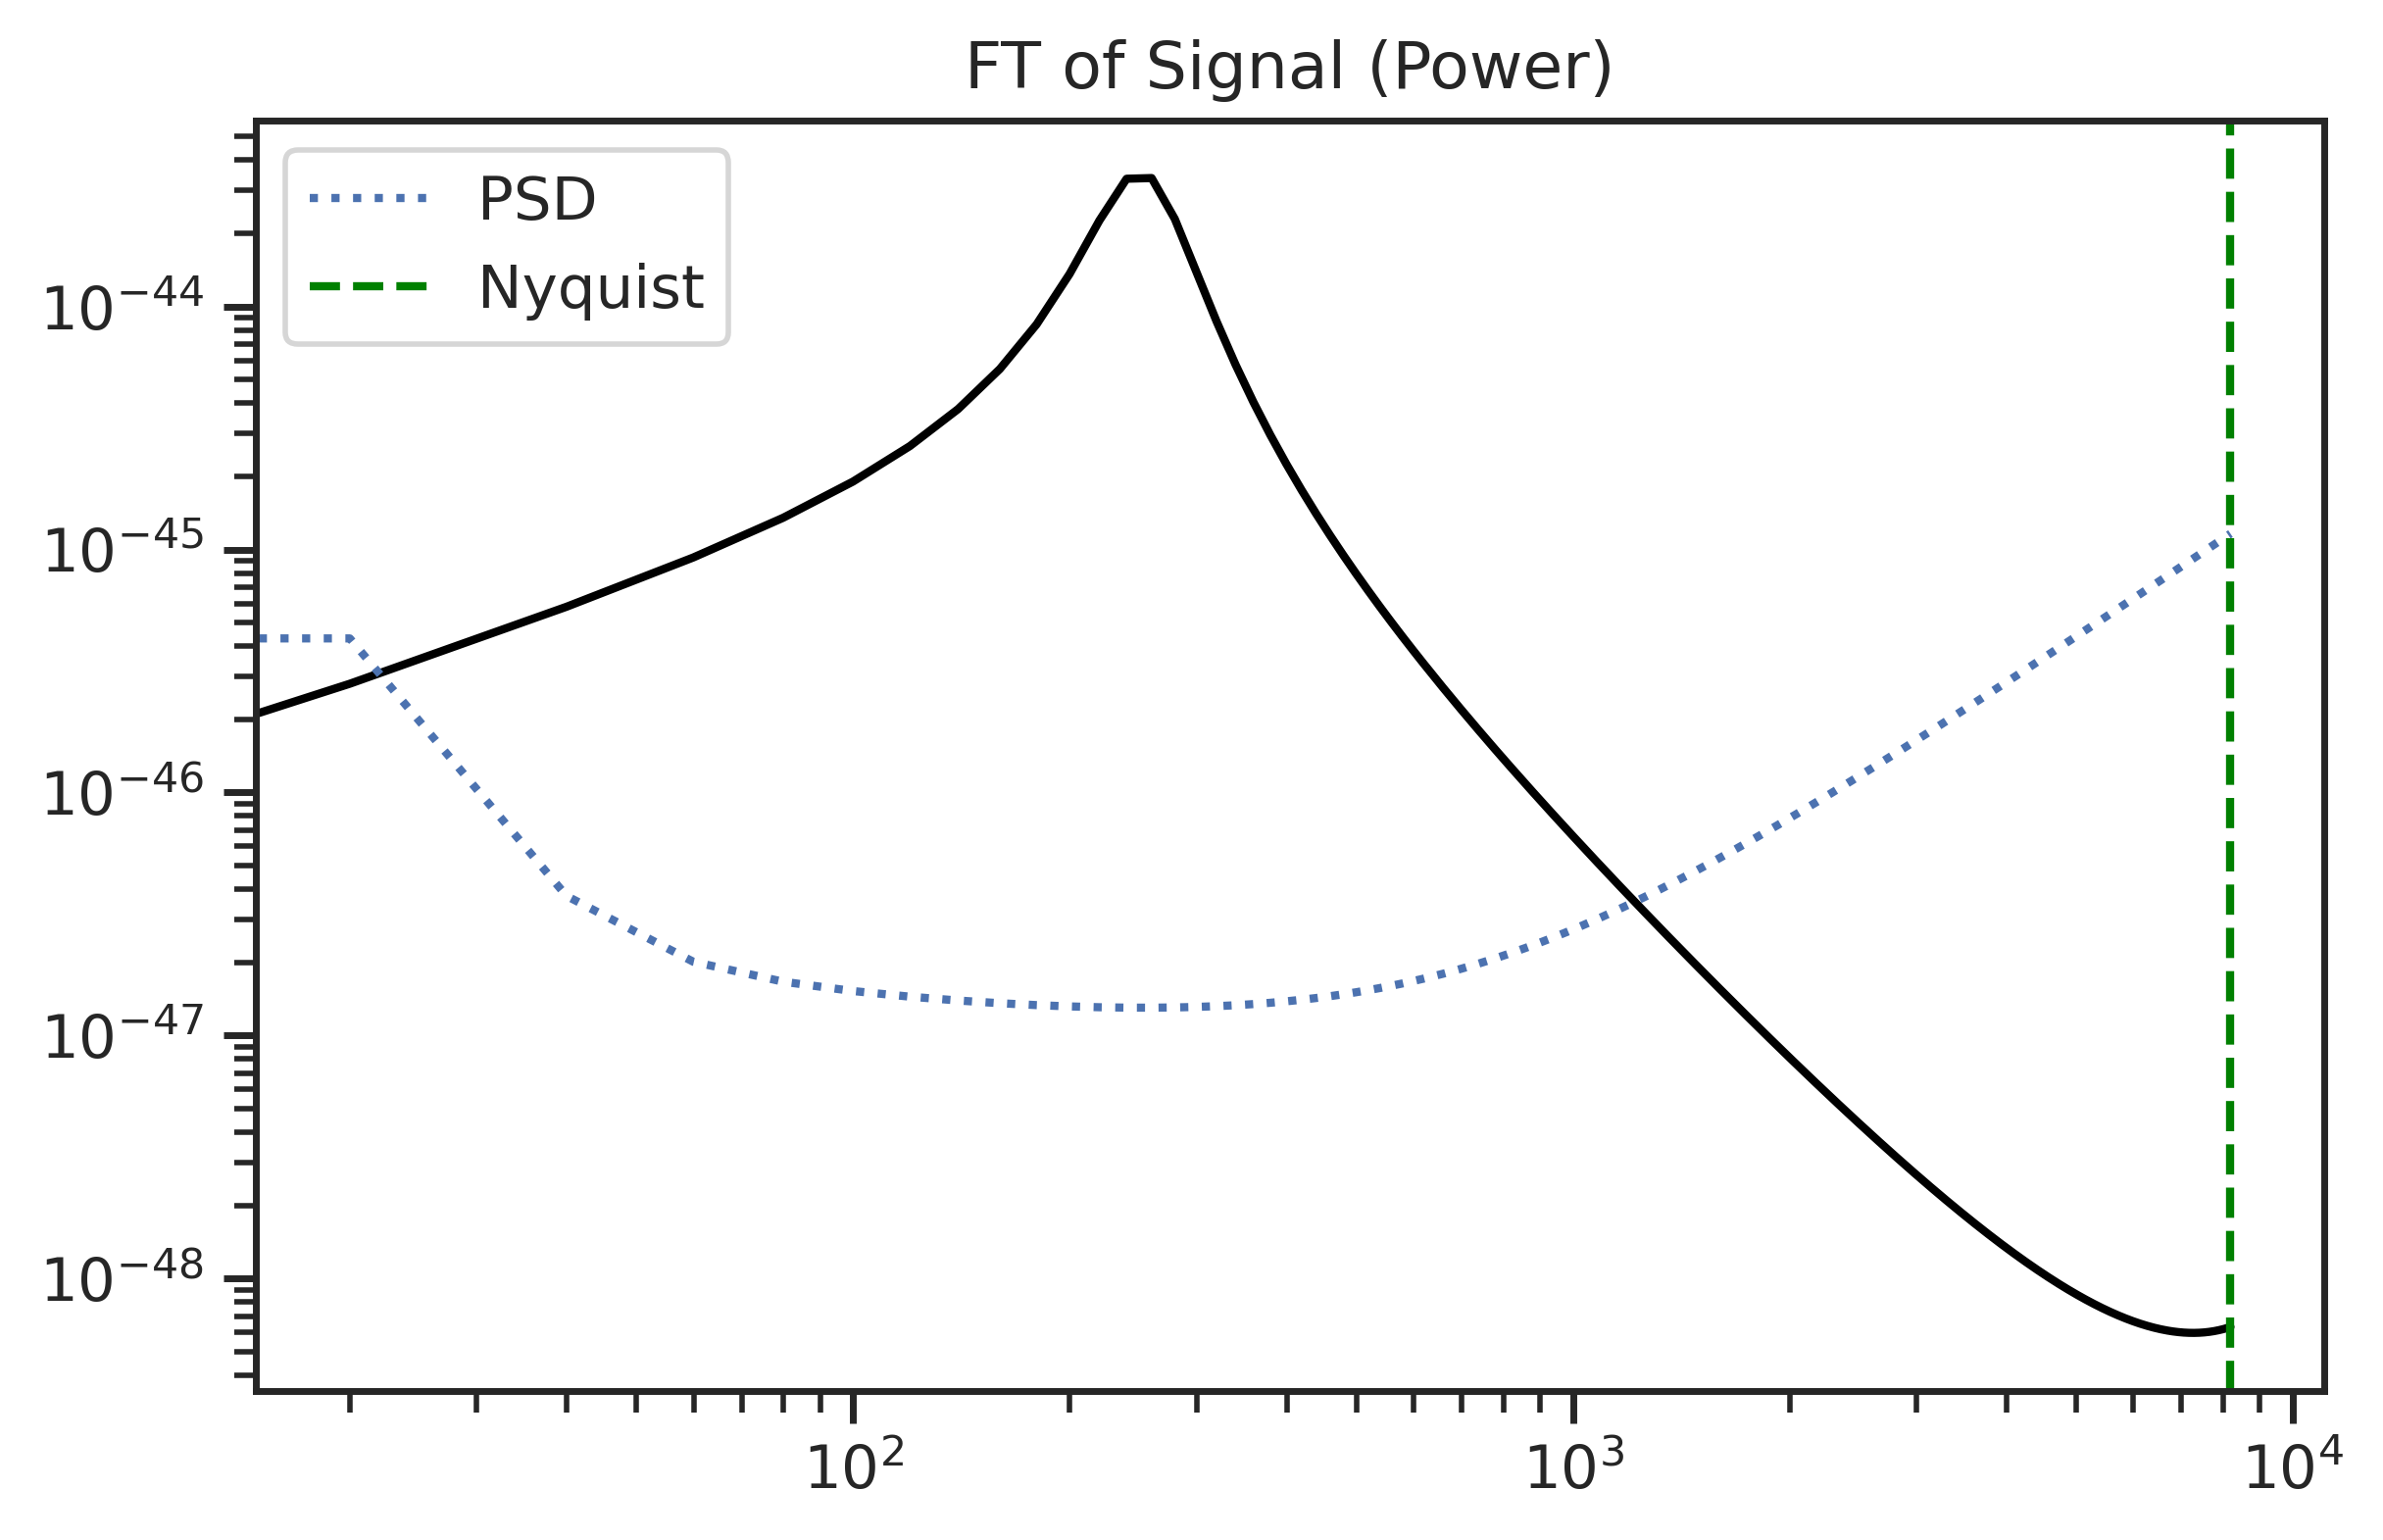

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 294 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 294 seconds.


1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_analogfilter_LIGOPSD_fundamental_ds1_dur0p05s_A3e-21_f250_ph1p5707963267948966_tau0p004.nc


In [372]:
fit_dict_fundamental = {}
ds_list = [1] # amounts we will downsample by in each analysis

duration = 128 #s
psd_scale = 1.5e-45
sample_rate = 2**14
noise_td  = generate_noise(scale=psd_scale, lalpsd = True)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
#phase_qnm = 5.34 # radians
phase_qnm = np.pi/2
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2
dur = 0.05

for ds in ds_list:
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, scale=psd_scale, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()
    analysis_data = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = False,flow=10)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])
    
    
    incr = 0
    running = False
    while not running:
        data_dur = dur+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            print(len(fit.data[None]))
            print(len(fit.acfs[None]))
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
    #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
    psd_plot = laldesignpsd(freqs_plot)
    
    FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
    fit.run(draws = draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_analogfilter_LIGOPSD_fundamental_ds{k}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
        k=k,d=str(dur).replace(".","p"),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

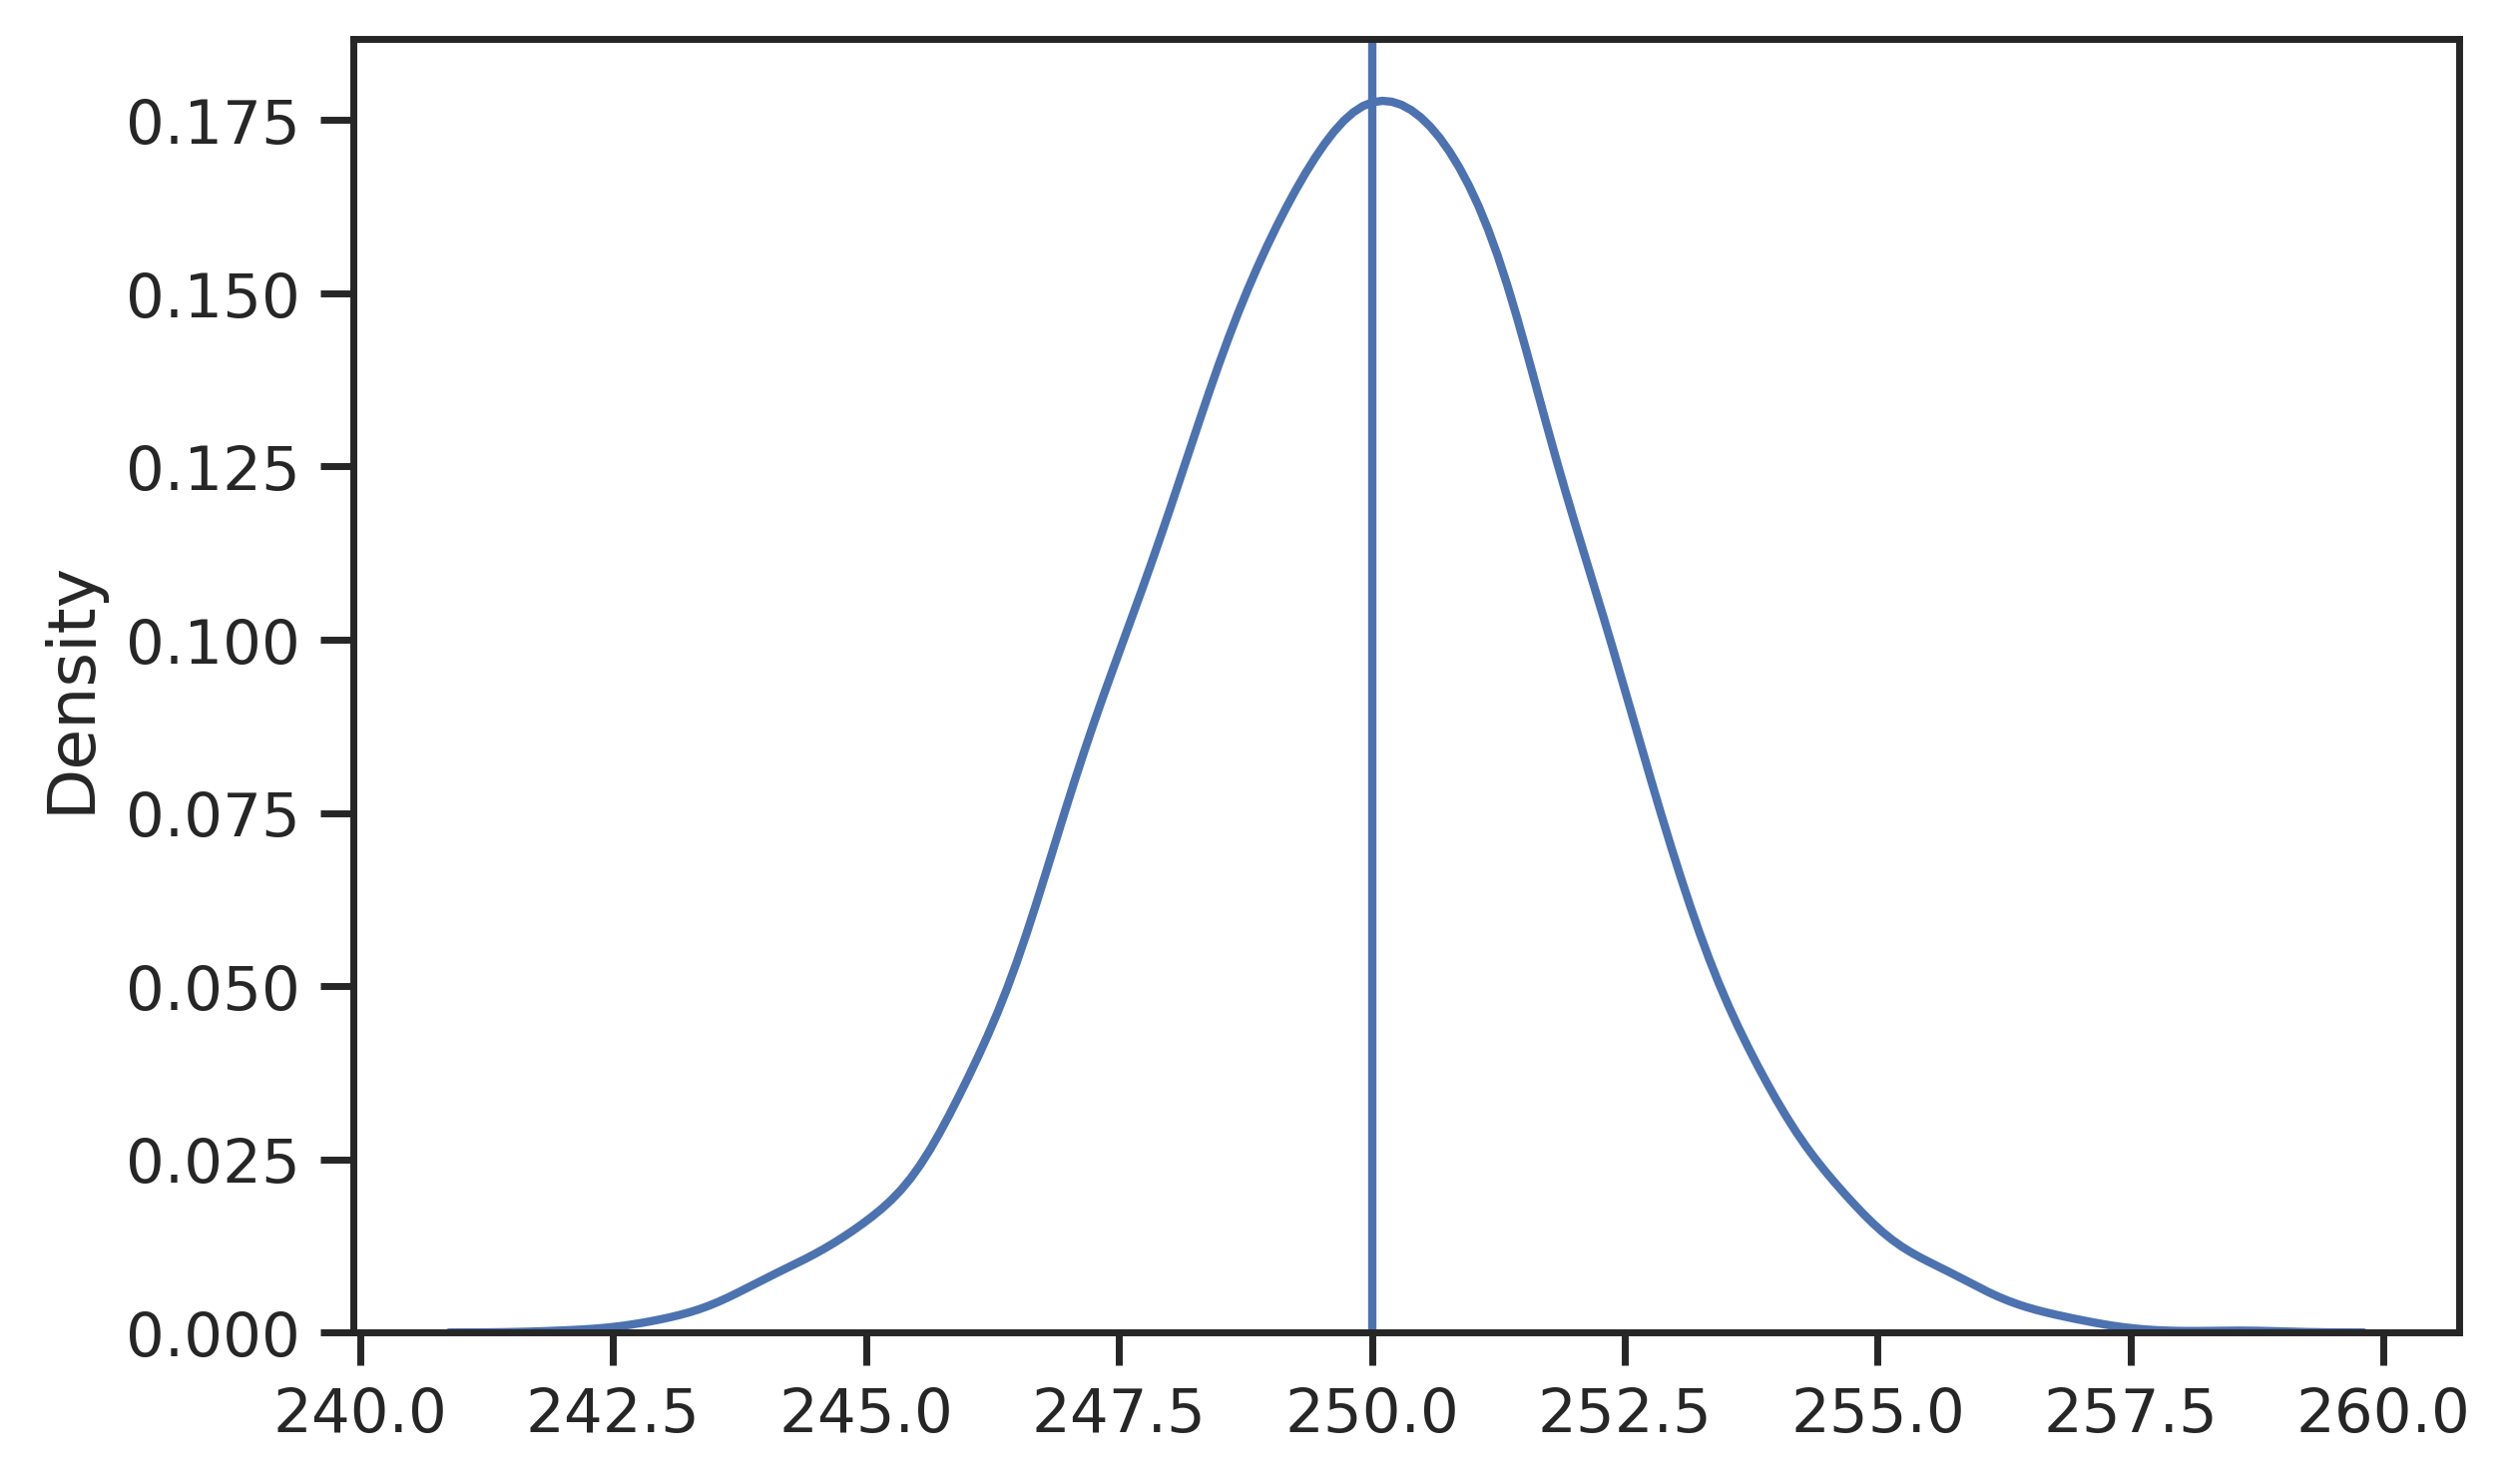

In [373]:
sns.kdeplot(fit_dict_fundamental[1].result.posterior.f.values.flatten())
plt.axvline(f_qnm)

## fundamental only, analysis duration = 0.05 seconds, no-noise injection, LIGO PSD, NO digital filter

In [341]:
fit_dict_fundamental = {}
ds_list = [2,1,4,8,16,32] # amounts we will downsample by in each analysis

duration = 128 #s
psd_scale = 1.5e-45
sample_rate = 2**14
noise_td  = generate_noise(scale=psd_scale, lalpsd = True)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
#phase_qnm = 5.34 # radians
phase_qnm = np.pi/2
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2
dur = 0.05

for ds in ds_list:
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, scale=psd_scale, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()
    analysis_data = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])
    
    
    incr = 0
    running = False
    while not running:
        data_dur = dur+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            print(len(fit.data[None]))
            print(len(fit.acfs[None]))
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    #freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
   # psd_plot = laldesignpsd(freqs_plot)
    
    #FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
    fit.run(draws = draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_NOdigfilt_LIGOPSD_fundamental_ds{k}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
        k=k,d=str(dur).replace(".","p"),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

Analysis segment duration = 0.05
Running with downsampling 2


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...

KeyboardInterrupt



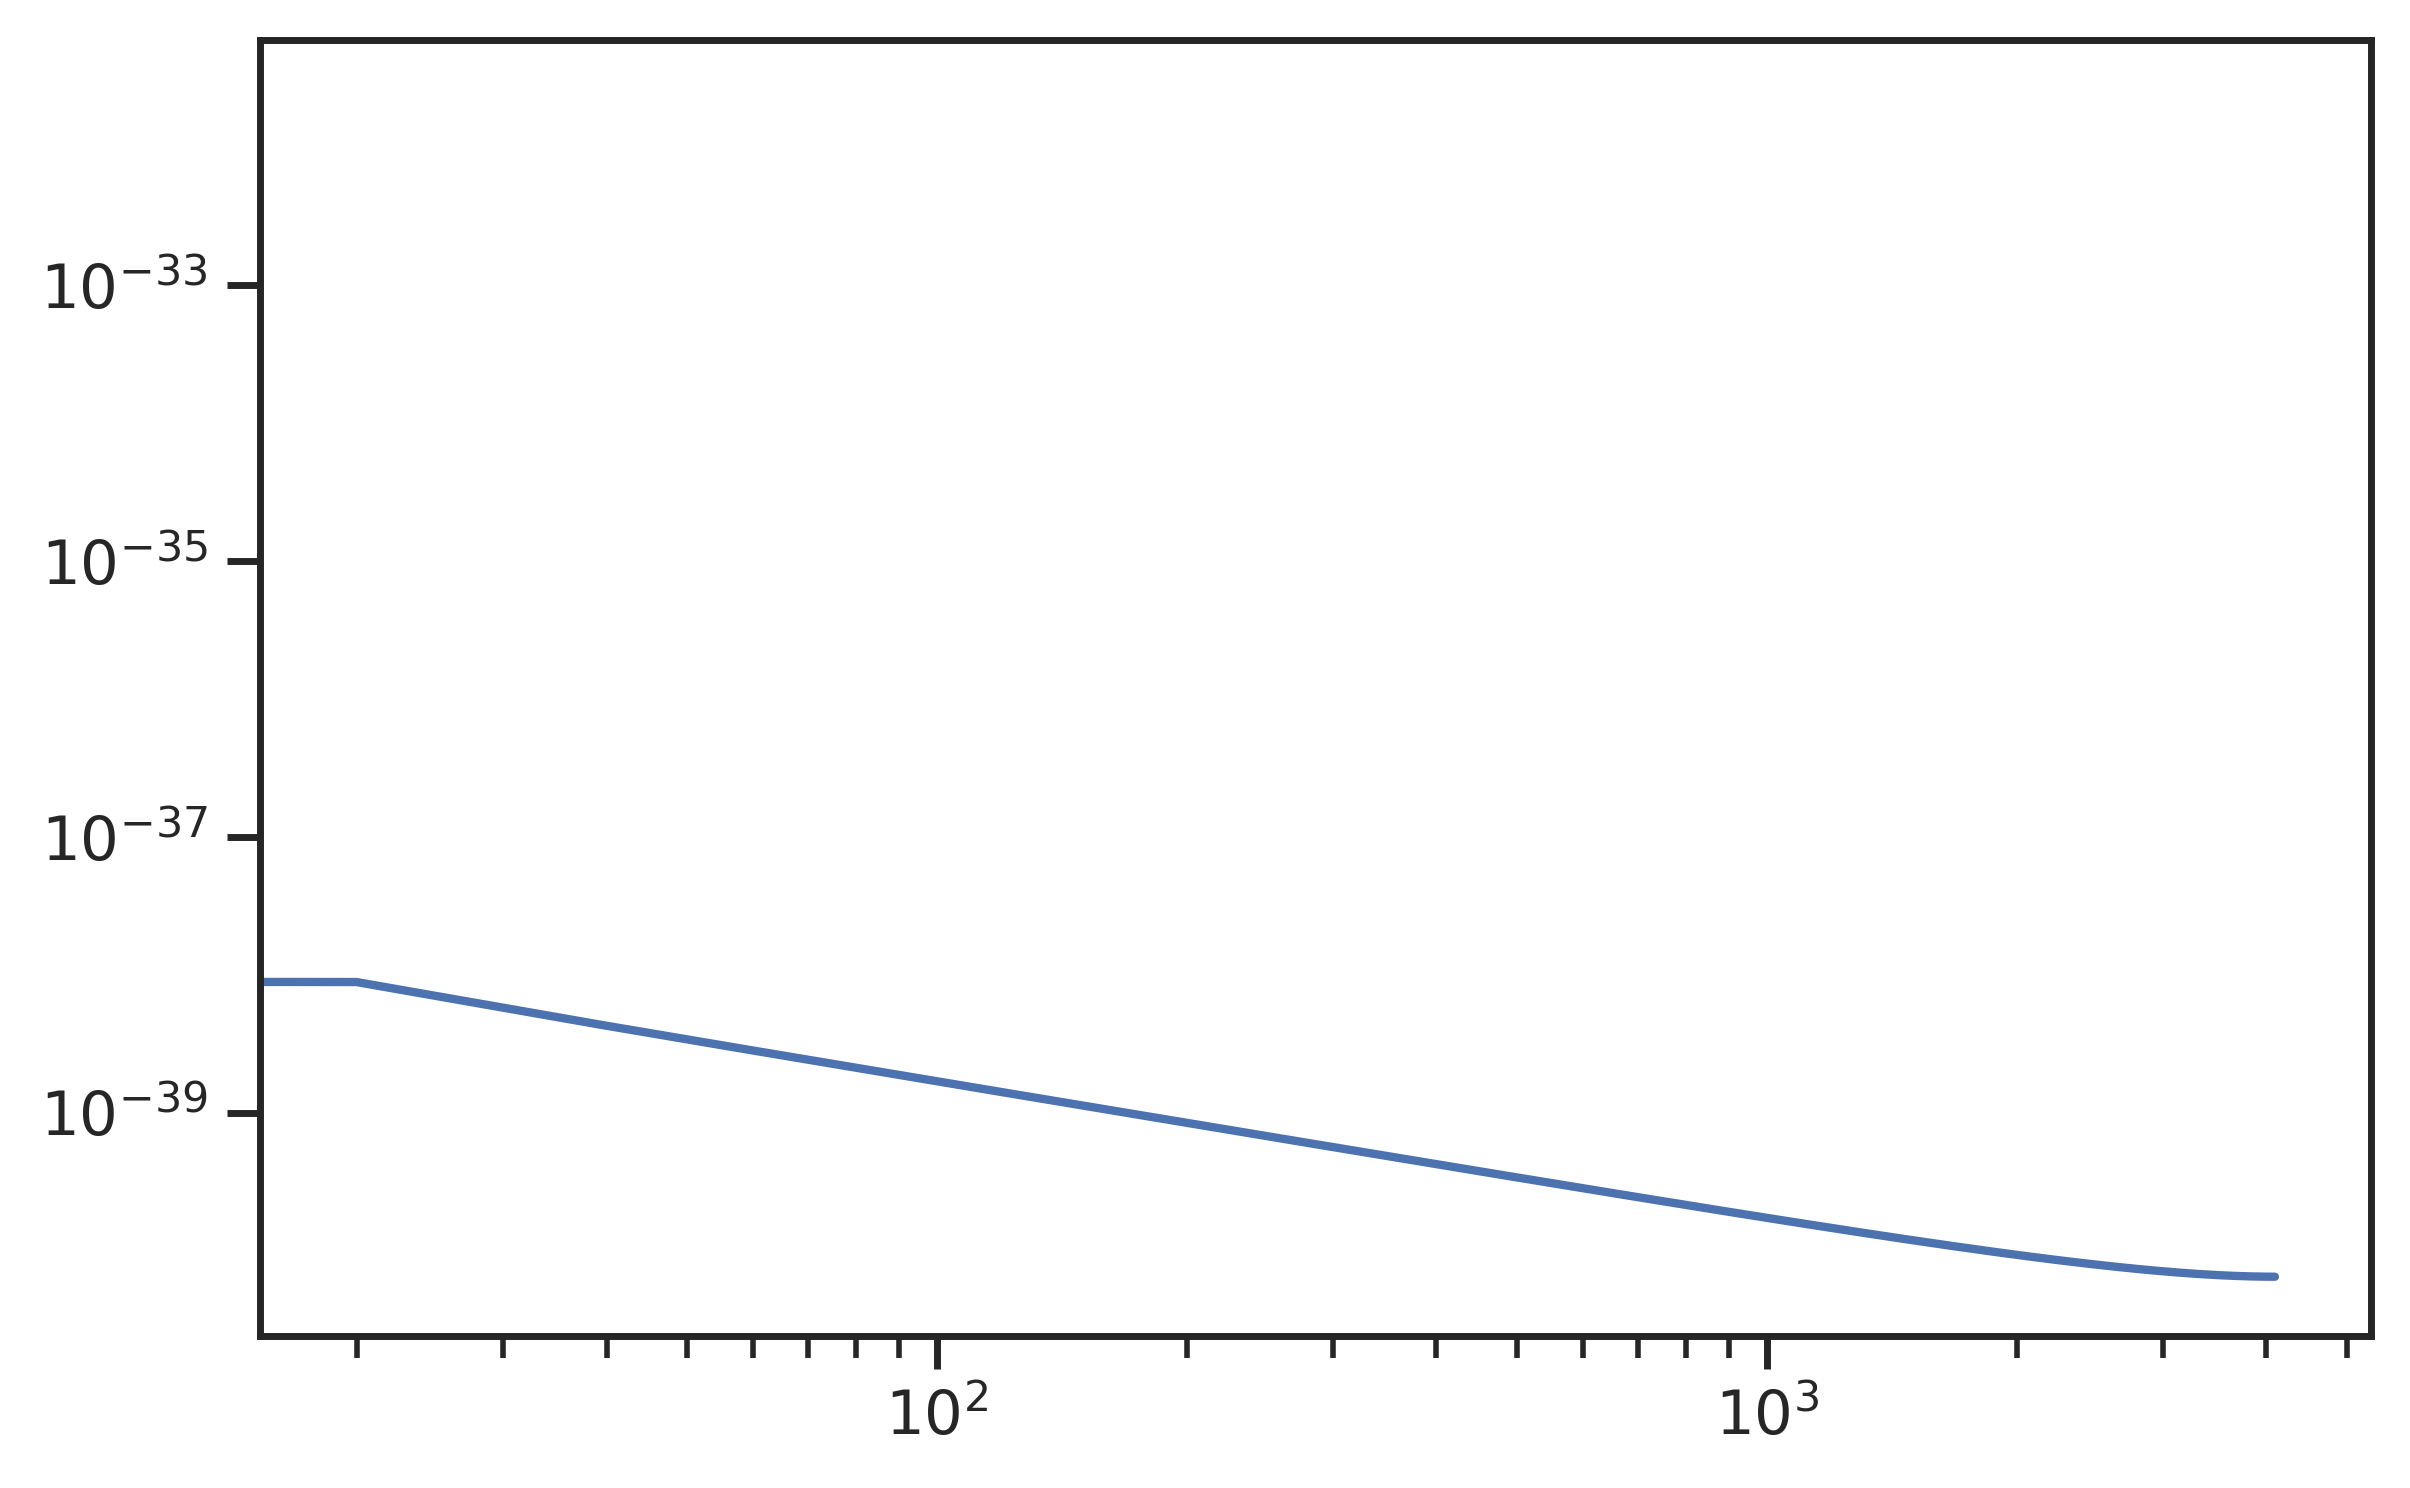

In [342]:
plt.loglog(fit.acfs[None].to_psd())

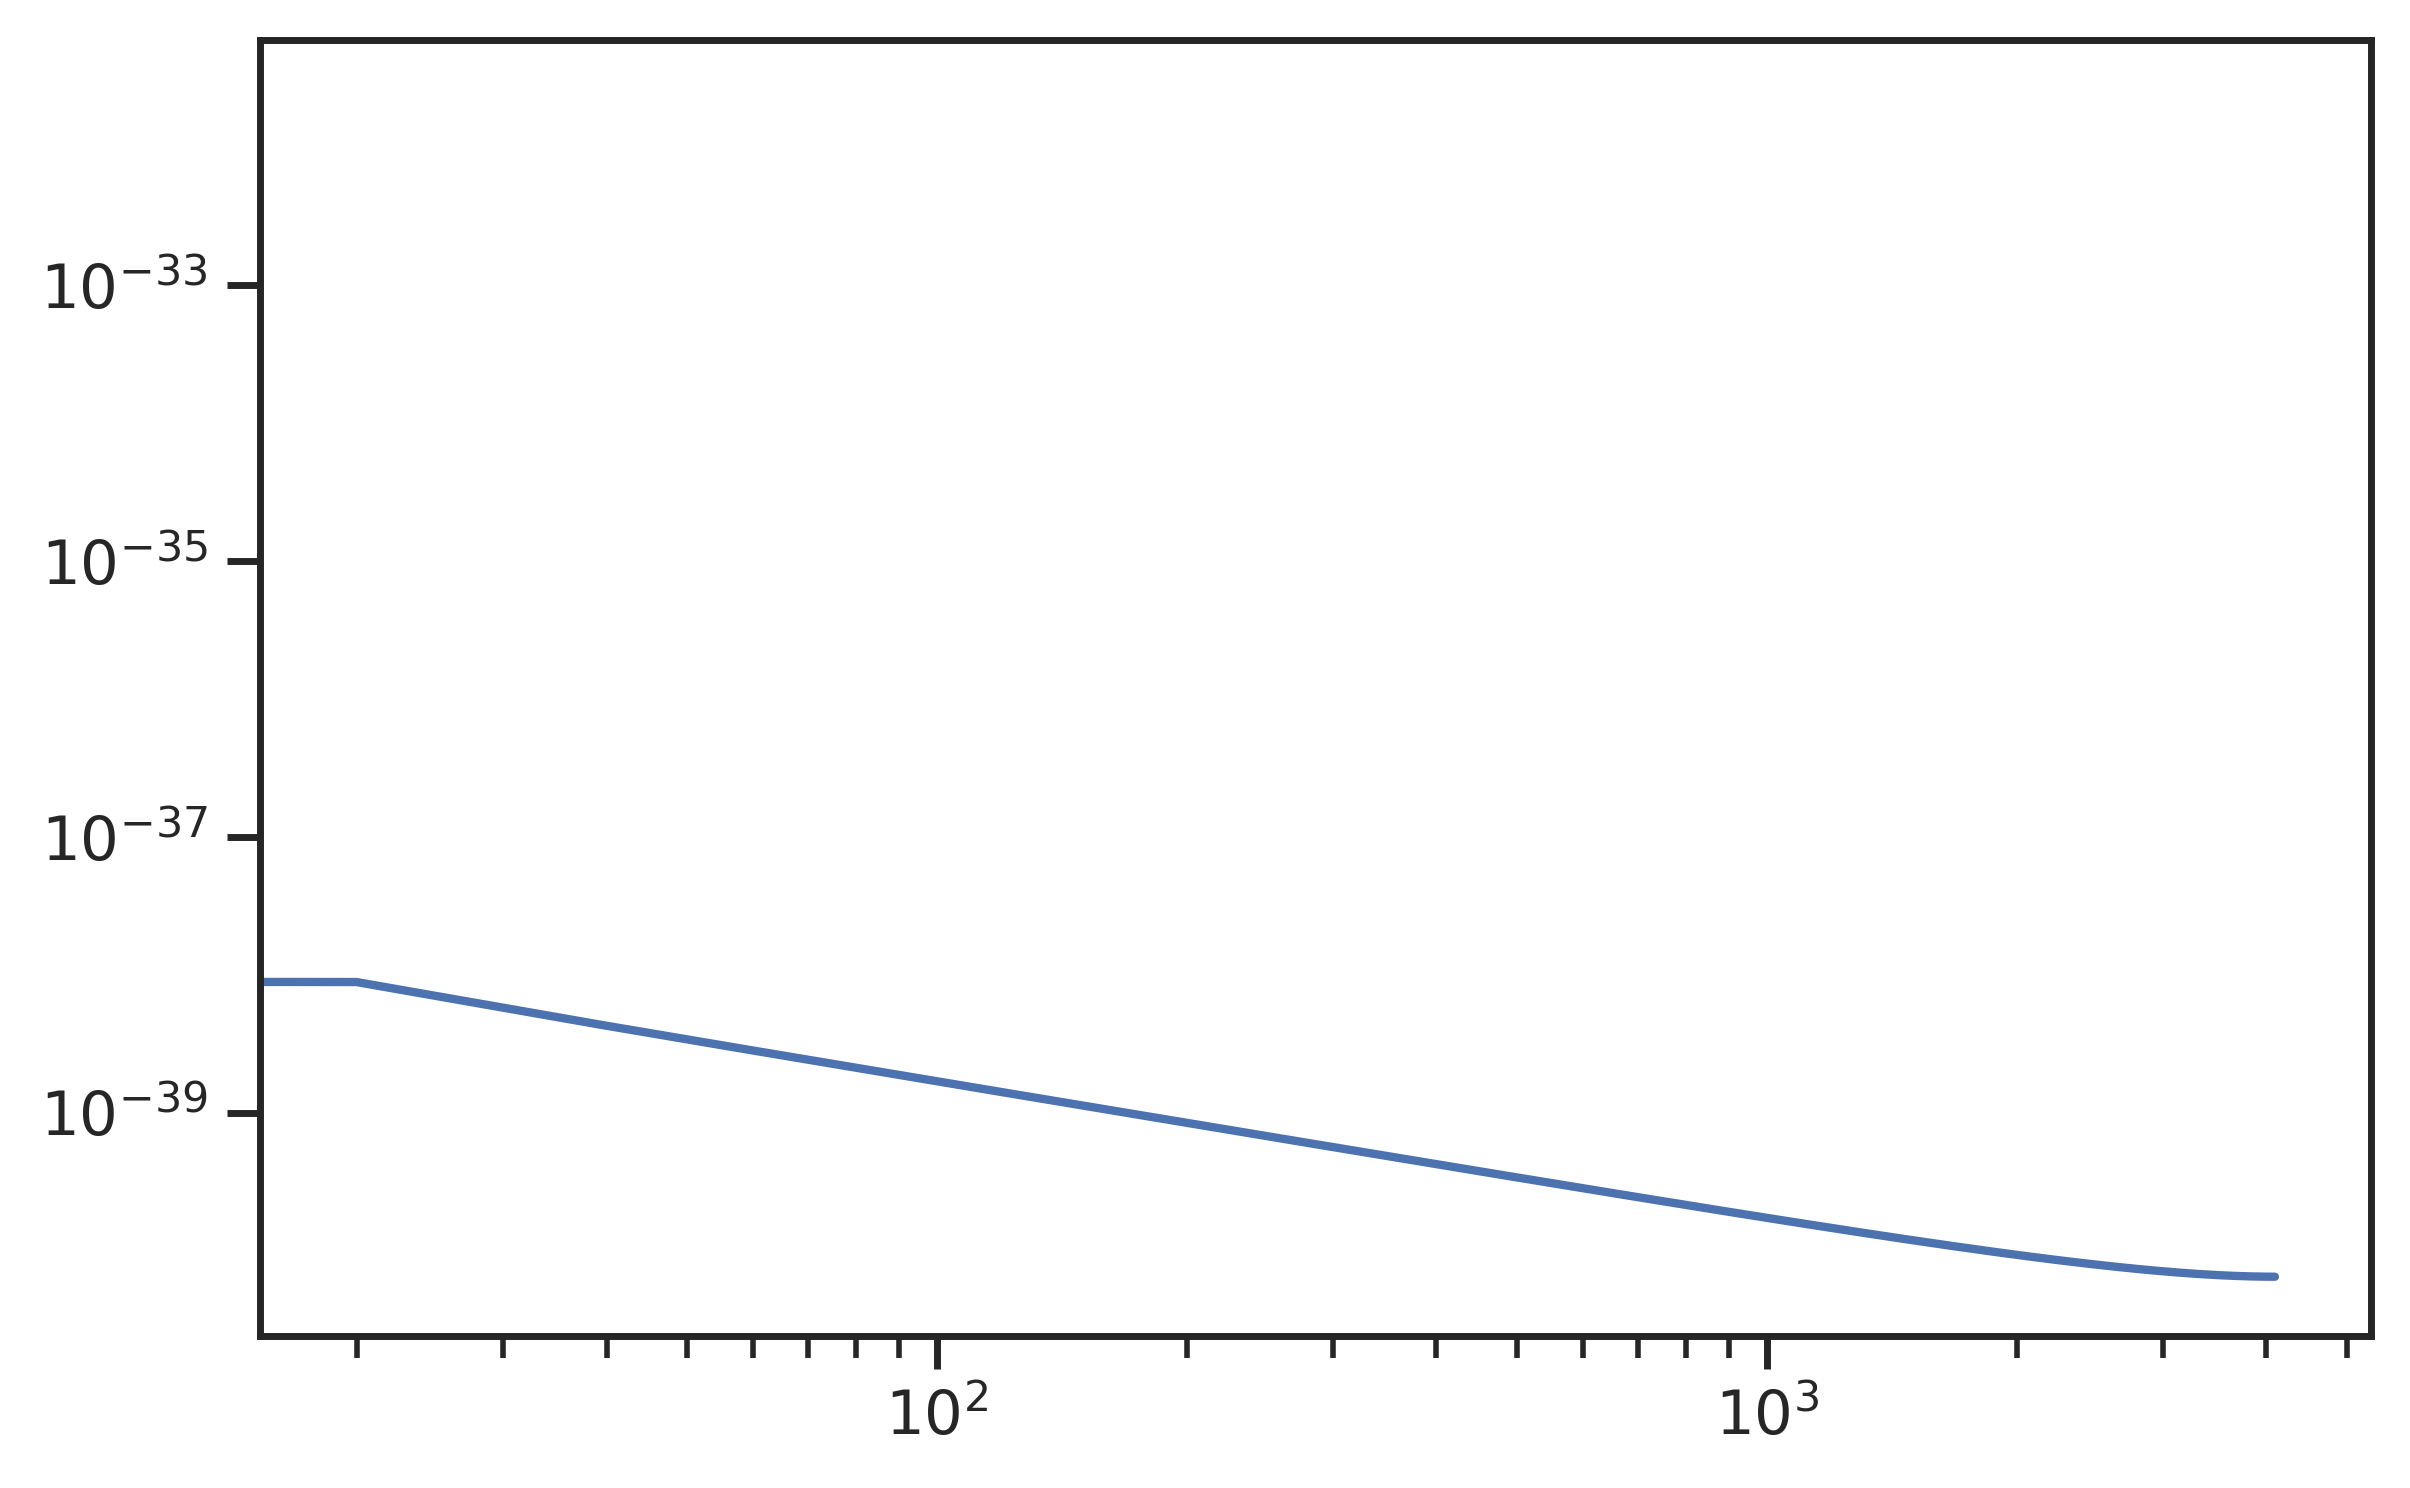

In [340]:
plt.loglog(fit.acfs[None].to_psd())

## fundamental only, analysis duration = 0.05 seconds, NOISE injection, LIGO PSD

In [ ]:
ds_list = [1,4,8,16,32] # amounts we will downsample by in each analysis

duration = 128 #s
psd_scale = 1.5e-45
sample_rate = 2**14
#noise_td  = generate_noise(scale=psd_scale, lalpsd = True)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
#phase_qnm = 5.34 # radians
phase_qnm = np.pi/2

#analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2
dur = 0.05


for div in [1,2,4]:
    
    fit_dict_fundamental = {}

    print("A:",A/div)
    
    snrsq_dict = {}
    
    signal = damped_sinusoid(A=A/div, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

    analysis_data = noise_td + signal


    for ds in ds_list:
        noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, scale=psd_scale, rtrn_psd=True, lalpsd = True)
        acf_analysis = psd_analysis.to_acf()
        analysis_data = ringdown.Data(analysis_data,noise_td.index)
        analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
        #fit = ringdown.Fit('ftau', modes=1)
        #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
        fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])

        whtnd_sig = acf_analysis[0:dur].whiten(signal[t0:t0+dur][::ds])
        whtnd_data = acf_analysis[0:dur].whiten(analysis_data_cond[t0:t0+dur])

        ss = np.sum(np.square(whtnd_sig))
        sd = np.sum(whtnd_sig*whtnd_data)
        dd = np.sum(np.square(whtnd_data))
        snrsq_dict[ds]=[ss,sd,dd]


        incr = 0
        running = False
        while not running:
            data_dur = dur+incr*delta_t
            freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
            fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
            fit.set_target(t0, duration=data_dur)
            fit.update_prior(A_scale_max=10*A/div, M_min=35.0, M_max=140.0)
            if incr>ds*2:
                raise ValueError("Something is broken in this loop")
            elif len(fit.data[None])!=len(fit.acfs[None]):
                print(len(fit.data[None]))
                print(len(fit.acfs[None]))
                incr+=1
            else:
                running = True
        print("Analysis segment duration =",data_dur)
        print("Running with downsampling",ds)

        freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
        #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
        psd_plot = laldesignpsd(freqs_plot)

        FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
        fit.run(draws = draws)
        fit_dict_fundamental[ds] = fit

    print(snrsq_dict)
    
    for k,v in fit_dict_fundamental.items():
        print(k)
        name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSD_fundamental_ds{k}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
            k=k,d=str(dur).replace(".","p"),a=str(A/div).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"))
        print(name_str)
        v.result.to_netcdf(name_str)

In [124]:
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSD_fundamental_ds{k}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
        k=k,d=str(dur).replace(".","p"),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSD_fundamental_ds1_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
4
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSD_fundamental_ds4_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
8
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSD_fundamental_ds8_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
16
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSD_fundamental_ds16_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
32
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSD_fundamental_ds32_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc


## Longer duration, no downsample, noise

### Spike

In [161]:
fit_dict_fundamental = {}
dur_list = [0.01,0.05,0.1,0.2] # duration of data segment in each analysis
ds=1

duration = 128 #s
sample_rate = 2**12

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A_list = [3e-21,3e-21/2,3e-21/4]
tau_qnm = 4e-3
phase_qnm = 5.34 # radians

# PSD parameters
spike_std = 0.1
spike_mean = f_qnm
spike_amp = 1.5e-45

noise_td, psd_analysis = generate_noise(sr=sample_rate/ds, scale=psd_scale, rtrn_psd=True, lalpsd = True,
                                            spike_mean=spike_mean, spike_std=spike_std, spike_amp = spike_amp)
        
#Save noise
noise_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/NOISETIMESERIES_GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds{k}_sr{r}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.csv".format(
            k=ds,r=str(int(sample_rate)),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
noise_td.to_csv(noise_name_str)

times = noise_td.index
draws = 2000 #number of samples per chain

delta_t = 1/sample_rate
t0 = duration/2

for A in A_list:
    
    print(A)
    
    fit_dict_fundamental = {}

    signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

    analysis_data = noise_td + signal

    for dur in dur_list:
        acf_analysis = psd_analysis.to_acf()
        analysis_data = ringdown.Data(analysis_data,noise_td.index)
        analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
        #fit = ringdown.Fit('ftau', modes=1)
        #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
        fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])


        incr = 0
        running = False
        while not running:
            data_dur = dur+incr*delta_t
            freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
            fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
            fit.set_target(t0, duration=data_dur)
            fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
            if incr>ds*2:
                raise ValueError("Something is broken in this loop")
            elif len(fit.data[None])!=len(fit.acfs[None]):
                print(len(fit.data[None]))
                print(len(fit.acfs[None]))
                incr+=1
            else:
                running = True
        print("Analysis segment duration =",data_dur)
        print("Running with downsampling",ds)

        freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
        #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
        #psd_plot = laldesignpsd(freqs_plot) + spike_amp*np.exp(-0.5*((freqs_plot-spike_mean)/spike_std)**2) # Gaussian spike
        psd_plot = laldesignpsd(freqs_plot) + spike_amp*spike_std/((2*np.pi)*((freqs_plot-spike_mean)**2+(spike_std)**2/4)) # Lorentzian spike


        #FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
        fit.run(draws = draws)
        fit_dict_fundamental[dur] = fit
        
    for k,v in fit_dict_fundamental.items():
        print(k)
        name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.nc".format(
            k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
        print(name_str)
        v.result.to_netcdf(name_str)

Adding Lorentzian spike to PSD
3e-21
Analysis segment duration = 0.01
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 385 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 385 seconds.


Analysis segment duration = 0.05
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 906 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 906 seconds.


Analysis segment duration = 0.1
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 683 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 683 seconds.


Analysis segment duration = 0.2
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1556 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1556 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


0.01
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p01s_A3e-21_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A3e-21_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A3e-21_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.2
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A3e-21_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
1.5e-21
Analysis segment duration = 0.01
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 294 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 294 seconds.


Analysis segment duration = 0.05
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 486 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 486 seconds.


Analysis segment duration = 0.1
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 605 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 605 seconds.


Analysis segment duration = 0.2
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1498 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1498 seconds.


0.01
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p01s_A1p5e-21_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A1p5e-21_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A1p5e-21_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.2
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A1p5e-21_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
7.5e-22
Analysis segment duration = 0.01
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 386 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 386 seconds.


Analysis segment duration = 0.05
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 542 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 542 seconds.


Analysis segment duration = 0.1
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 582 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 582 seconds.


Analysis segment duration = 0.2
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1472 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1472 seconds.


0.01
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p01s_A7p5e-22_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A7p5e-22_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A7p5e-22_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc
0.2
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A7p5e-22_f250_ph5p34_tau0p004_spikeA1p5e-45M250S0p1.nc


# GW190521-like signal

## Longer duration, no downsample, no noise

### No Spike

In [58]:
fit_dict_fundamental = {}
dur_list = [0.01,0.05,0.1,0.2] # duration of data segment in each analysis
ds=1

duration = 128 #s
sample_rate = 2**12

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
#A_list = [3e-21,3e-21/2,3e-21/4]
f_qnm = 67.489
A_list = [1.2e-21]
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

noise_td, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True)
        
#Save noise
#noise_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/NOISETIMESERIES_GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds{k}_sr{r}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.csv".format(
#            k=ds,r=str(int(sample_rate)),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
#            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
#noise_td.to_csv(noise_name_str)

times = noise_td.index
draws = 2000 #number of samples per chain

delta_t = 1/sample_rate
t0 = duration/2

for A in A_list:
    
    print(A)
    
    fit_dict_fundamental = {}

    signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

    analysis_data = signal

    for dur in dur_list:
        acf_analysis = psd_analysis.to_acf()
        analysis_data = ringdown.Data(analysis_data,noise_td.index)
        analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
        #fit = ringdown.Fit('ftau', modes=1)
        #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
        fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])


        incr = 0
        running = False
        while not running:
            data_dur = dur+incr*delta_t
            freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
            fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
            fit.set_target(t0, duration=data_dur)
            fit.update_prior(A_scale_max=10*A, M_min=35.0*4, M_max=140.0*4)
            if incr>ds*2:
                raise ValueError("Something is broken in this loop")
            elif len(fit.data[None])!=len(fit.acfs[None]):
                print(len(fit.data[None]))
                print(len(fit.acfs[None]))
                incr+=1
            else:
                running = True
        print("Analysis segment duration =",data_dur)
        print("Running with downsampling",ds)

        freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
        #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
        #psd_plot = laldesignpsd(freqs_plot) + spike_amp*np.exp(-0.5*((freqs_plot-spike_mean)/spike_std)**2) # Gaussian spike
        psd_plot = laldesignpsd(freqs_plot) + spike_amp*spike_std/((2*np.pi)*((freqs_plot-spike_mean)**2+(spike_std)**2/4)) # Lorentzian spike


        #FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
        fit.run(draws = draws)
        fit_dict_fundamental[dur] = fit
        
    for k,v in fit_dict_fundamental.items():
        print(k)
        name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSD_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
            k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
        print(name_str)
        v.result.to_netcdf(name_str)

1.2e-21
Analysis segment duration = 0.01
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 144 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 144 seconds.


Analysis segment duration = 0.05
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 306 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 306 seconds.


Analysis segment duration = 0.1
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 446 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 446 seconds.


Analysis segment duration = 0.2
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 938 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 938 seconds.


0.01
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSD_fundamental_ds1_sr4096_dur0p01s_A1p2e-21_f67.489_ph5p34_tau0p0155.nc
0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSD_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67.489_ph5p34_tau0p0155.nc
0.1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSD_fundamental_ds1_sr4096_dur0p1s_A1p2e-21_f67.489_ph5p34_tau0p0155.nc
0.2
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSD_fundamental_ds1_sr4096_dur0p2s_A1p2e-21_f67.489_ph5p34_tau0p0155.nc


### Spike

In [51]:
fit_dict_fundamental = {}
dur_list = [0.01,0.05,0.1,0.2] # duration of data segment in each analysis
ds=1

duration = 128 #s
sample_rate = 2**12

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
#A_list = [3e-21,3e-21/2,3e-21/4]
f_qnm = 67.489
A_list = [1.2e-21]
tau_qnm = 0.0155
phase_qnm = 5.34 # radians


# PSD parameters
spike_std = 0.05
spike_mean = f_qnm
spike_amp = 1.5e-45

noise_td, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True,
                                            spike_mean=spike_mean, spike_std=spike_std, spike_amp = spike_amp)
        
#Save noise
#noise_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/NOISETIMESERIES_GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds{k}_sr{r}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.csv".format(
#            k=ds,r=str(int(sample_rate)),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
#            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
#noise_td.to_csv(noise_name_str)

times = noise_td.index
draws = 2000 #number of samples per chain

delta_t = 1/sample_rate
t0 = duration/2

for A in A_list:
    
    print(A)
    
    fit_dict_fundamental = {}

    signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

    analysis_data = signal

    for dur in dur_list:
        acf_analysis = psd_analysis.to_acf()
        analysis_data = ringdown.Data(analysis_data,noise_td.index)
        analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
        #fit = ringdown.Fit('ftau', modes=1)
        #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
        fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])


        incr = 0
        running = False
        while not running:
            data_dur = dur+incr*delta_t
            freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
            fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
            fit.set_target(t0, duration=data_dur)
            fit.update_prior(A_scale_max=10*A, M_min=35.0*4, M_max=140.0*4)
            if incr>ds*2:
                raise ValueError("Something is broken in this loop")
            elif len(fit.data[None])!=len(fit.acfs[None]):
                print(len(fit.data[None]))
                print(len(fit.acfs[None]))
                incr+=1
            else:
                running = True
        print("Analysis segment duration =",data_dur)
        print("Running with downsampling",ds)

        freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
        #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
        #psd_plot = laldesignpsd(freqs_plot) + spike_amp*np.exp(-0.5*((freqs_plot-spike_mean)/spike_std)**2) # Gaussian spike
        psd_plot = laldesignpsd(freqs_plot) + spike_amp*spike_std/((2*np.pi)*((freqs_plot-spike_mean)**2+(spike_std)**2/4)) # Lorentzian spike


        #FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
        fit.run(draws = draws)
        fit_dict_fundamental[dur] = fit
        
    for k,v in fit_dict_fundamental.items():
        print(k)
        name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSDLorentzianspike_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.nc".format(
            k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
        print(name_str)
        v.result.to_netcdf(name_str)

Adding Lorentzian spike to PSD
1.2e-21
Analysis segment duration = 0.01
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 140 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 140 seconds.


Analysis segment duration = 0.05
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 305 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 305 seconds.


Analysis segment duration = 0.1
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 346 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 346 seconds.


Analysis segment duration = 0.2
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 891 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 891 seconds.


0.01
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p01s_A1p2e-21_f67.489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67.489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A1p2e-21_f67.489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.2
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A1p2e-21_f67.489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc


## Longer duration, no downsample, noise

### Spike

In [ ]:
fit_dict_fundamental = {}
dur_list = [0.025,0.05,0.1,0.2] # duration of data segment in each analysis
ds=1

duration = 128 #s
sample_rate = 2**12

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
#A_list = [3e-21,3e-21/2,3e-21/4]
f_qnm = 67.489
A_list = [1.2e-21*2,1.2e-21/2]
tau_qnm = 0.0155
phase_qnm = 5.34 # radians


# PSD parameters
spike_std = 0.05
spike_mean = f_qnm
spike_amp = 1.5e-45

noise_td, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True,
                                            spike_mean=spike_mean, spike_std=spike_std, spike_amp = spike_amp)
        
#Save noise
#noise_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/NOISETIMESERIES_GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds{k}_sr{r}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.csv".format(
#            k=ds,r=str(int(sample_rate)),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
#            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
#noise_td.to_csv(noise_name_str)

#re-assign noise to be original noise of spike runs
noise_td = pd.read_csv("/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/NOISETIMESERIES_GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.csv")
noise_td = ringdown.TimeSeries(noise_td.values.T[1],noise_td.values.T[0])

times = noise_td.index
draws = 2000 #number of samples per chain

delta_t = 1/sample_rate
t0 = duration/2

for A in A_list:
    
    print(A)
    
    fit_dict_fundamental = {}

    signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

    analysis_data = noise_td + signal

    for dur in dur_list:
        acf_analysis = psd_analysis.to_acf()
        analysis_data = ringdown.Data(analysis_data,noise_td.index)
        analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
        #fit = ringdown.Fit('ftau', modes=1)
        #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
        fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])


        incr = 0
        running = False
        while not running:
            data_dur = dur+incr*delta_t
            freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
            fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
            fit.set_target(t0, duration=data_dur)
            fit.update_prior(A_scale_max=10*A, M_min=35.0*4, M_max=140.0*4)
            if incr>ds*2:
                raise ValueError("Something is broken in this loop")
            elif len(fit.data[None])!=len(fit.acfs[None]):
                print(len(fit.data[None]))
                print(len(fit.acfs[None]))
                incr+=1
            else:
                running = True
        print("Analysis segment duration =",data_dur)
        print("Running with downsampling",ds)

        freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
        #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
        #psd_plot = laldesignpsd(freqs_plot) + spike_amp*np.exp(-0.5*((freqs_plot-spike_mean)/spike_std)**2) # Gaussian spike
        psd_plot = laldesignpsd(freqs_plot) + spike_amp*spike_std/((2*np.pi)*((freqs_plot-spike_mean)**2+(spike_std)**2/4)) # Lorentzian spike


        #FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
        fit.run(draws = draws)
        fit_dict_fundamental[dur] = fit
        
    for k,v in fit_dict_fundamental.items():
        print(k)
        name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.nc".format(
            k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
        print(name_str)
        v.result.to_netcdf(name_str)

Adding Lorentzian spike to PSD
2.4e-21
Analysis segment duration = 0.025
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 291 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 291 seconds.


Analysis segment duration = 0.05
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 344 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 344 seconds.


Analysis segment duration = 0.1
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


In [522]:
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.nc".format(
        k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
        spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

0.01
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p01s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.2
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc


### Spike subtracted

In [11]:
fit_dict_fundamental = {}
dur_list = [0.1] # duration of data segment in each analysis
ds=1

duration = 128 #s
sample_rate = 2**12

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
#A_list = [3e-21,3e-21/2,3e-21/4]
f_qnm = 67.489
A_list = [1.2e-21]
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

# PSD parameters
spike_std = 0.05
spike_mean = f_qnm
spike_amp = 1.5e-45

noise_td, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True)

#re-assign noise to be original noise of spike runs
noise_td = pd.read_csv("/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/NOISETIMESERIES_GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.csv")
noise_td = ringdown.TimeSeries(noise_td.values.T[1],noise_td.values.T[0])
        
times = noise_td.index
draws = 2000 #number of samples per chain

delta_t = 1/sample_rate
t0 = duration/2

for A in A_list:
    
    print(A)
    
    fit_dict_fundamental = {}

    signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

    analysis_data = noise_td + signal
    
    f0s = [f_qnm]
    bws = [8]
    cleaned_times, cleaned_strain = clean_strain(analysis_data.time, analysis_data.values, sample_rate, f0s, bws, 16.0)
    
    analysis_data = ringdown.TimeSeries(cleaned_strain,cleaned_times)

    for dur in dur_list:
        acf_analysis = psd_analysis.to_acf()
        analysis_data = ringdown.Data(analysis_data,noise_td.index)
        analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
        #fit = ringdown.Fit('ftau', modes=1)
        #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
        fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])


        incr = 0
        running = False
        while not running:
            data_dur = dur+incr*delta_t
            freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
            fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
            fit.set_target(t0, duration=data_dur)
            fit.update_prior(A_scale_max=10*A, M_min=35.0*4, M_max=140.0*4)
            if incr>ds*2:
                raise ValueError("Something is broken in this loop")
            elif len(fit.data[None])!=len(fit.acfs[None]):
                print(len(fit.data[None]))
                print(len(fit.acfs[None]))
                incr+=1
            else:
                running = True
        print("Analysis segment duration =",data_dur)
        print("Running with downsampling",ds)

        freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
        #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
        #psd_plot = laldesignpsd(freqs_plot) + spike_amp*np.exp(-0.5*((freqs_plot-spike_mean)/spike_std)**2) # Gaussian spike
        psd_plot = laldesignpsd(freqs_plot) + spike_amp*spike_std/((2*np.pi)*((freqs_plot-spike_mean)**2+(spike_std)**2/4)) # Lorentzian spike


        #FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
        fit.run(draws = draws)
        fit_dict_fundamental[dur] = fit
        
    for k,v in fit_dict_fundamental.items():
        print(k)
        name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_noise_LIGOPSDLorentzianspikeSUBTRACTED_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.nc".format(
            k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
        print(name_str)
        v.result.to_netcdf(name_str)

1.2e-21


NameError: name 'phase_qnm' is not defined

#### Spike subtracted from noise without signal

In [45]:
fit_dict_fundamental = {}
dur_list = [0.1] # duration of data segment in each analysis
ds=1

duration = 128 #s
sample_rate = 2**12

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
#A_list = [3e-21,3e-21/2,3e-21/4]
f_qnm = 67.489
A_list = [1.2e-21]
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

# PSD parameters
spike_std = 0.05
spike_mean = f_qnm
spike_amp = 1.5e-45

noise_td, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True)

#re-assign noise to be original noise of spike runs
noise_td = pd.read_csv("/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/NOISETIMESERIES_GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.csv")
noise_td = ringdown.TimeSeries(noise_td.values.T[1],noise_td.values.T[0])
        
times = noise_td.index
draws = 2000 #number of samples per chain

delta_t = 1/sample_rate
t0 = duration/2

for A in A_list:
    
    print(A)
    
    fit_dict_fundamental = {}

    signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

    analysis_data = noise_td
    
    f0s = [f_qnm]
    bws = [8]
    cleaned_times, cleaned_strain = clean_strain(analysis_data.time, analysis_data.values, sample_rate, f0s, bws, 16.0)
    
    analysis_data = ringdown.TimeSeries(cleaned_strain,cleaned_times) + signal[cleaned_times]

    for dur in dur_list:
        acf_analysis = psd_analysis.to_acf()
        analysis_data = ringdown.Data(analysis_data,noise_td.index)
        analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
        #fit = ringdown.Fit('ftau', modes=1)
        #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
        fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])


        incr = 0
        running = False
        while not running:
            data_dur = dur+incr*delta_t
            freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
            fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
            fit.set_target(t0, duration=data_dur)
            fit.update_prior(A_scale_max=10*A, M_min=35.0*4, M_max=140.0*4)
            if incr>ds*2:
                raise ValueError("Something is broken in this loop")
            elif len(fit.data[None])!=len(fit.acfs[None]):
                print(len(fit.data[None]))
                print(len(fit.acfs[None]))
                incr+=1
            else:
                running = True
        print("Analysis segment duration =",data_dur)
        print("Running with downsampling",ds)

        freqs_plot = np.fft.rfftfreq(len(analysis_data[t0:t0+data_dur]), delta_t*1)
        #psd_plot = ringdown.PowerSpectrum(np.ones(len(freqs_plot))*psd_scale,freqs_plot)
        #psd_plot = laldesignpsd(freqs_plot) + spike_amp*np.exp(-0.5*((freqs_plot-spike_mean)/spike_std)**2) # Gaussian spike
        psd_plot = laldesignpsd(freqs_plot) + spike_amp*spike_std/((2*np.pi)*((freqs_plot-spike_mean)**2+(spike_std)**2/4)) # Lorentzian spike


        #FD_power_signaltonoise(signal,sample_rate,t0,data_dur,ds,psd=psd_plot,acf=acf_analysis)
        fit.run(draws = draws)
        fit_dict_fundamental[dur] = fit
        
    for k,v in fit_dict_fundamental.items():
        print(k)
        name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_noise_LIGOPSDLorentzianspikeSUBTRACTEDTEST_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.nc".format(
            k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
            spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
        print(name_str)
        v.result.to_netcdf(name_str)

/mnt/home/hsiegel/ceph/LineCleaner/line_cleaner.py:67: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


1.2e-21


sample: 100%|██████████| 2000/2000 [00:00<00:00, 3719.97it/s, 3 steps of size 6.82e-01. acc. prob=0.91]


Analysis segment duration = 0.1
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]



KeyboardInterrupt



# GW150914-like, fundamental and overtone, downsample, no-noise, 0.05 duration

In [264]:
fit_dict_fundamental = {}
ds_list = [1,4,8,16,32] # amounts we will downsample by in each analysis

duration = 128 #s
psd_scale = 1.5e-45
sample_rate = 2**14
noise_td  = generate_noise(scale=psd_scale, lalpsd = True)
times = noise_td.index
draws = 2000 #number of samples per chain

qnm1 = ringdown.qnms.get_ftau(68,0.69,0,2,2) # GW150914
qnm2 = ringdown.qnms.get_ftau(68,0.69,1,2,2)
f_qnm = [qnm1[0],qnm2[0]] # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = [3e-21*5,4e-21*5]
#A = [3e-21*3,3e-21/7*3]
tau_qnm = [qnm1[1],qnm2[1]]
#phase_qnm = 5.34 # radians
phase_qnm = [5.34, 1.79]

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2
dur = 0.05

for ds in ds_list:
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, scale=psd_scale, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()
    analysis_data = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0),(1,-2,2,2,1)])
    #fit = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
    
    incr = 0
    running = False
    while not running:
        data_dur = dur+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*max(A), M_min=35.0, M_max=140.0)
        

        #fit.update_prior(A_scale=1e-19, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=True)


        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            print(len(fit.data[None]))
            print(len(fit.acfs[None]))
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    fit.run(draws = draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_mchi_LIGOPSD_2tones_ds{k}_dur{d}s_A1{a1}_f1{f1}_ph1{p1}_tau1{t1}_A2{a2}_f2{f2}_ph2{p2}_tau2{t2}.nc".format(
        k=k,d=str(dur).replace(".","p"),a1=str(A[0]).replace(".","p"),f1=str(f_qnm[0]).replace(".","p"),p1=str(phase_qnm[0]).replace(".","p"),t1=str(tau_qnm[0]).replace(".","p"),
        a2=str(A[1]).replace(".","p"),f2=str(f_qnm[1]).replace(".","p"),p2=str(phase_qnm[1]).replace(".","p"),t2=str(tau_qnm[1]).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

Analysis segment duration = 0.05
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Test of GR, no noise

<Axes: >

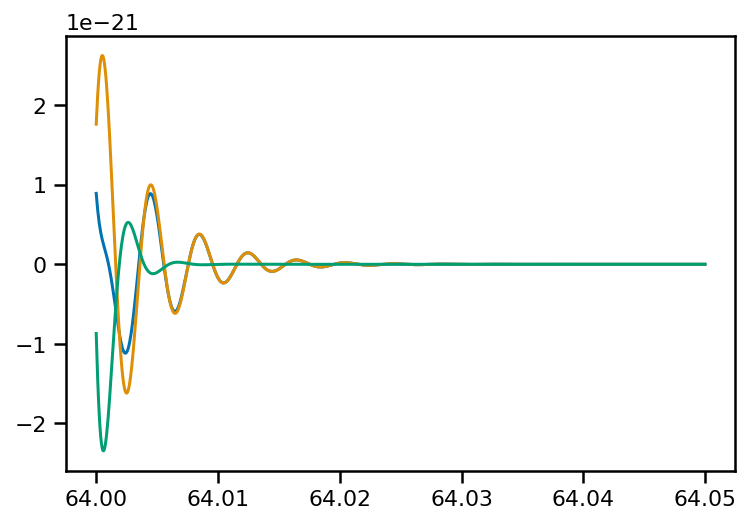

In [89]:
signal[64:64+0.05].plot()
signal1[64:64+0.05].plot()
signal2[64:64+0.05].plot()

In [146]:
ds_list = [1,4,8,16] # amounts we will downsample by in each analysis

duration = 128 #s
psd_scale = 1.5e-45
sample_rate = 2**14
noise_td  = generate_noise(scale=psd_scale, lalpsd = True)
times = noise_td.index
draws = 2000 #number of samples per chain

qnm1 = ringdown.qnms.get_ftau(68,0.69,0,2,2) # GW150914
qnm2 = ringdown.qnms.get_ftau(68,0.69,1,2,2)
f_qnm = [qnm1[0],qnm2[0]] # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = [3e-21*1.5,4e-21*1.5]
#A = [3e-21*3,3e-21/7*3]
tau_qnm = [qnm1[1],qnm2[1]]
#phase_qnm = 5.34 # radians
phase_qnm = [5.34, 1.79]

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2
dur = 0.05

for ds in ds_list:
    
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, scale=psd_scale, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()

    print(ds,np.sqrt(np.sum(np.square(acf_analysis.whiten(signal[64:64+0.05][::ds])))))

1 20.775482459487485
4 21.16067077520116
8 21.971749547981297
16 23.373928727461042


In [477]:
fit_dict_fundamental = {}
ds_list = [1,4,8,16] # amounts we will downsample by in each analysis
ds_list = [4]

duration = 128 #s
psd_scale = 1.5e-45
sample_rate = 2**14
noise_td  = generate_noise(scale=psd_scale, lalpsd = True)
times = noise_td.index
draws = 2000 #number of samples per chain

qnm1 = ringdown.qnms.get_ftau(68,0.69,0,2,2) # GW150914
qnm2 = ringdown.qnms.get_ftau(68,0.69,1,2,2)
f_qnm = [qnm1[0],qnm2[0]] # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = [3e-21*1.5,4e-21*1.5]
#A = [3e-21*3,3e-21/7*3]
tau_qnm = [qnm1[1],qnm2[1]]
#phase_qnm = 5.34 # radians
phase_qnm = [5.34, 1.79]

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2
dur = 0.05

for ds in ds_list:
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, scale=psd_scale, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()
    analysis_data = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0),(1,-2,2,2,1)])
    
    
    incr = 0
    running = False
    while not running:
        data_dur = dur+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*max(A), M_min=35.0, M_max=140.0, perturb_f = [0,1], perturb_tau = [0,1])
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            print(len(fit.data[None]))
            print(len(fit.acfs[None]))
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    fit.run(draws = draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_TGR_NOnoise_LIGOPSD_fundamental_ds{k}_dur{d}s_A1{a1}_f1{f1}_ph1{p1}_tau1{t1}_A2{a2}_f2{f2}_ph2{p2}_tau2{t2}.nc".format(
        k=k,d=str(dur).replace(".","p"),a1=str(A[0]).replace(".","p"),f1=str(f_qnm[0]).replace(".","p"),p1=str(phase_qnm[0]).replace(".","p"),t1=str(tau_qnm[0]).replace(".","p"),
        a2=str(A[1]).replace(".","p"),f2=str(f_qnm[1]).replace(".","p"),p2=str(phase_qnm[1]).replace(".","p"),t2=str(tau_qnm[1]).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

Analysis segment duration = 0.05
Running with downsampling 4


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 366 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 366 seconds.


4
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_TGR_NOnoise_LIGOPSD_fundamental_ds4_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc


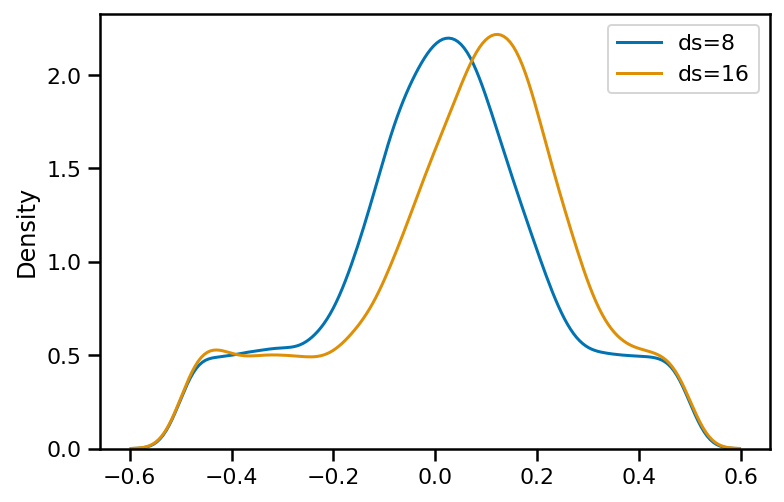

In [148]:
#sns.kdeplot(fit_dict_fundamental[1].result.posterior.df.values.flatten())
#sns.kdeplot(fit_dict_fundamental[4].result.posterior.df.values.flatten())
sns.kdeplot(fit_dict_fundamental[8].result.posterior.df.values.flatten(),label="ds=8")
sns.kdeplot(fit_dict_fundamental[16].result.posterior.df.values.flatten(),label="ds=16")
plt.legend()

# Phase Effects in Frequency Domain

ds = 1
ds = 1
ds = 1


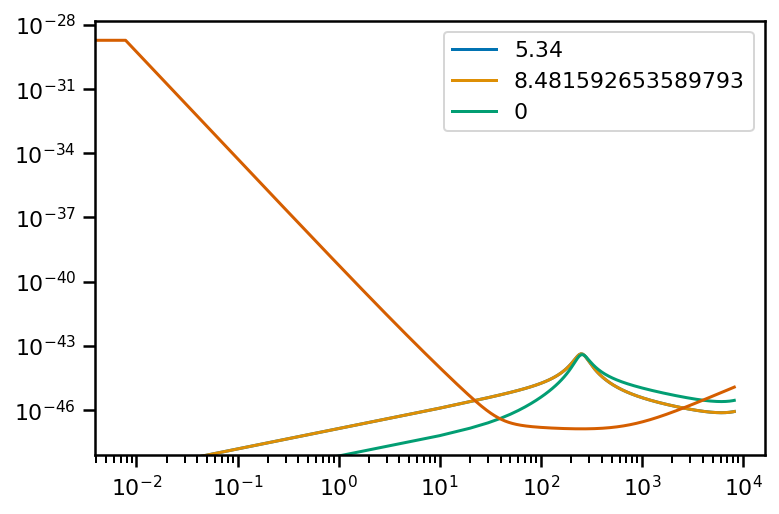

In [32]:
#generating things to plot

snrsq_dict = {}

sample_rate = 2**14
t0 = 128/2
noise_td,psd  = generate_noise(lalpsd = True, sr = sample_rate,rtrn_psd=True)
times = noise_td.index
dur = 0.1
ds=1

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3

for ph in [5.34,5.34+np.pi,0]:
    print("ds =",ds)
    signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=ph, times=times[int(len(times)/2):])
    signal_FT = np.fft.rfft(signal[t0:t0+dur].values)/sample_rate*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    delta_t = 1/sample_rate
    freqs_analysis = np.fft.rfftfreq(len(noise_td[t0:t0+dur]), delta_t)

    sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)
    plt.loglog(sig_power,label = ph)

signal_FT = np.fft.rfft(signal[t0:t0+dur].values)/sample_rate*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/sample_rate
freqs_analysis = np.fft.rfftfreq(len(noise_td[t0:t0+dur]), delta_t)

sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)

plt.loglog(psd)
plt.legend()

# Time Domain Waveform

In [ ]:
fig = plt.figure(figsize=[10,10])
quantile = .9

f_qnm = 245 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 4e-21
tau_qnm = 1.4e-3
phase_qnm = 5.34 # radians
signal1 = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal2 = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

signal = signal1+signal2

colors = sns.color_palette("colorblind")
cnt = 0
for k,f in results_dict.items():
    if k in [2,8]:
        continue
    
    #plot_fs = np.fft.rfftfreq(f.result.posterior.h_det[0][0][0].values.shape[-1])*sample_rate/k
    plot_ts = f.posterior.h_det[0][0][0].time_index.values*k/2**14
        
    signal_td_list = []
    
    for i in np.arange(100):
        #sig_fit=f.result.posterior.h_det[0][i][0].values
        #signal_FT = np.fft.rfft(sig_fit)/sample_rate*k #0.5 for reflection
        signal_td_list.append(f.posterior.h_det[0][i][0])
    
    #plt.axvline((sample_rate/k)/2, label = "SR "+str(sample_rate/k),ls="-",color = colors[cnt],lw=4,alpha = 0.5)
    
    m = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5,axis = 0),index = plot_ts)
    u = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5-quantile/2,axis = 0),index = plot_ts)
    d = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5+quantile/2,axis = 0),index = plot_ts)

    up, = plt.plot(u,color=colors[cnt],alpha = 0.7,lw=2)
    dp, = plt.plot(d,color=colors[cnt],alpha = 0.7,lw=2,label = "SR "+"{:.0f}".format(sample_rate/k))
    #mp, = plt.plot(m,color=colors[cnt],alpha = 0.7)
    plt.fill_between(plot_ts,u,d,color=colors[cnt],alpha=0.15,zorder=-cnt)
    cnt+=1

    
plot_ts = signal[t0:t0+data_dur].index
plot_ts = plot_ts-plot_ts[0]
#plt.plot(plot_ts, signal[t0:t0+data_dur].values, label = "Injected Signal",ls = "--",lw=2.5,color="black",alpha=0.8)

#plt.yscale("log")
#plt.xscale("log")
plt.legend()
#plt.ylim(1e-46,5e-44)
plt.xlim(0,0.01)


plt.title("TD Strain")

# QNM Frequencies

In [95]:
ringdown.qnms.get_ftau(68,0.69,0,2,2) # GW150914

(251.0019955101922, 0.004126712034976183)

In [270]:
ringdown.qnms.get_ftau(255,0.7,0,2,2) # GW190521

(67.4888114476828, 0.015545928278894821)

# Paper Figures

In [14]:
#### PLOTTING DEFAULTS

#colormap
cmap = sns.color_palette("colorblind")

#start by setting rcParams to default
plt.rcParams.update(plt.rcParamsDefault)
sns.reset_defaults()

# make plots fit the LaTex column size but rescale them for ease of display
scale_factor = 2

# Get columnsize from LaTeX using \showthe\columnwidth
fig_width_pt = scale_factor*246.0
# Convert pts to inches
inches_per_pt = 1.0/72.27               
# Golden ratio
fig_ratio = (np.sqrt(5)-1.0)/2.0
fig_width = fig_width_pt*inches_per_pt
fig_height = fig_width*fig_ratio

figsize_column = (fig_width, fig_height)
figsize_square = (fig_width, fig_width)

fig_width_page = scale_factor*inches_per_pt*508.87
figsize_page = (fig_width_page, fig_height)

#plt.rcParams = {'figure.figsize': figsize_column}
plt.rcParams['figure.figsize'] = figsize_column

# LaTex text font sizse in points (rescaled as above)
fs = scale_factor*9
fs_label = 0.8*fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['legend.fontsize'] = fs
plt.rcParams["legend.title_fontsize"] = fs
plt.rcParams['xtick.labelsize'] = fs_label
plt.rcParams['ytick.labelsize'] = fs_label
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]
az.rcParams["plot.max_subplots"] = 200

#remove warning about the number of figures in the notebook, we're gonna obliterate any maximum
plt.rcParams.update({'figure.max_open_warning': 0})

#seaborn rcParams
sns.set_theme(rc=plt.rcParams)
sns.set_style("white")
sns.set_style("ticks")

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors, alpha):
        self.colors = colors
        self.alpha = alpha


# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(
                plt.Rectangle(
                    [
                        width / len(orig_handle.colors) * i - handlebox.xdescent,
                        -handlebox.ydescent,
                    ],
                    width / len(orig_handle.colors),
                    height*2.5,
                    facecolor=c,
                    edgecolor="white",
                    alpha=orig_handle.alpha,
                )
            )

        patch = PatchCollection(patches, match_original=True)

        handlebox.add_artist(patch)
        return patch
    

class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           linestyle=orig_handle[1], color='k')
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[0])
        return [l1, l2]

## LIGO PSD: GW150914

In [16]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

id_str = "dur0p05s_A3" # identify runs of interest

for f in [x for x in sorted(os.listdir(results_dir), key = lambda x: int(x.split("ds")[1].split("_")[0])) if id_str in x and "_NOnoise" in x and "ph5" in x and "spike" not in x]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = float(f.split("A")[1].split("_")[0].replace("p","."))
f_qnm = float(f.split("f")[2].split("_")[0].replace("p","."))
tau_qnm = float(f.split("tau")[1].split(".")[0].replace("p","."))
phase_qnm = float(f.split("ph")[1].split("_")[0].replace("p","."))
dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

print(A,f_qnm,tau_qnm,phase_qnm, dur)

GW150914_NOnoise_LIGOPSD_fundamental_ds1_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds4_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds8_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds16_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds32_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
3e-21 250.0 0.004 5.34 0.05


In [407]:
sig_cond = ringdown.Data(signal).condition(flow=10,ds=8)

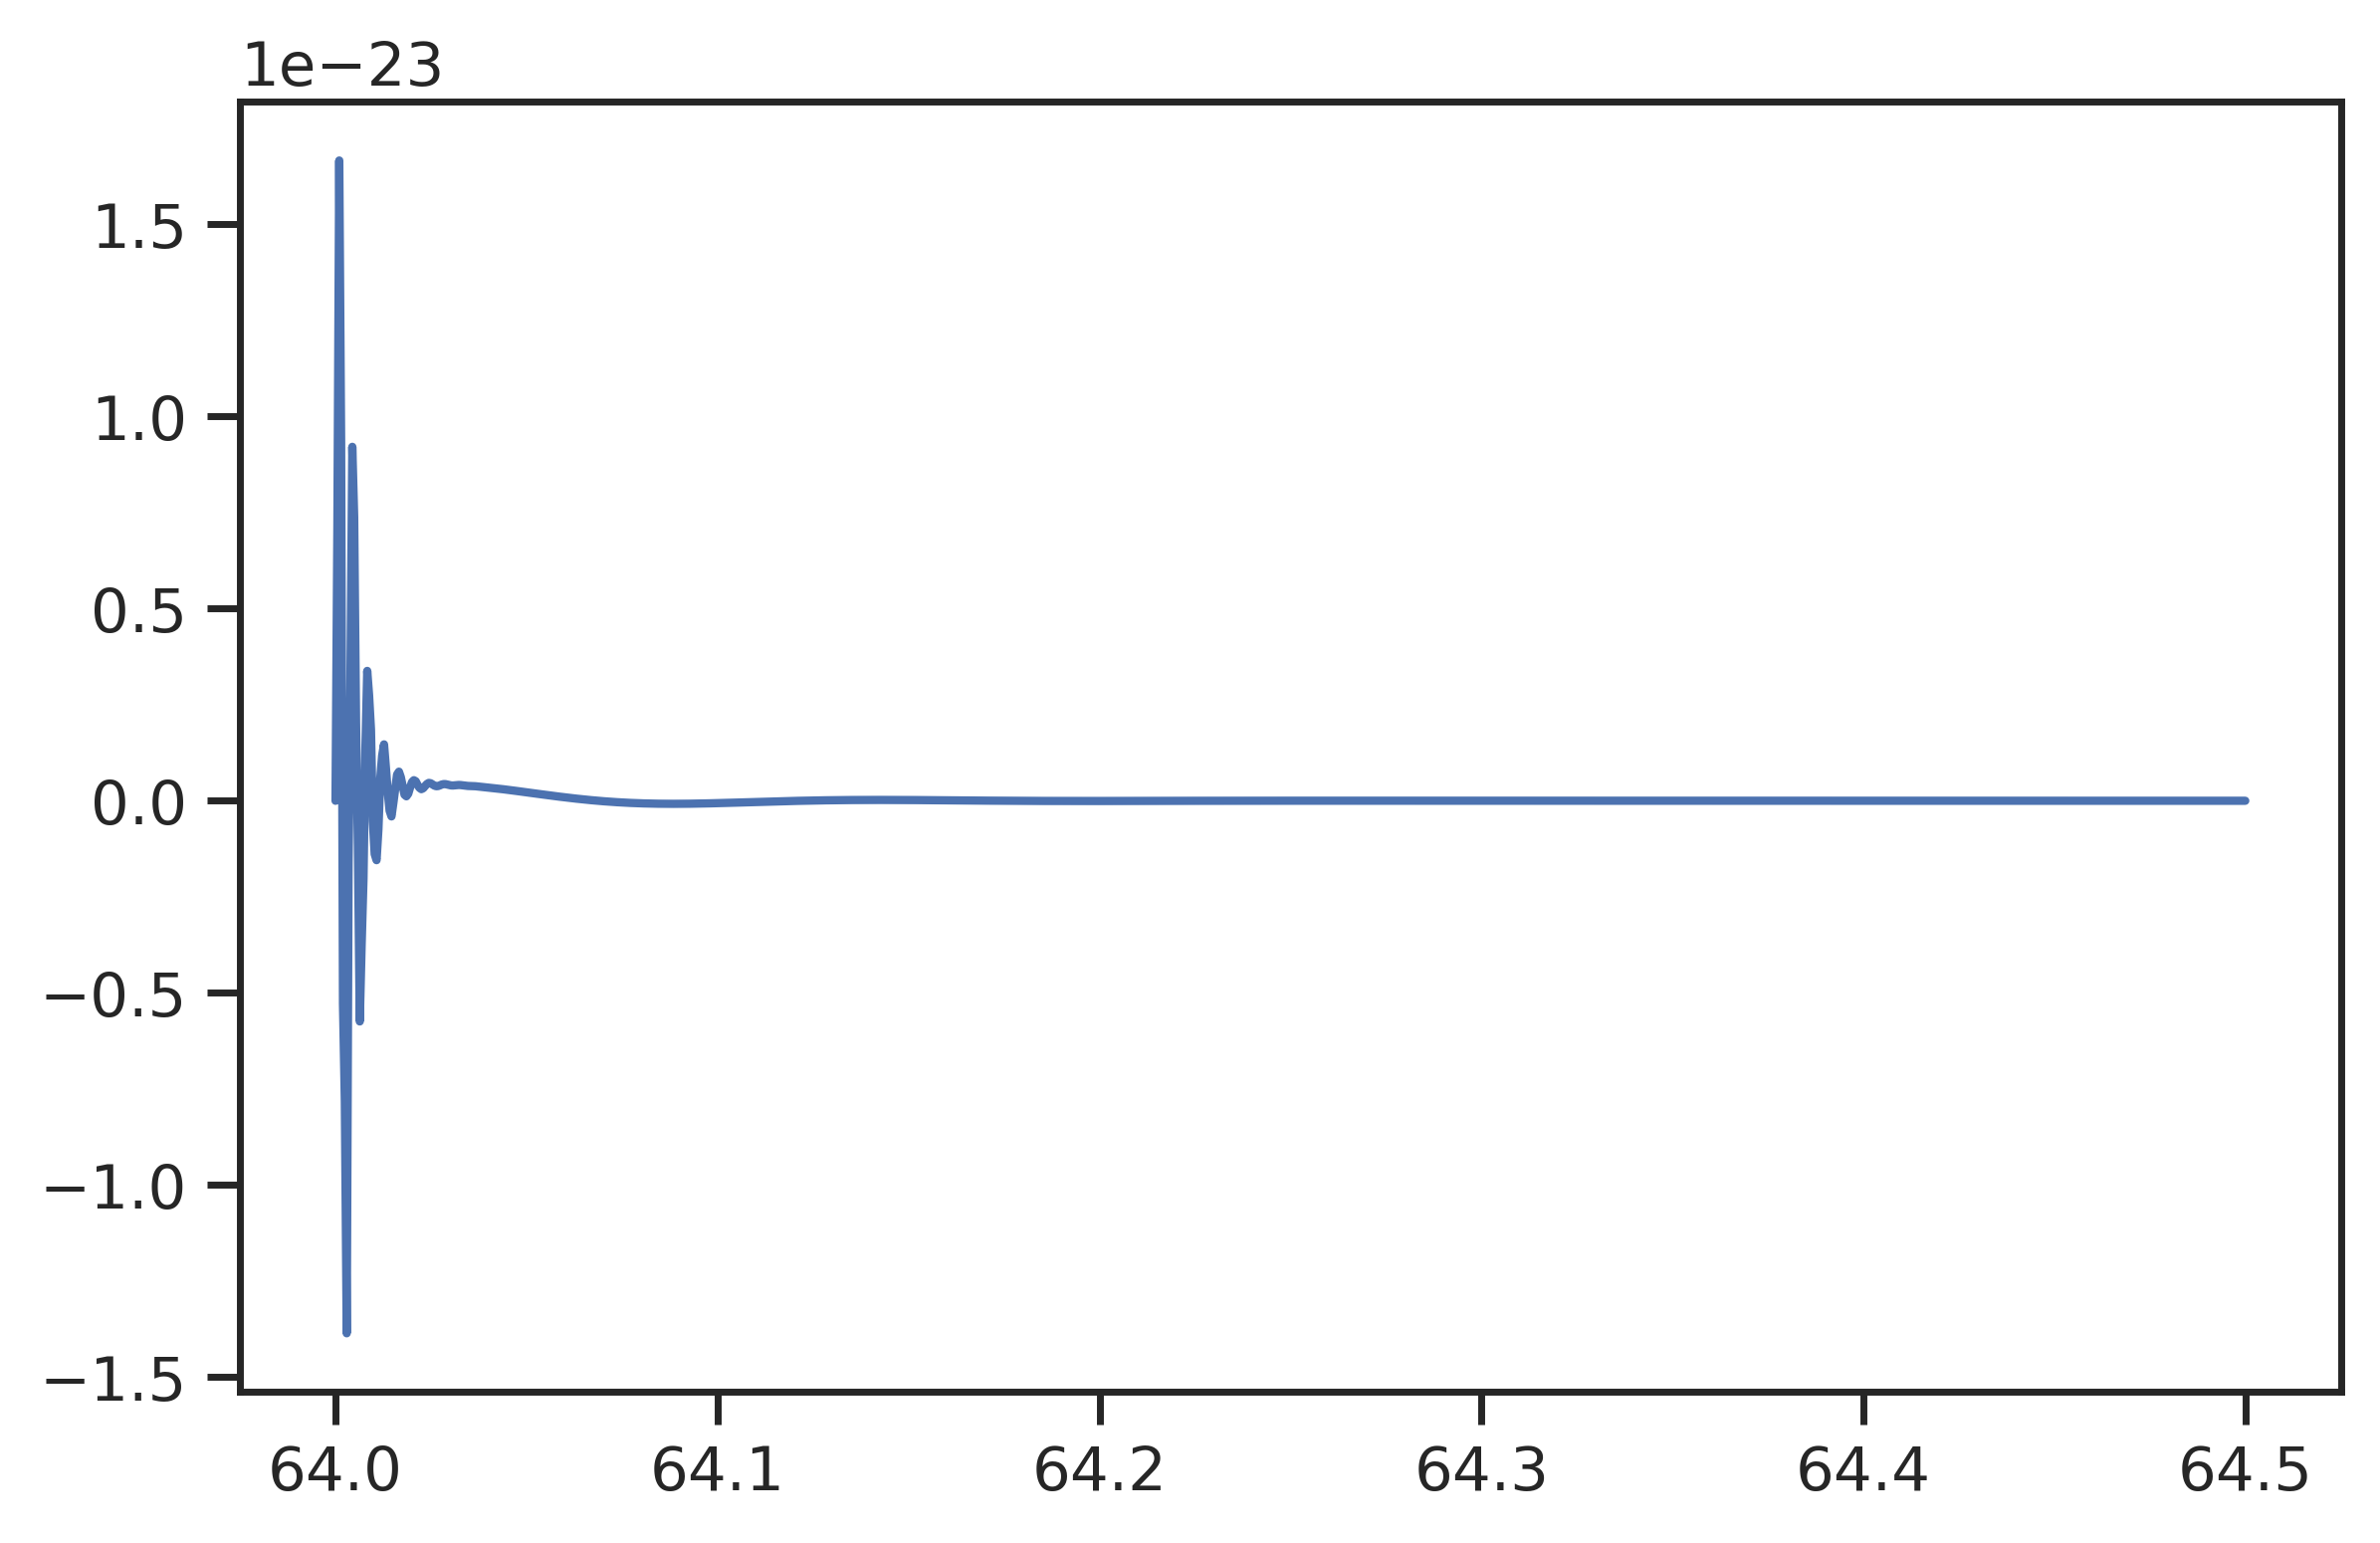

In [408]:
plt.plot(sig_cond[64:64+0.5]-signal[64:64+0.5][::8])

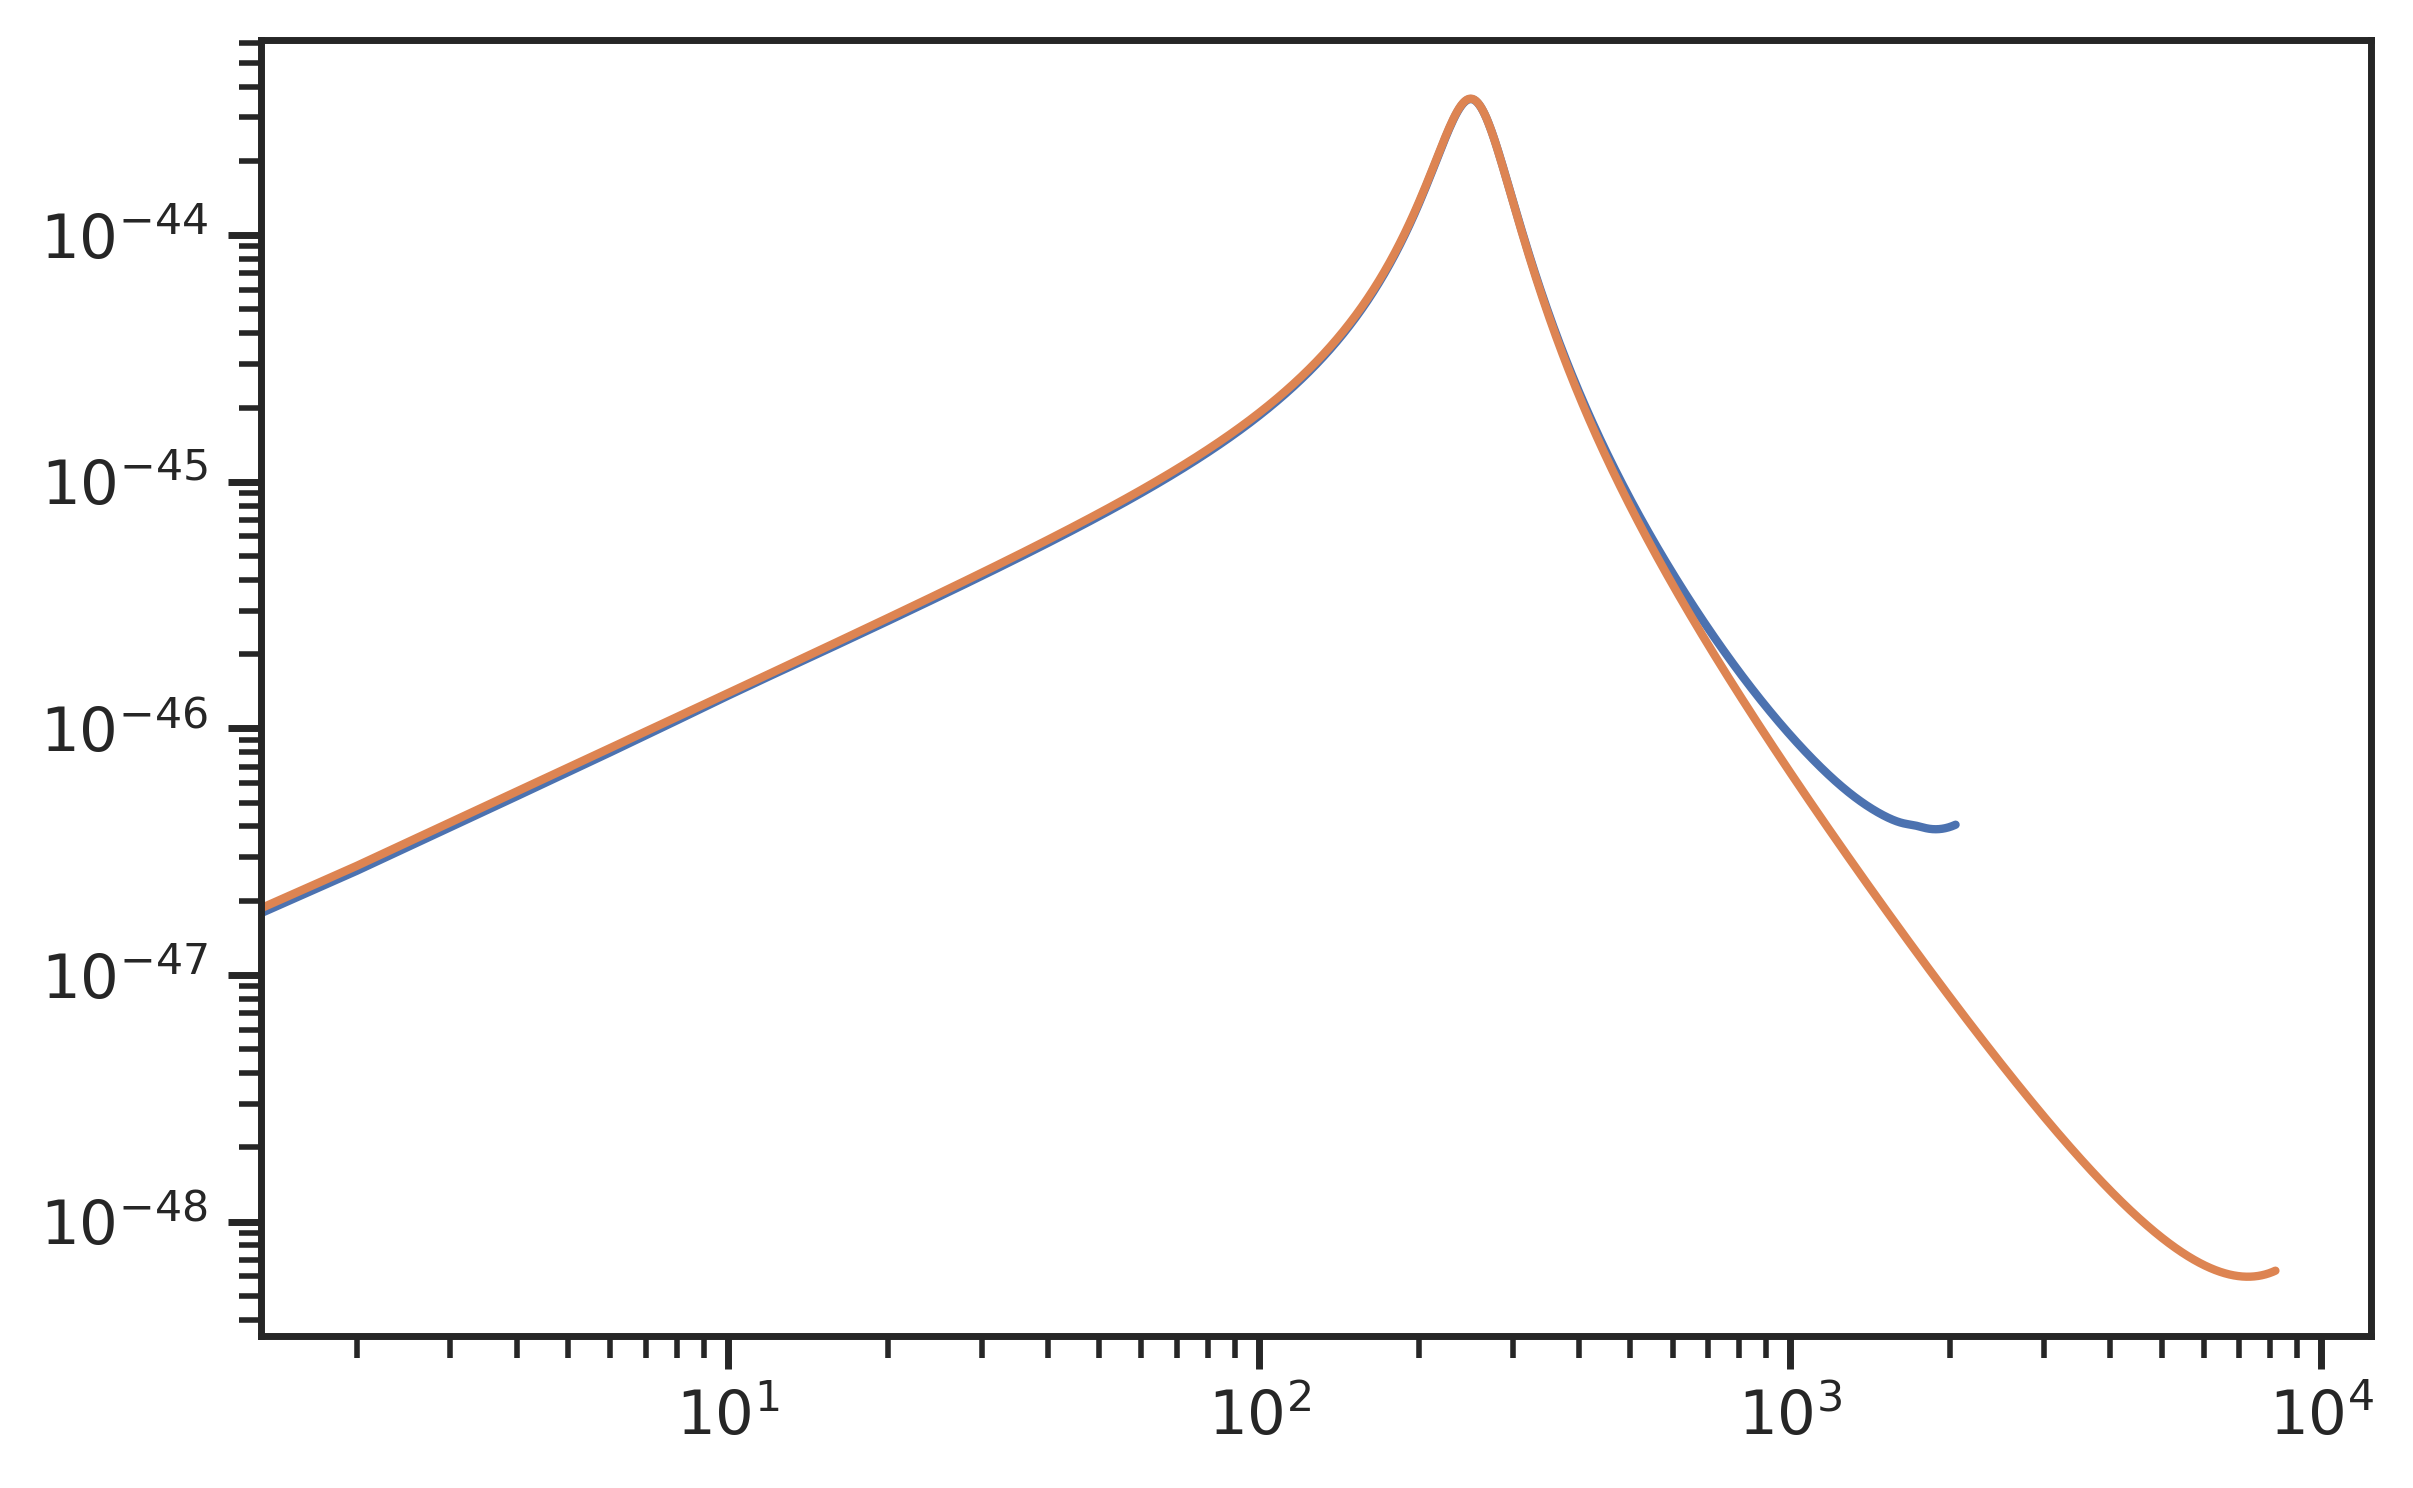

In [426]:
ds=4
sig_cond = ringdown.Data(signal).condition(flow=10,fhigh=2**13/ds,ds=ds)
signal_FT2 = np.fft.rfft(sig_cond[64:64+dur].values)/(2**14/(ds))*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/2**14*ds
freqs_analysis = np.fft.rfftfreq(len(sig_cond[64:64+dur]), delta_t)

sig_power2 = ringdown.FrequencySeries(freqs_analysis*(signal_FT2.real**2+signal_FT2.imag**2),freqs_analysis)
plt.loglog(sig_power2)
plt.loglog(sig_power)

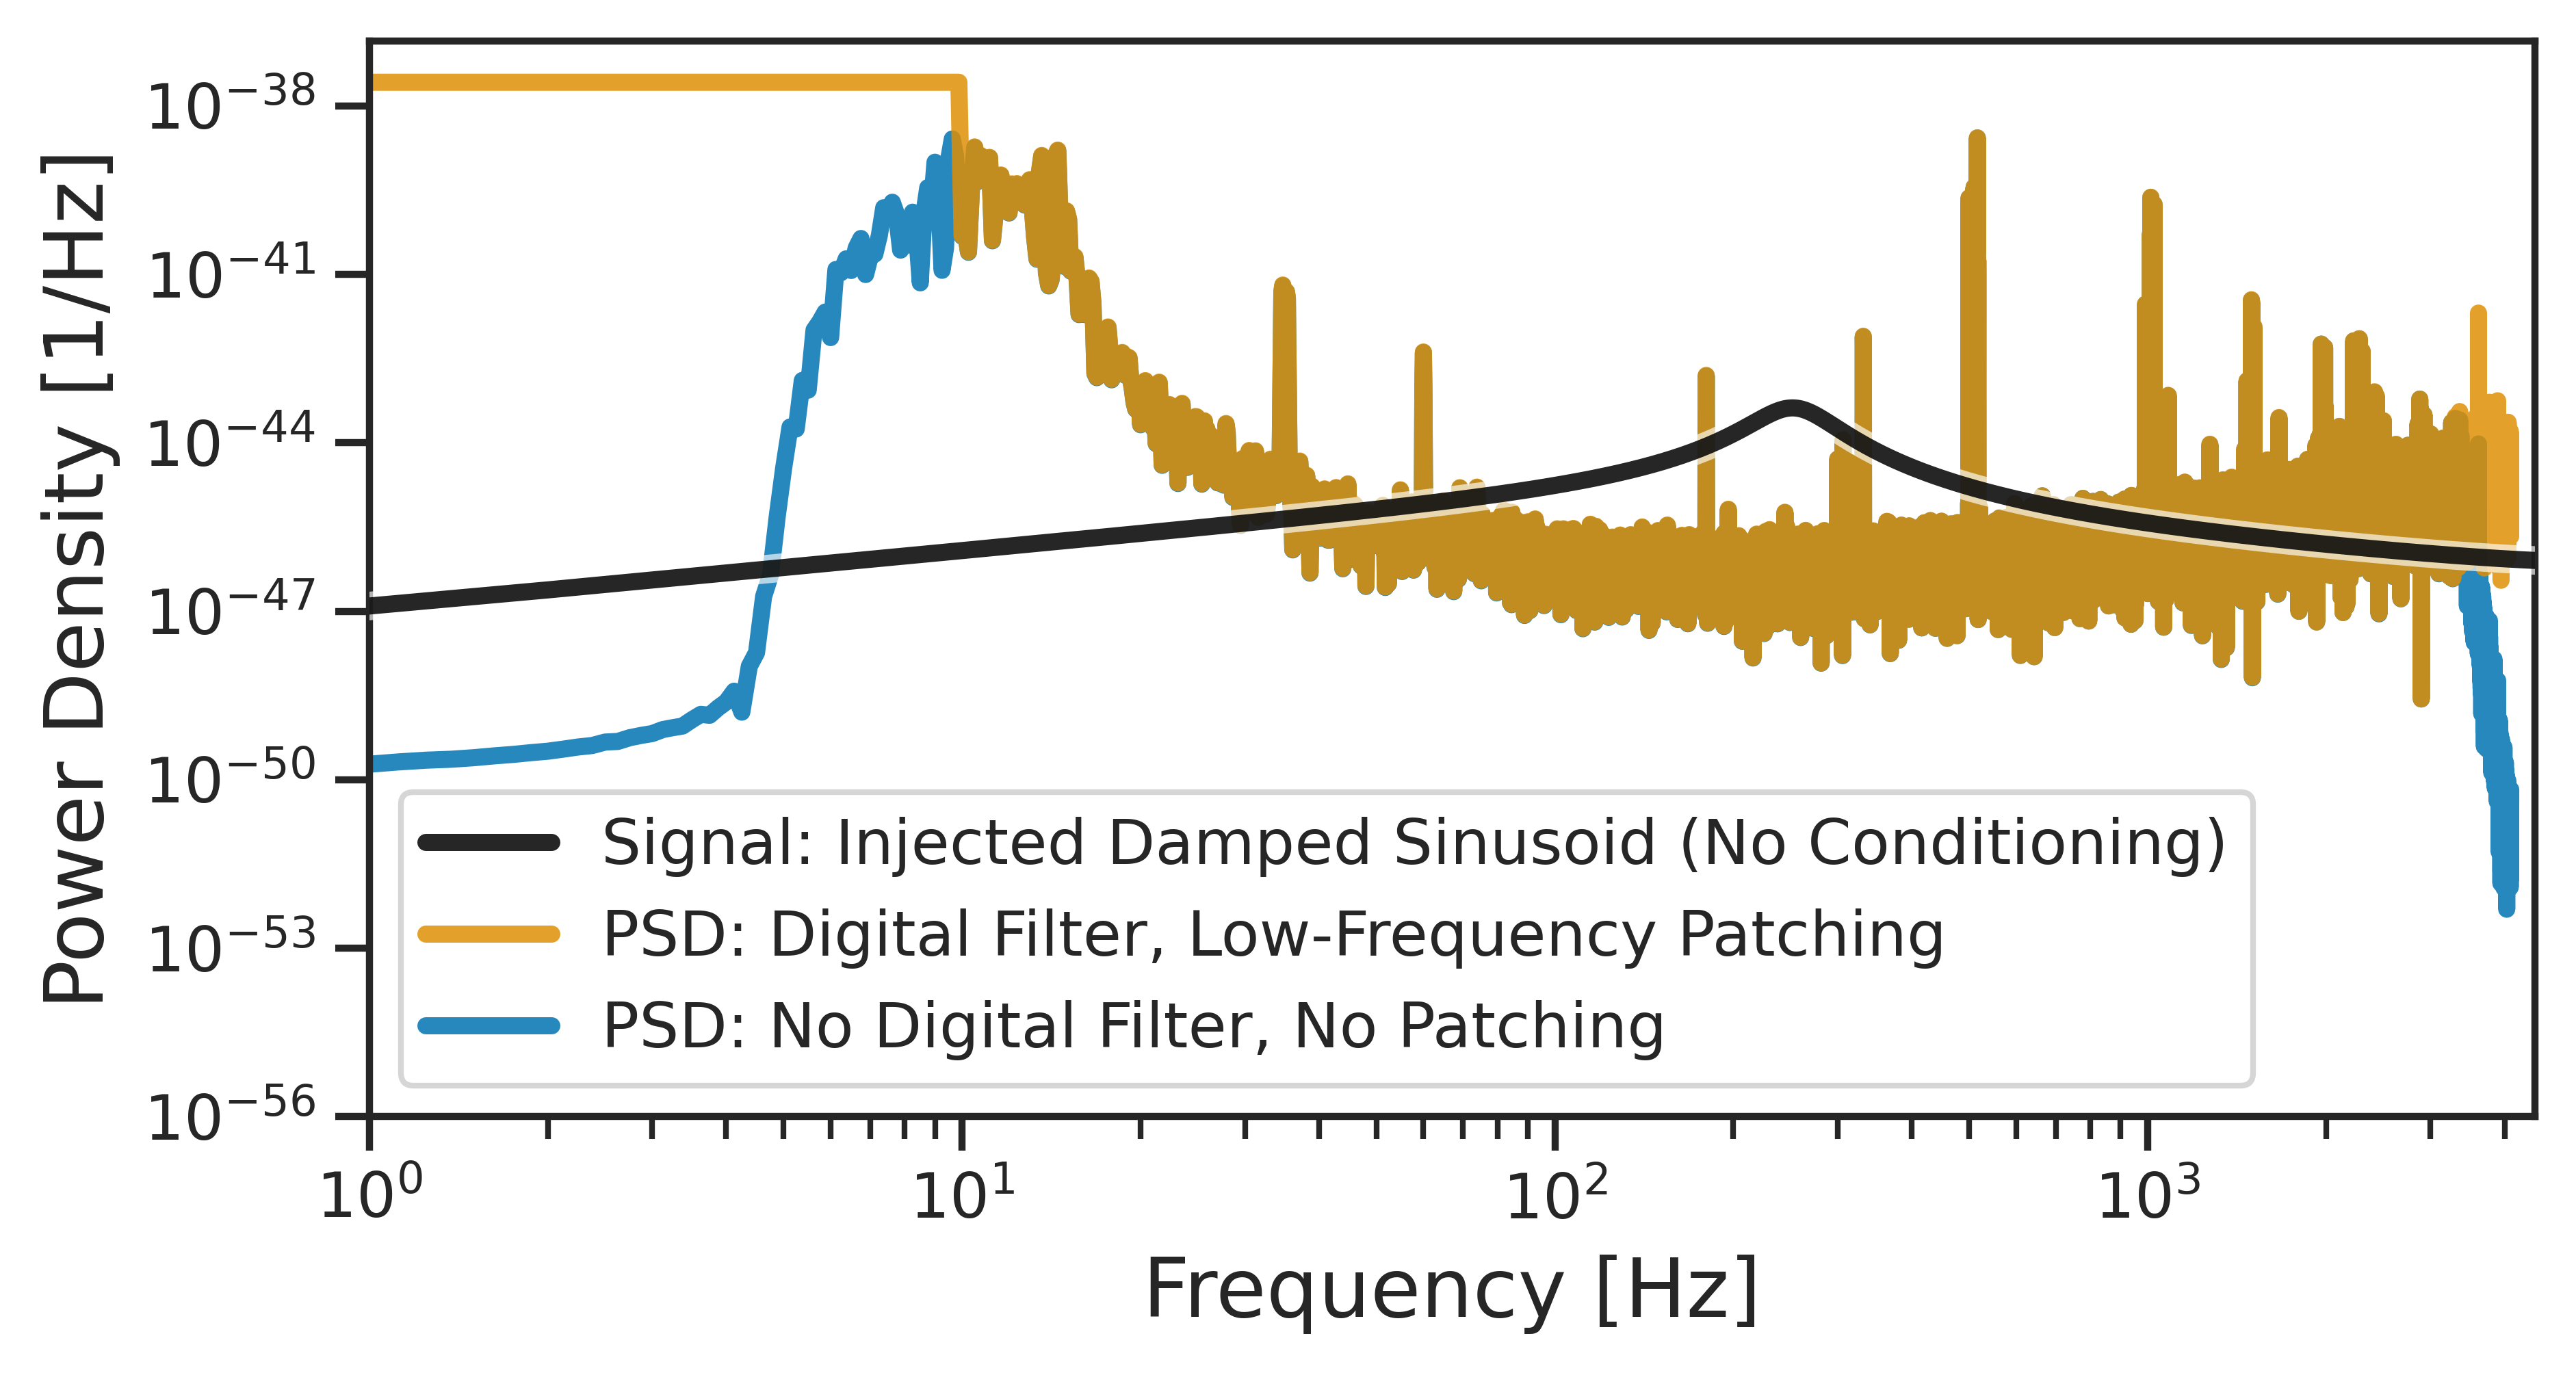

In [434]:
fig, ax = plt.subplots(1,1,figsize=[figsize_square[0],figsize_square[1]/2],dpi=300)

#t0 = 1242442967.4085817 # GW190521
t0 = 1126259462.423 # GW150914
ra = 5.749613171792332
dec = -0.4237903906862163
psi = 1.222853265910277
T = 0.4
ds=2
slice_dur = 256
alpha = 0.85

A = 3e-21 
f_qnm = 250.0
tau_qnm = 0.004
phas_qnm = 5.34 
dur = 0.5

lw = 3

cmap = sns.color_palette("colorblind")

noise_td = generate_noise()
times = noise_td.index

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

signal_FT = np.fft.rfft(signal[64:64+dur].values)/(2**14)*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/2**14
freqs_analysis = np.fft.rfftfreq(len(noise_td[64:64+dur]), delta_t)

sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)

plt.loglog(sig_power, color = "black", alpha = alpha,zorder = 10, label="Signal: Injected Damped Sinusoid (No Conditioning)",lw=lw,path_effects=[patheff.Stroke(linewidth=5, foreground='w',alpha=0.65), patheff.Normal()])

#Patching, digital filter
fit = ringdown.Fit(model="mchi")
fit.load_data({"L1":"/mnt/home/hsiegel/ceph/database_rd/GW150914_095045/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5"},kind="GWOSC")
fit.set_target(t0=t0, ra=ra, dec=dec, psi=psi, duration=T)
fit.condition_data(flow=1/0.1,ds=ds,digital_filter=True,slice_left=slice_dur,slice_right=slice_dur)
nperseg = np2(16*fit.duration*(2**14)/ds)
fit.compute_acfs(method='fd', nperseg=nperseg,flow=1/0.1) # flattened PSD
psd_digfilt = fit.acfs["L1"].to_psd()
plt.loglog(psd_digfilt,alpha=alpha, color = cmap[1], label = "PSD: Digital Filter, Low-Frequency Patching",lw=lw,zorder=0)

#No patch, no digital filter
fit = ringdown.Fit(model="mchi")
fit.load_data({"L1":"/mnt/home/hsiegel/ceph/database_rd/GW150914_095045/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5"},kind="GWOSC")
fit.set_target(t0=t0, ra=ra, dec=dec, psi=psi, duration=T)
fit.condition_data(flow=1/0.1,ds=ds,digital_filter=False,slice_left=slice_dur,slice_right=slice_dur)
nperseg = np2(16*fit.duration*(2**14)/ds)
fit.compute_acfs(method='fd', nperseg=nperseg) # flattened PSD
psd = fit.acfs["L1"].to_psd()
plt.loglog(psd,alpha=alpha, color = cmap[0], label = "PSD: No Digital Filter, No Patching",lw=lw,zorder=-5)

#signal2 = ringdown.Data(signal).condition(t0=64,flow=10,fhigh=2**14/(2*2),ds=2)

#signal_FT2 = np.fft.rfft(signal2[64:64+dur].values)/(2**14)*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
#delta_t = 1/2**14
#freqs_analysis = np.fft.rfftfreq(len(noise_td[64:64+dur]), delta_t)

#sig_power2 = ringdown.FrequencySeries(freqs_analysis[::2]*(signal_FT2.real**2+signal_FT2.imag**2),freqs_analysis[0:int(len(freqs_analysis)/2)+1])

#plt.plot(sig_power2, color = "grey", alpha = alpha,zorder = 10, label="Signal: Injected Damped Sinusoid (Filtered)",lw=lw,path_effects=[patheff.Stroke(linewidth=5, foreground='w',alpha=0.65), patheff.Normal()])

ax.set_xlabel('Frequency [Hz]', fontsize = fs_label)
ax.set_ylabel("Power Density [1/Hz]", fontsize = fs_label)

ax.set_xlim(1,2**14/(2*ds)*1.1)
ax.set_ylim(1e-56,ax.get_ylim()[1])

plt.legend()
plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/GW150914_PSD",bbox_inches="tight")

## Downsampling

### Noise

In [63]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

id_str = "dur0p05s_A1" # identify runs of interest

for f in [x for x in sorted(os.listdir(results_dir), key = lambda x: int(x.split("ds")[1].split("_")[0])) if id_str in x and "_noise" in x and "ph5" in x and "spike" not in x]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = float(f.split("A")[1].split("_")[0].replace("p","."))
f_qnm = float(f.split("f")[2].split("_")[0].replace("p","."))
tau_qnm = float(f.split("tau")[1].split(".")[0].replace("p","."))
phase_qnm = float(f.split("ph")[1].split("_")[0].replace("p","."))
dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

print(A,f_qnm,tau_qnm,phase_qnm, dur)

GW150914_noise_LIGOPSD_fundamental_ds1_dur0p05s_A1p5e-21_f250_ph5p34_tau0p004.nc
GW150914_noise_LIGOPSD_fundamental_ds4_dur0p05s_A1p5e-21_f250_ph5p34_tau0p004.nc
GW150914_noise_LIGOPSD_fundamental_ds8_dur0p05s_A1p5e-21_f250_ph5p34_tau0p004.nc
GW150914_noise_LIGOPSD_fundamental_ds16_dur0p05s_A1p5e-21_f250_ph5p34_tau0p004.nc
GW150914_noise_LIGOPSD_fundamental_ds32_dur0p05s_A1p5e-21_f250_ph5p34_tau0p004.nc
1.5e-21 250.0 0.004 5.34 0.05


In [ ]:
#generating things to plot

snrsq_dict = {}

sample_rate = 2**14
t0 = 128/2
noise_td  = generate_noise(lalpsd = True, sr = sample_rate)
times = noise_td.index
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

c_count=0

for ds in results_dict.keys():
    print("ds =",ds)
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()
   # analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    
    whtnd_sig = acf_analysis[0:dur].whiten(signal[t0:t0+dur][::ds])
    whtnd_data = acf_analysis[0:dur].whiten(results_dict[ds].observed_data.strain_None)
        
    ss = np.sum(np.square(whtnd_sig))
    #sd = np.sum(whtnd_sig*whtnd_data)
    dd = np.sum(np.square(whtnd_data))
    print(dd)
    snrsq_dict[ds]=ss
    
    plt.plot(np.arange(0,len(whtnd_sig))*ds,whtnd_sig,c=cmap[c_count],alpha=0.8,label="<s|s>={:.2f}".format(ss))
    c_count+=1

print(snrsq_dict)

plt.legend()

noise_td2, psd = generate_noise(sr=sample_rate, rtrn_psd=True, lalpsd = True)

signal_FT = np.fft.rfft(signal[t0:t0+dur].values)/sample_rate*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/sample_rate
freqs_analysis = np.fft.rfftfreq(len(noise_td2[t0:t0+dur]), delta_t)

sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)

ds_max = max(results_dict.keys())

Nyq = 8192.0
Nyq = 2048.0
Nyq = 1024.0
Nyq = 512.0
Nyq = 256.0
1 4.2354649089122685


/tmp/ipykernel_1669463/3278578867.py:65: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_1669463/3278578867.py:65: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_1669463/3278578867.py:65: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_1669463/3278578867.py:65: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

4 3.8860213852392174
8 3.6508194881947666
16 3.4709355732652916
32 5.226981144782407
1 4.2354649089122685
4 3.8860213852392174
8 3.6508194881947666
16 3.4709355732652916
32 5.226981144782407


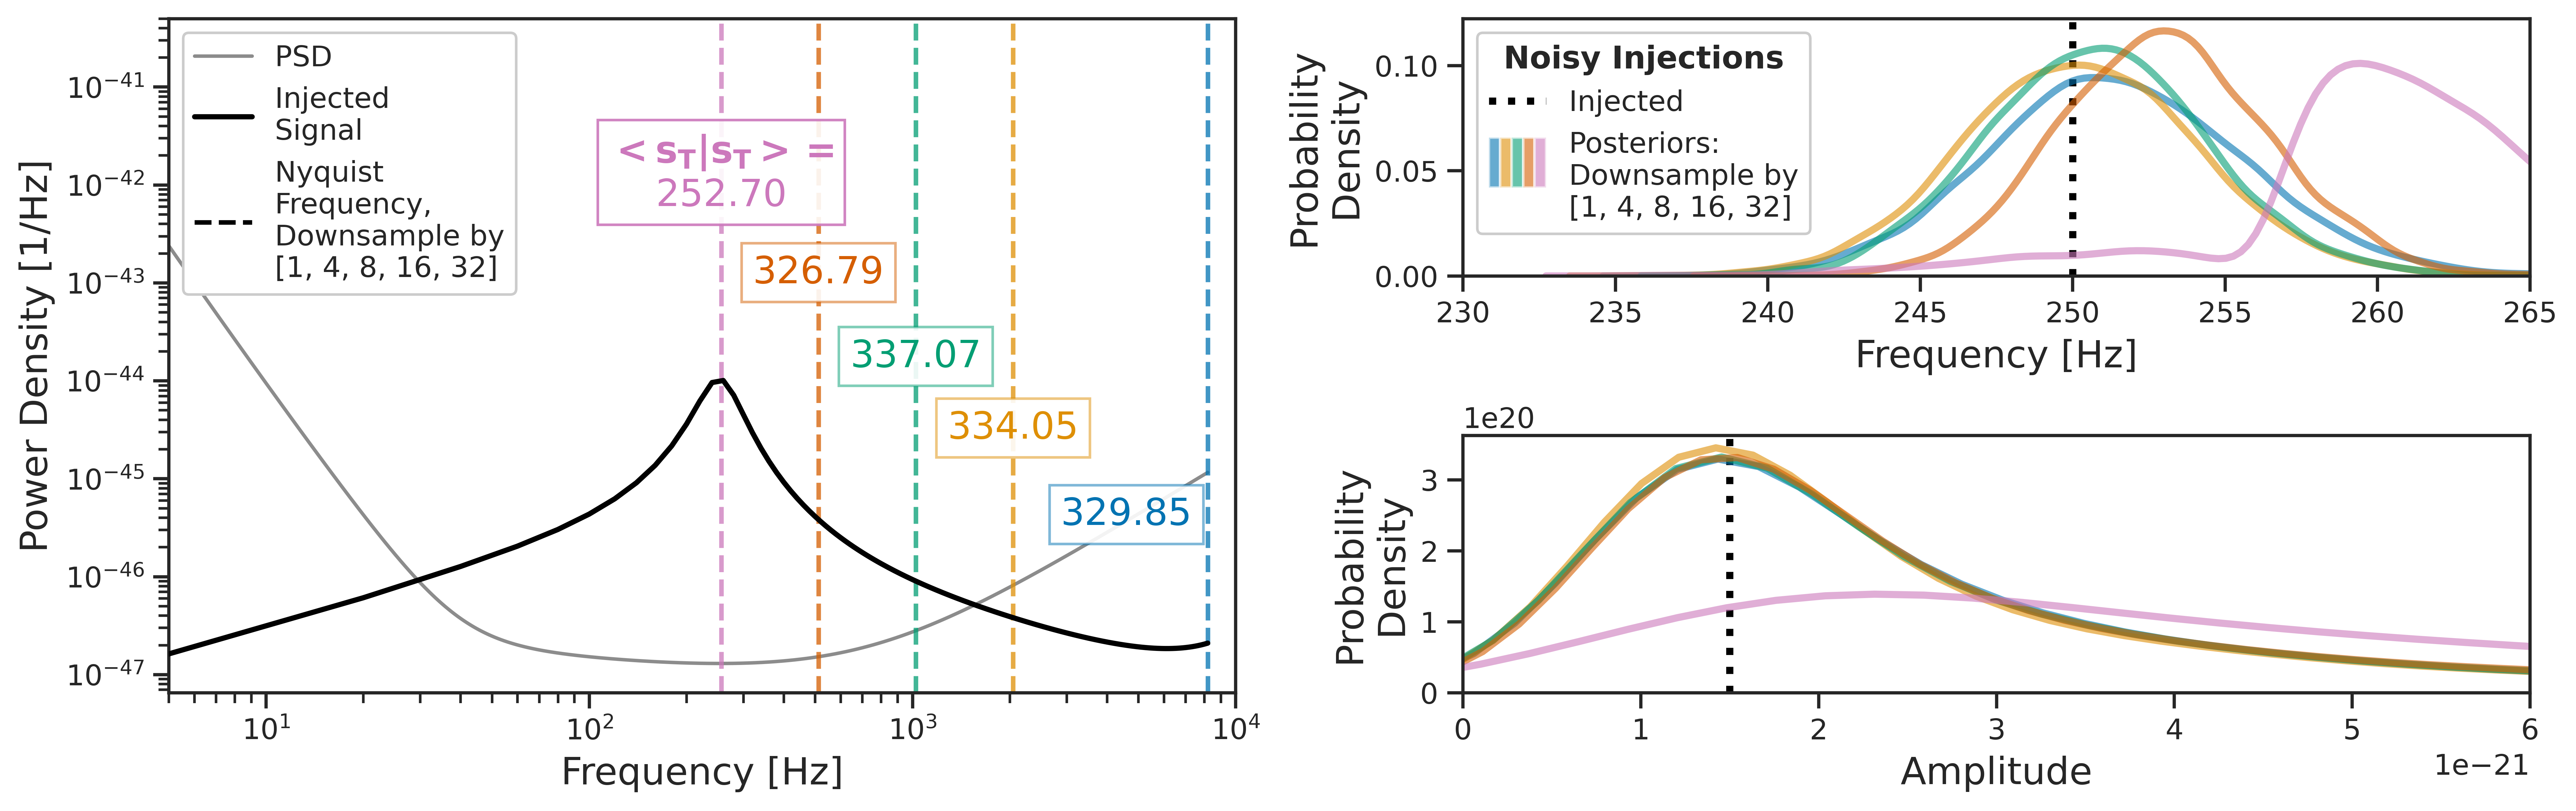

In [65]:
#plotting
fig = plt.figure(constrained_layout=True, dpi = 300, figsize = (fig_width*2,fig_height))
gs_plot = gs(2, 2, figure=fig)

ax = []
ax1 = fig.add_subplot(gs_plot[:, 0])
ax2 = fig.add_subplot(gs_plot[0, 1])
ax3 = fig.add_subplot(gs_plot[1, 1])
ax.append(ax1)
ax.append(ax2)
ax.append(ax3)

cmap = sns.color_palette("colorblind")

small_lw = 2
med_lw = 2.75
big_lw = 3.5

#Plotting for ax[0]
delta_t = 1/sample_rate

ax[0].plot(psd.index, psd.values, label = "PSD", color = "grey", lw = small_lw*2/3, ls = "-", zorder = -100, alpha = 0.9)
        
ax[0].plot(sig_power, color = "black", label="Injected\nSignal", lw=small_lw, zorder = 100)

ax[0].set_ylim(min(psd)*0.5, 5e-41)
ax[0].set_xlim(5,10**4)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xlabel('Frequency [Hz]',fontsize = fs_label)
ax[0].set_ylabel("Power Density [1/Hz]", fontsize = fs_label)
    
c_count = 0
lw = 1.75
lst = "--"
alpha = 0.75

#ann_slope = -3.2 #slope for producing straight lines on loglog plot
#b = np.log(5e-47)-ann_slope*np.log(8192) #y intercept for producing straight lines on loglog plot

ds_str = "["
for x in results_dict.keys():
    ds_str+=r"{}".format(x)+", "
ds_str = ds_str[:-2]+"]"

for k,v in results_dict.items():
    nyq_freq = sample_rate/(2*k)
    print("Nyq =",nyq_freq)
    
    if k == 1:
        ax[0].axvline(0,label = "Nyquist\nFrequency,\nDownsample by\n{}".format(ds_str),lw = lw, ls = lst, color= "black")

    ax[0].axvline(nyq_freq, ls=lst,color=cmap[c_count],lw = lw, alpha = alpha)
        
    if k==1:
        ann_offset_x = -3600
    else:
        ann_offset_x = 0
    
    x=nyq_freq+ann_offset_x
    #y=np.exp(np.log(x)*ann_slope)*np.exp(b) # produce straight lines on a loglog plot
    y_offset = (c_count+1)**2
    if k ==ds_max:
        y_offset = y_offset/7
    y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
    
    if k==ds_max:
        ax[0].annotate(r'$\bf{<s_T|s_T>=}$' + '\n' + "{:.2f}".format(snrsq_dict[k]),xy=[x,y],fontsize=fs_label, color=cmap[c_count],ha="center", bbox=dict(fc=clrs.to_rgba("white")[:-1] + (0.9,),ec=clrs.to_rgba(cmap[c_count])[:-1]+(0.9,),boxstyle="square"),zorder = -k+100)
    else:
        ax[0].annotate("{:.2f}".format(snrsq_dict[k]),xy=[x,y],fontsize=fs_label, color=cmap[c_count],ha="center", bbox=dict(fc=clrs.to_rgba("white")[:-1] + (0.9,),ec=clrs.to_rgba(cmap[c_count])[:-1]+(0.5,) ,boxstyle="square"),zorder = -k+100)
    c_count +=1


ax[0].legend(loc="upper left", framealpha=1)
    
#Plotting for ax[1]

kde_dict = {}
ax[1].axvline(250, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    #if k == ds_max:
    #    alpha = 0.95
    #    lw = big_lw+1
    sns.kdeplot(v.posterior.f.values.flatten(), linewidth=lw, alpha = alpha, ax = ax[1],color=cmap[c_count])
    print(k, np.std(v.posterior.f.values.flatten()))
    c_count +=1
        
ax[1].set_xlim(f_qnm-20,f_qnm+15)

h, l = ax[1].get_legend_handles_labels()
h.append(MulticolorPatch(cmap[0:len(results_dict)],alpha))
l.append("Posteriors:\nDownsample by\n{}".format(ds_str))
ax[1].legend(
    h,
    l,
    loc="upper left",
    handler_map={MulticolorPatch: MulticolorPatchHandler()},
    frameon=True,
    framealpha=1, 
    title = "Noisy Injections",
    title_fontproperties={'weight':'bold'}
)


#ax[1].legend(loc = "upper left")
#ax[1].set_xlabel(r'$f$'+' [Hz]',fontsize = fs_label)
ax[1].set_ylabel("Probability\nDensity",fontsize = fs_label)
ax[1].set_xlabel('Frequency [Hz]',fontsize = fs_label)
ann_box_offset_x = 0.810
ann_box_offset_y = 0.775
#ax[1].annotate("Injections in Noise", xy=[ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])*ann_box_offset_x, ax[1].get_ylim()[0]+(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))


#Plotting for ax[2]

kde_dict = {}
ax[2].axvline(A, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    #if k == ds_max:
    #    alpha = 0.95
    #    lw = big_lw+1
    sns.kdeplot(v.posterior.A.values.flatten(), linewidth=lw, alpha = alpha, ax = ax[2],color=cmap[c_count])
    print(k, np.std(v.posterior.f.values.flatten()))
    c_count +=1
        
#ax[2].set_xlim(f_qnm-15,f_qnm+15)

#ax[1].legend(loc = "upper left")
ax[2].set_xlim(0,4*A)
ax[2].set_xlabel("Amplitude",fontsize = fs_label)
ax[2].set_ylabel("Probability\nDensity",fontsize = fs_label)



plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/downsample_bias",bbox_inches="tight")

### No noise

In [24]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

id_str = "dur0p05s_A3" # identify runs of interest

for f in [x for x in sorted(os.listdir(results_dir), key = lambda x: int(x.split("ds")[1].split("_")[0])) if id_str in x and "_noise" not in x and "ph5" in x and "spike" not in x]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = float(f.split("A")[1].split("_")[0].replace("p","."))
f_qnm = float(f.split("f")[2].split("_")[0].replace("p","."))
tau_qnm = float(f.split("tau")[1].split(".")[0].replace("p","."))
phase_qnm = float(f.split("ph")[1].split("_")[0].replace("p","."))
dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

print(A,f_qnm,tau_qnm,phase_qnm, dur)

GW150914_NOnoise_LIGOPSD_fundamental_ds1_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds4_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds8_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds16_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds32_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
3e-21 250.0 0.004 5.34 0.05


In [25]:
#generating things to plot

snrsq_dict = {}

sample_rate = 2**14
t0 = 128/2
noise_td  = generate_noise(lalpsd = True, sr = sample_rate)
times = noise_td.index
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])


for ds in results_dict.keys():
    print("ds =",ds)
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()
    analysis_data = ringdown.Data(signal,noise_td.index)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    
    whtnd_sig = acf_analysis[0:dur].whiten(signal[t0:t0+dur][::ds])
    whtnd_data = acf_analysis[0:dur].whiten(analysis_data_cond[t0:t0+dur])
        
    ss = np.sum(np.square(whtnd_sig))
    #sd = np.sum(whtnd_sig*whtnd_data)
    #ss = np.sum(np.square(whtnd_data))
    snrsq_dict[ds]=ss

print(snrsq_dict)

noise_td2, psd = generate_noise(sr=sample_rate, rtrn_psd=True, lalpsd = True)

signal_FT = np.fft.rfft(signal[t0:t0+dur].values)/sample_rate*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/sample_rate
freqs_analysis = np.fft.rfftfreq(len(noise_td2[t0:t0+dur]), delta_t)

sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)

ds_max = max(results_dict.keys())

ds = 1
ds = 4
ds = 8
ds = 16
ds = 32
{1: 1319.4141340986066, 4: 1336.1939041869664, 8: 1348.2620584636898, 16: 1307.1639233861322, 32: 1010.7824314801968}


Nyq = 8192.0
Nyq = 2048.0
Nyq = 1024.0
Nyq = 512.0
Nyq = 256.0
1 2.5351959577705414
4 2.337432734835879
8 2.1420539166131567
16 2.025244394372539
32 4.137702253335166


/tmp/ipykernel_3064402/3183199742.py:60: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_3064402/3183199742.py:60: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_3064402/3183199742.py:60: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_3064402/3183199742.py:60: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

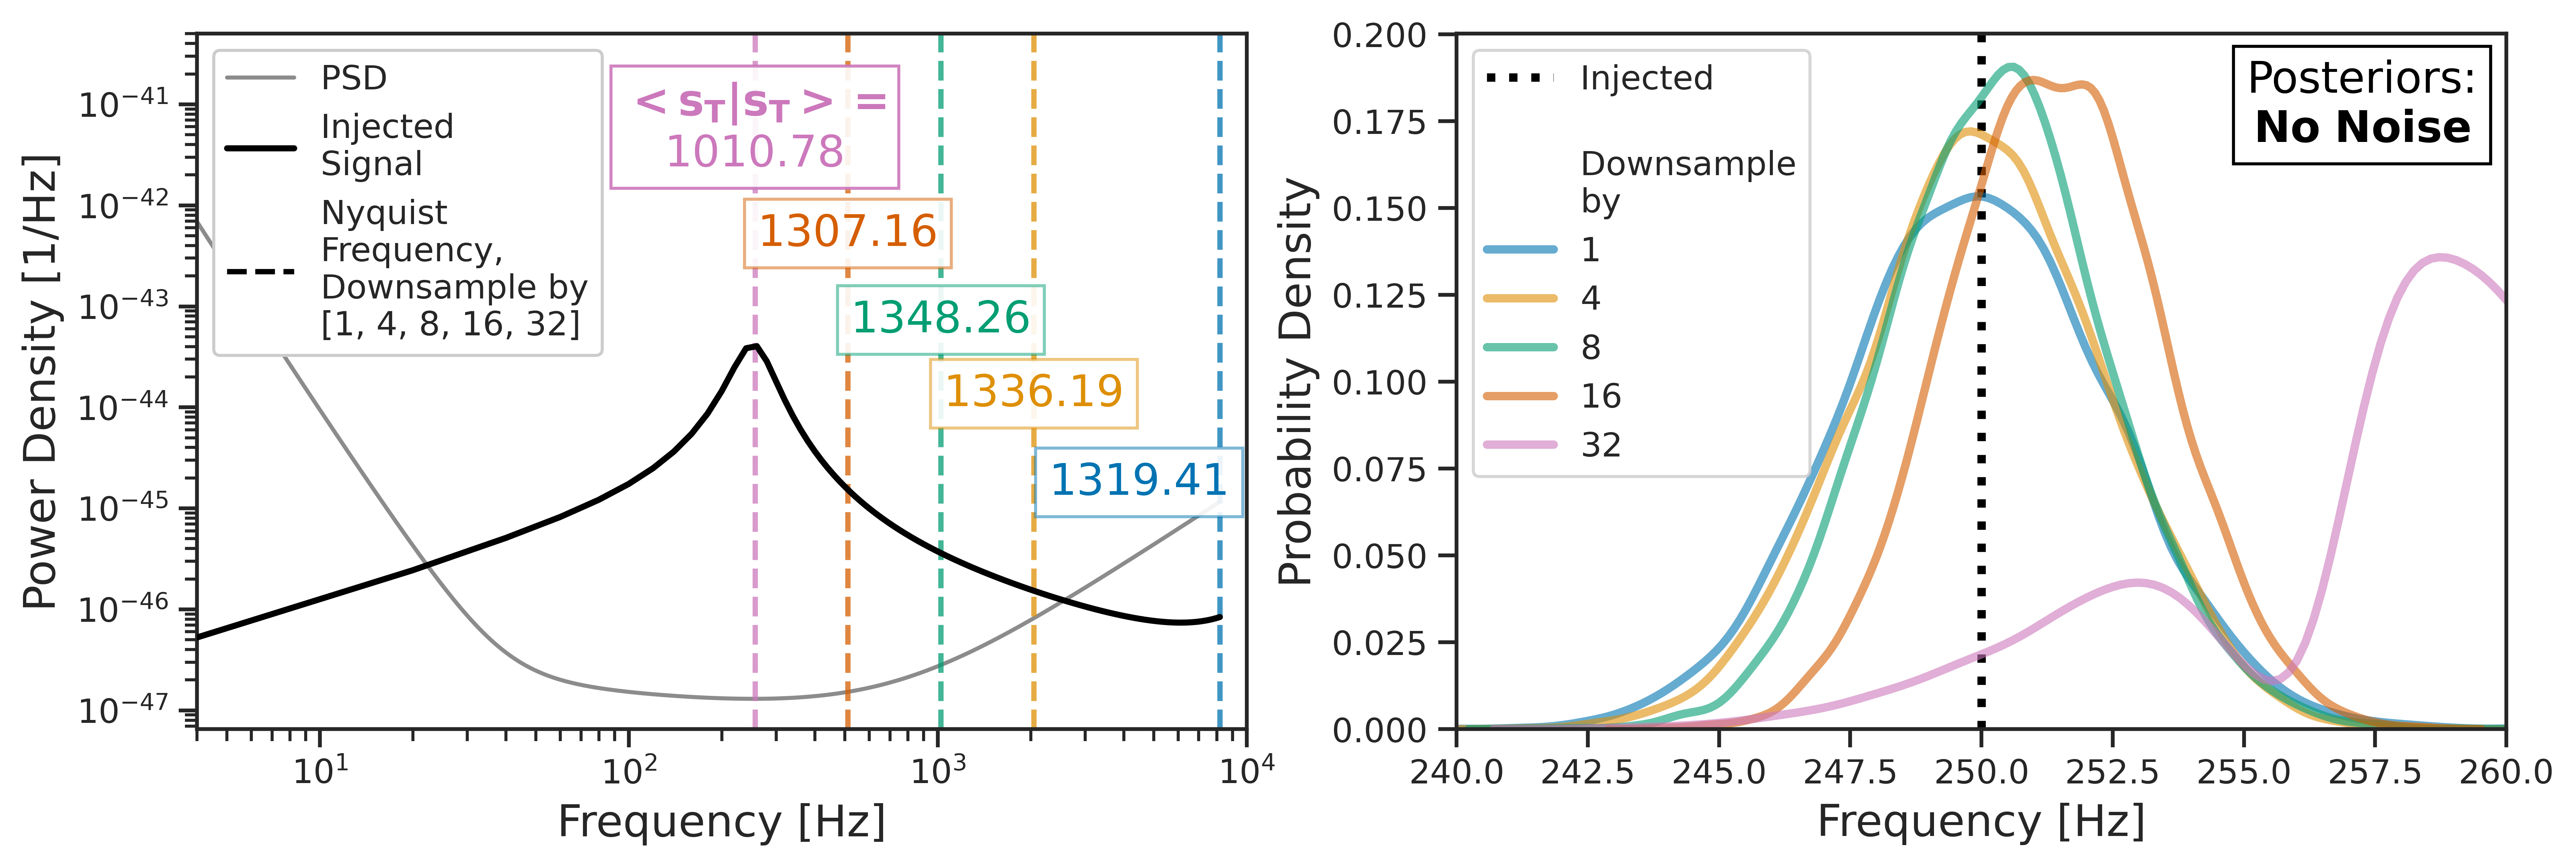

In [28]:
#plotting

fig, ax = plt.subplots(1,2, figsize = (fig_width*2,fig_height), dpi = 300)

cmap = sns.color_palette("colorblind")

small_lw = 2
med_lw = 2.75
big_lw = 3.5

#Plotting for ax[0]
delta_t = 1/sample_rate

ax[0].plot(psd.index, psd.values, label = "PSD", color = "grey", lw = small_lw*2/3, ls = "-", zorder = -100, alpha = 0.9)
        
ax[0].plot(sig_power, color = "black", label="Injected\nSignal", lw=small_lw, zorder = 100)

ax[0].set_ylim(min(psd)*0.5, 5e-41)
ax[0].set_xlim(4,10**4)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xlabel('Frequency [Hz]',fontsize = fs_label)
ax[0].set_ylabel("Power Density [1/Hz]", fontsize = fs_label)
    
c_count = 0
lw = 1.75
lst = "--"
alpha = 0.75

#ann_slope = -3.2 #slope for producing straight lines on loglog plot
#b = np.log(5e-47)-ann_slope*np.log(8192) #y intercept for producing straight lines on loglog plot

ds_str = "["
for x in results_dict.keys():
    ds_str+=str(x)+", "
ds_str = ds_str[:-2]+"]"

for k,v in results_dict.items():
    nyq_freq = sample_rate/(2*k)
    print("Nyq =",nyq_freq)
    
    if k == 1:
        ax[0].axvline(0,label = "Nyquist\nFrequency,\nDownsample by\n{}".format(ds_str),lw = lw, ls = lst, color= "black")
        
    if k==24:
        alpha = 0.95
        
    ax[0].axvline(nyq_freq, ls=lst,color=cmap[c_count],lw = lw, alpha = alpha)
        
    if k==1:
        ann_offset_x = -3700
    else:
        ann_offset_x = 0
    
    x=nyq_freq+ann_offset_x
    #y=np.exp(np.log(x)*ann_slope)*np.exp(b) # produce straight lines on a loglog plot
    y_offset = (c_count+1)**2
    if k ==ds_max:
        y_offset = y_offset/7
    y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
    
    if k==ds_max:
        ax[0].annotate(r'$\bf{<s_T|s_T>=}$' + '\n' + '{:.2f}'.format(snrsq_dict[k]),xy=[x,y],fontsize=fs_label, color=cmap[c_count],ha="center", bbox=dict(fc=clrs.to_rgba("white")[:-1] + (0.9,),ec=clrs.to_rgba(cmap[c_count])[:-1]+(0.9,),boxstyle="square"),zorder = -k+100)
    else:
        ax[0].annotate("{:.2f}".format(snrsq_dict[k]),xy=[x,y],fontsize=fs_label, color=cmap[c_count],ha="center", bbox=dict(fc=clrs.to_rgba("white")[:-1] + (0.9,),ec=clrs.to_rgba(cmap[c_count])[:-1]+(0.5,) ,boxstyle="square"),zorder = -k+100)
    c_count +=1

ax[0].legend(loc="upper left",framealpha=1)

    
#Plotting for ax[1]

kde_dict = {}
ax[1].axvline(250, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
ax[1].axvline(250, zorder = -10, lw=0, color=None, label = "\nDownsample\nby")
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    #if k == ds_max:
    #    alpha = 0.95
    #    lw = big_lw+1
    sns.kdeplot(v.posterior.f.values.flatten(),label = k, linewidth=lw, alpha = alpha, ax = ax[1],color=cmap[c_count])
    print(k, np.std(v.posterior.f.values.flatten()))
    c_count +=1
        
ax[1].set_xlim(f_qnm-10,f_qnm+10)
ann_box_offset_x = 0.8625
ann_box_offset_y = 0.845
ax[1].annotate("Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])*ann_box_offset_x, ax[1].get_ylim()[0]+(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
ax[1].legend(loc = "upper left")
ax[1].set_xlabel('Frequency [Hz]',fontsize = fs_label)
ax[1].set_ylabel("Probability Density",fontsize = fs_label)

plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/downsample_bias_NOnoise",bbox_inches="tight")

#### TGR

In [34]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

id_str = "TGR" # identify runs of interest

for f in [x for x in sorted(os.listdir(results_dir), key = lambda x: int(x.split("ds")[1].split("_")[0])) if id_str not in x and "_noise" not in x and "A14p5" in x and "mchialigned" not in x]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = [float(f.split("A1")[1].split("_")[0].replace("p","."))]
f_qnm = [float(f.split("f1")[1].split("_")[0].replace("p","."))]
tau_qnm = [float(f.split("tau1")[1].split("_")[0].replace("p","."))]
phase_qnm = [float(f.split("ph1")[1].split("_")[0].replace("p","."))]

A.append(float(f.split("A2")[1].split("_")[0].replace("p",".")))
f_qnm.append(float(f.split("f2")[1].split("_")[0].replace("p",".")))
tau_qnm.append(float(f.split("tau2")[1].split(".")[0].replace("p",".")))
phase_qnm.append(float(f.split("ph2")[1].split("_")[0].replace("p",".")))

dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

print(A,f_qnm,tau_qnm,phase_qnm,dur)

GW150914_NOnoise_LIGOPSD_2tones_ds1_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
GW150914_NOnoise_LIGOPSD_2tones_ds4_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
GW150914_NOnoise_LIGOPSD_2tones_ds8_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
GW150914_NOnoise_LIGOPSD_2tones_ds16_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
GW150914_NOnoise_LIGOPSD_2tones_ds32_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
[4.5e-21, 5.999999999999999e-21] [251.0019955101922, 

In [35]:
sample_rate = 2**14
t0 = 128/2
noise_td  = generate_noise(lalpsd = True, sr = sample_rate)
times = noise_td.index

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

GW150914_NOnoise_LIGOPSD_2tones_ds1_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
GW150914_NOnoise_LIGOPSD_2tones_ds4_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
GW150914_NOnoise_LIGOPSD_2tones_ds8_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
GW150914_NOnoise_LIGOPSD_2tones_ds16_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
GW150914_NOnoise_LIGOPSD_2tones_ds32_dur0p05s_A14p5e-21_f1251p0019955101922_ph15p34_tau10p004126712034976183_A25p999999999999999e-21_f2245p42368760857957_ph21p79_tau20p001364782442250195.nc
[4.5e-21, 5.999999999999999e-21] [251.0019955101922, 

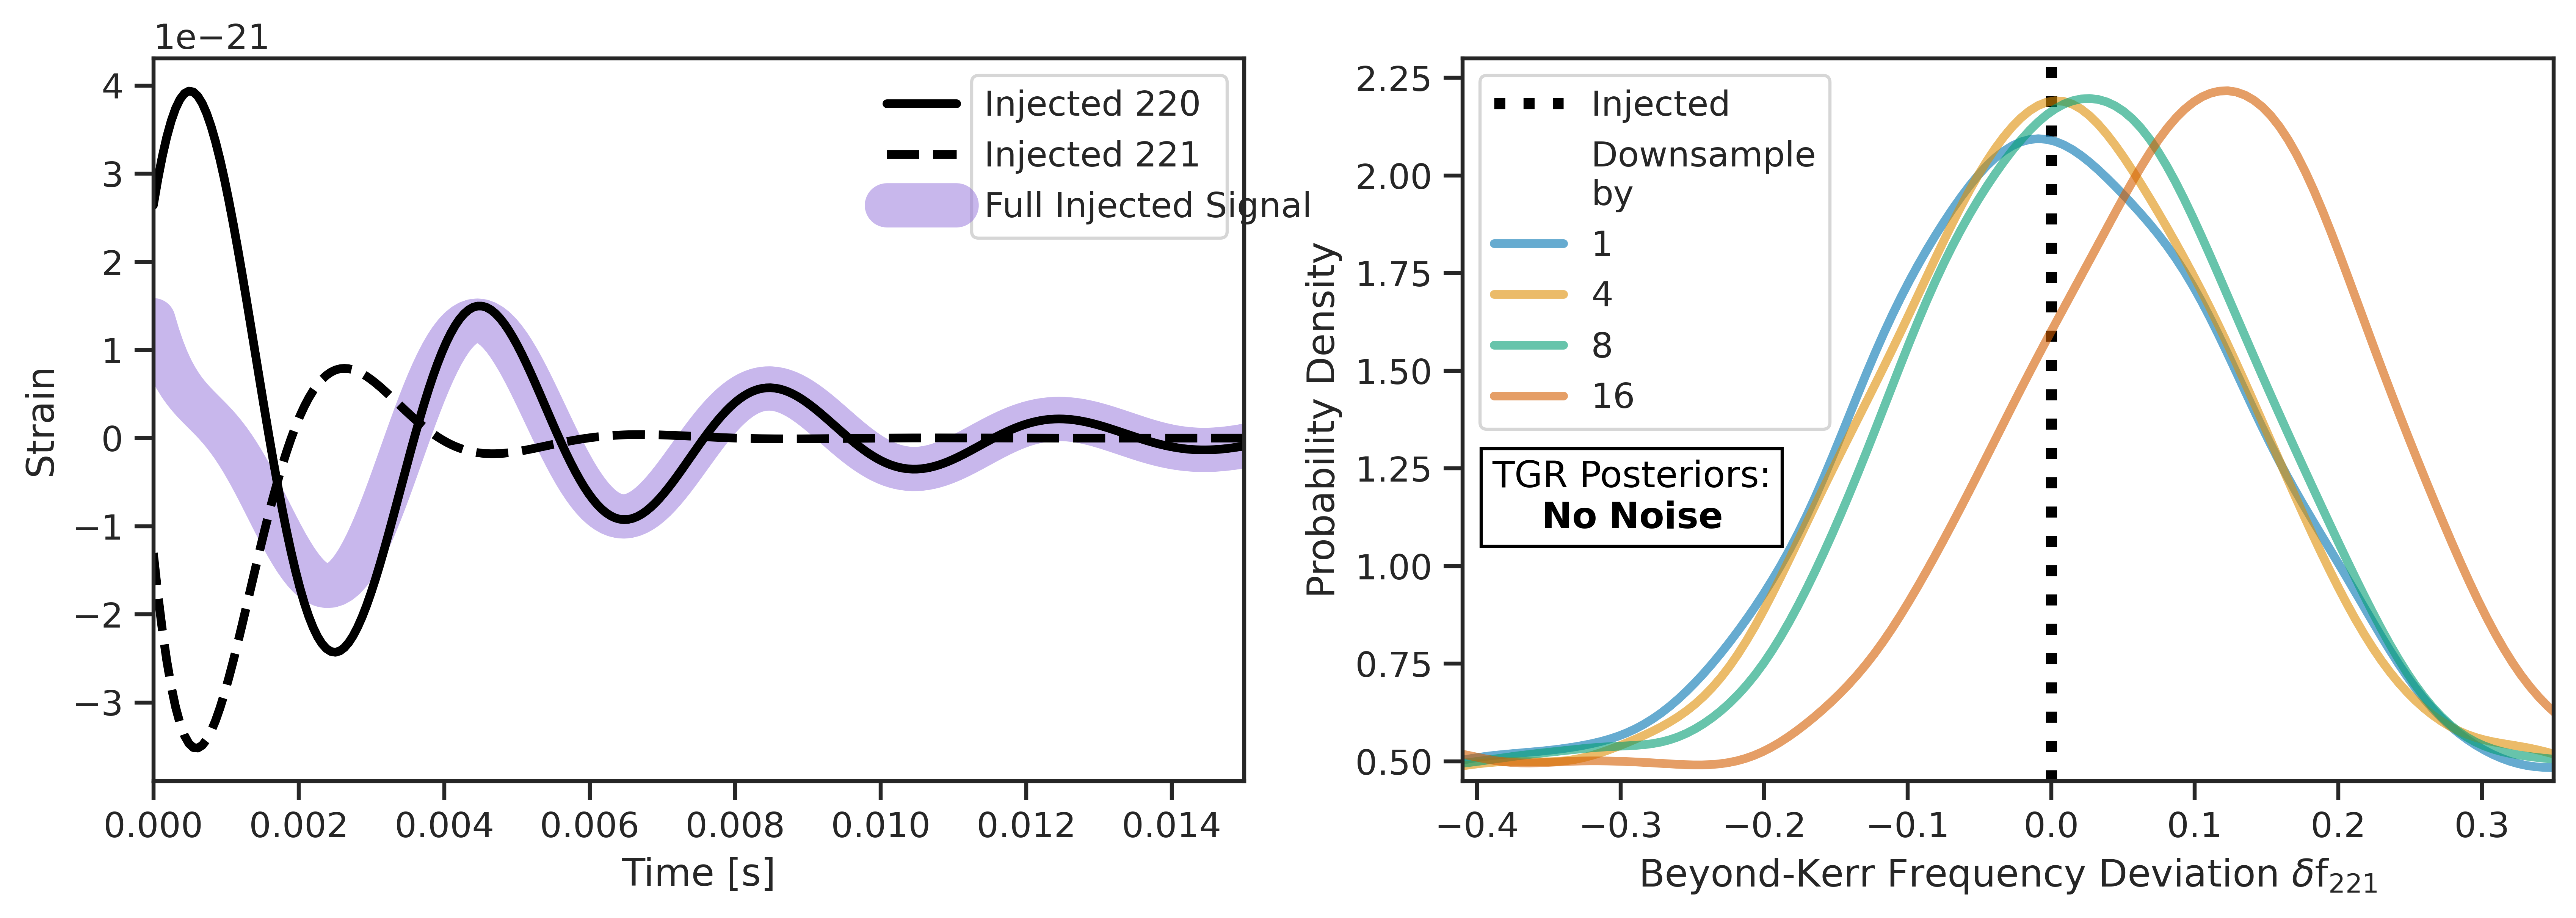

In [37]:
#GR results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

id_str = "TGR" # identify runs of interest

for f in [x for x in sorted(os.listdir(results_dir), key = lambda x: int(x.split("ds")[1].split("_")[0])) if id_str not in x and "_noise" not in x and "A14p5" in x and "mchialigned" not in x]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = [float(f.split("A1")[1].split("_")[0].replace("p","."))]
f_qnm = [float(f.split("f1")[1].split("_")[0].replace("p","."))]
tau_qnm = [float(f.split("tau1")[1].split("_")[0].replace("p","."))]
phase_qnm = [float(f.split("ph1")[1].split("_")[0].replace("p","."))]

A.append(float(f.split("A2")[1].split("_")[0].replace("p",".")))
f_qnm.append(float(f.split("f2")[1].split("_")[0].replace("p",".")))
tau_qnm.append(float(f.split("tau2")[1].split(".")[0].replace("p",".")))
phase_qnm.append(float(f.split("ph2")[1].split("_")[0].replace("p",".")))

dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

print(A,f_qnm,tau_qnm,phase_qnm,dur)

sample_rate = 2**14
t0 = 128/2
noise_td  = generate_noise(lalpsd = True, sr = sample_rate)
times = noise_td.index

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

#plotting

fig, ax = plt.subplots(1,2, figsize = (2*fig_width,fig_height), dpi = 300)

cmap = sns.color_palette("colorblind")

small_lw = 2
med_lw = 2.75
big_lw = 3.5

quantile = .9

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

#Plotting for ax[0]

plot_ts = signal[t0:t0+dur].index
plot_ts = plot_ts-plot_ts[0]

ax[0].plot(plot_ts[::1], signal1[t0:t0+dur][::1].values, label = "Injected 220",ls = "-",lw=med_lw,color="black",alpha=1)
ax[0].plot(plot_ts[::1], signal2[t0:t0+dur][::1].values, label = "Injected 221",ls = "--",lw=med_lw,color="black",alpha=1)
ax[0].plot(plot_ts[::1], signal[t0:t0+dur][::1].values, label = "Full Injected Signal",ls = "-",lw=big_lw*4,color="mediumpurple",alpha=0.5,zorder=-10)


alpha = 0.33
ncols = 1

# ax[0].axvline(0,color=None,label=" ",lw=0)

# ax[0].axvline(0,color=None,label="Downsample by",lw=0)

# for k,f in results_dict.items():
    
#     for md in [b'1220',b'1221']:

#         if k not in [1,16]:
#             continue
        
#         if k==1:
#             cnt = 0
            
#         if k == 16:
#             cnt = 3

            
#         if md == b'1220':
#             linestyle = "-"
#             hatch = None
#             fc = cmap[cnt]#"None"
#             ec = cmap[cnt]
#             #alpha = 0.15
            
#         if md == b'1221':
#             hatch = None
#             fc = cmap[cnt]#"None"
#             ec = cmap[cnt]
#             linestyle = ":"
#             #alpha = 0.8

#         #plot_fs = np.fft.rfftfreq(f.result.posterior.h_det[0][0][0].values.shape[-1])*sample_rate/k
#         plot_ts = f.posterior.h_det[0][0][0].time_index.values*k/2**14

#         signal_td_list = []

#         for i in np.arange(100):
#             #sig_fit=f.result.posterior.h_det[0][i][0].values
#             #signal_FT = np.fft.rfft(sig_fit)/sample_rate*k #0.5 for reflection
            
#             #signal_td_list.append(f.posterior.h_det[0][i][0])
#             signal_td_list.append(f.posterior.h_det_mode.sel(mode=md)[0][i][0])

#         #plt.axvline((sample_rate/k)/2, label = "SR "+str(sample_rate/k),ls="-",color = colors[cnt],lw=4,alpha = 0.5)

#         m = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5,axis = 0),index = plot_ts)
#         u = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5-quantile/2,axis = 0),index = plot_ts)
#         d = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5+quantile/2,axis = 0),index = plot_ts)

#         up, = ax[0].plot(u,color=cmap[cnt],alpha = alpha,lw=small_lw,ls=linestyle)
        
#         if md==b'1220':
#             dp, = ax[0].plot(d,color=cmap[cnt],alpha = alpha,lw=small_lw,label = k,ls=linestyle)
#         else:
#             dp, = ax[0].plot(d,color=cmap[cnt],alpha = alpha,lw=small_lw,ls=linestyle)

#         #mp, = plt.plot(m,color=colors[cnt],alpha = 0.7)
#         ax[0].fill_between(plot_ts,u,d,alpha=alpha,zorder=-cnt,hatch=hatch,facecolor = fc,edgecolor=ec)
        

# ann_box_offset_x = 0.853
# ann_box_offset_y = 0.625
# ax[0].annotate("GR Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[0].get_xlim()[0]+(ax[0].get_xlim()[1]-ax[0].get_xlim()[0])*ann_box_offset_x, ax[0].get_ylim()[0]+(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label*0.8, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
# ncols = 2

ax[0].set_xlim(0,0.0075*2)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Strain")

handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = ax[0].legend(by_label.values(), by_label.keys(),title_fontsize=fs_label*0.8,ncols=ncols)
leg._legend_box.width=600

# TGR Results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

id_str = "TGR" # identify runs of interest

for f in [x for x in sorted(os.listdir(results_dir), key = lambda x: int(x.split("ds")[1].split("_")[0])) if id_str in x and "_noise" not in x and "A14p5" in x and "mchialigned" not in x]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
#Plotting for ax[1]

ax[1].axvline(0, ls = ":", zorder = -100, color="black", label = "Injected",lw=big_lw)

ax[1].axvline(0, zorder = 10, color=None, label = "Downsample\nby",lw=0)

kde_dict = {}
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    #if k == ds_max:
    #    alpha = 0.95
    #    lw = big_lw+1
    sns.kdeplot(v.posterior.df.values.flatten(),label = k, alpha = alpha, color=cmap[c_count],fill=False,lw=med_lw,ax=ax[1])
    c_count +=1
    
ax[1].set_xlim(-0.41,0.35)
ax[1].set_ylim(0.45,2.3)
ax[1].set_xlabel("Beyond-Kerr Frequency Deviation "+r'$\delta$'+"f"+r'$_{221}$')
ax[1].set_ylabel("Probability Density")

ann_box_offset_x = 0.155
ann_box_offset_y = 0.35

ax[1].annotate("TGR Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])*ann_box_offset_x, ax[1].get_ylim()[0]+(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label*0.8, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
leg = ax[1].legend(loc="upper left")

plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/TGR_bias",bbox_inches="tight")

## PSD Spike

### GW190521-like signal

In [38]:
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
    
results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

#for f in [x for x in sorted(os.listdir(results_dir), key = lambda x: float(f.split("dur")[1].split("s_")[0].replace("p","."))) if "Lorentzianspike" in x and "NOISETIMESERIES" not in x and "A3e-21" in x and "sr4096" in x]:
for f in [x for x in sorted(os.listdir(results_dir)) if "GW190521_NOnoise_LIGOPSDLorentzianspike" in x and "dur0p01" not in x]:
    print(f)
    results_dict[float(f.split("dur")[1].split("s")[0].replace("p","."))] = az.from_netcdf(results_dir + f)
    
A = float(f.split("A")[1].split("_")[0].replace("p","."))
f_qnm = float(f.split("f")[2].split("_")[0].replace("p","."))
tau_qnm = float(f.split("tau")[1].split("_")[0].replace("p","."))
phase_qnm = float(f.split("ph")[1].split("_")[0].replace("p","."))
dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

spike_std = float(f.split("S")[2].split(".")[0].replace("p","."))
spike_amp = float(f.split("spikeA")[1].split("M")[0].replace("p","."))
spike_mean = float(f.split("M")[1].split("S")[0].replace("p","."))

print(A,f_qnm,tau_qnm,phase_qnm,dur)
print(spike_std,spike_amp,spike_mean)

#f_qnm = 67.489
#A = 1.2e-21
#tau_qnm = 0.0155

GW190521_NOnoise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67.489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
GW190521_NOnoise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A1p2e-21_f67.489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
GW190521_NOnoise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A1p2e-21_f67.489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
1.2e-21 67.489 0.0155 5.34 0.2
0.05 1.5e-45 67.489


Adding Lorentzian spike to PSD


/tmp/ipykernel_3064402/866215982.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(["{:.2f}".format(x) for x in xticks-xticks[0]])


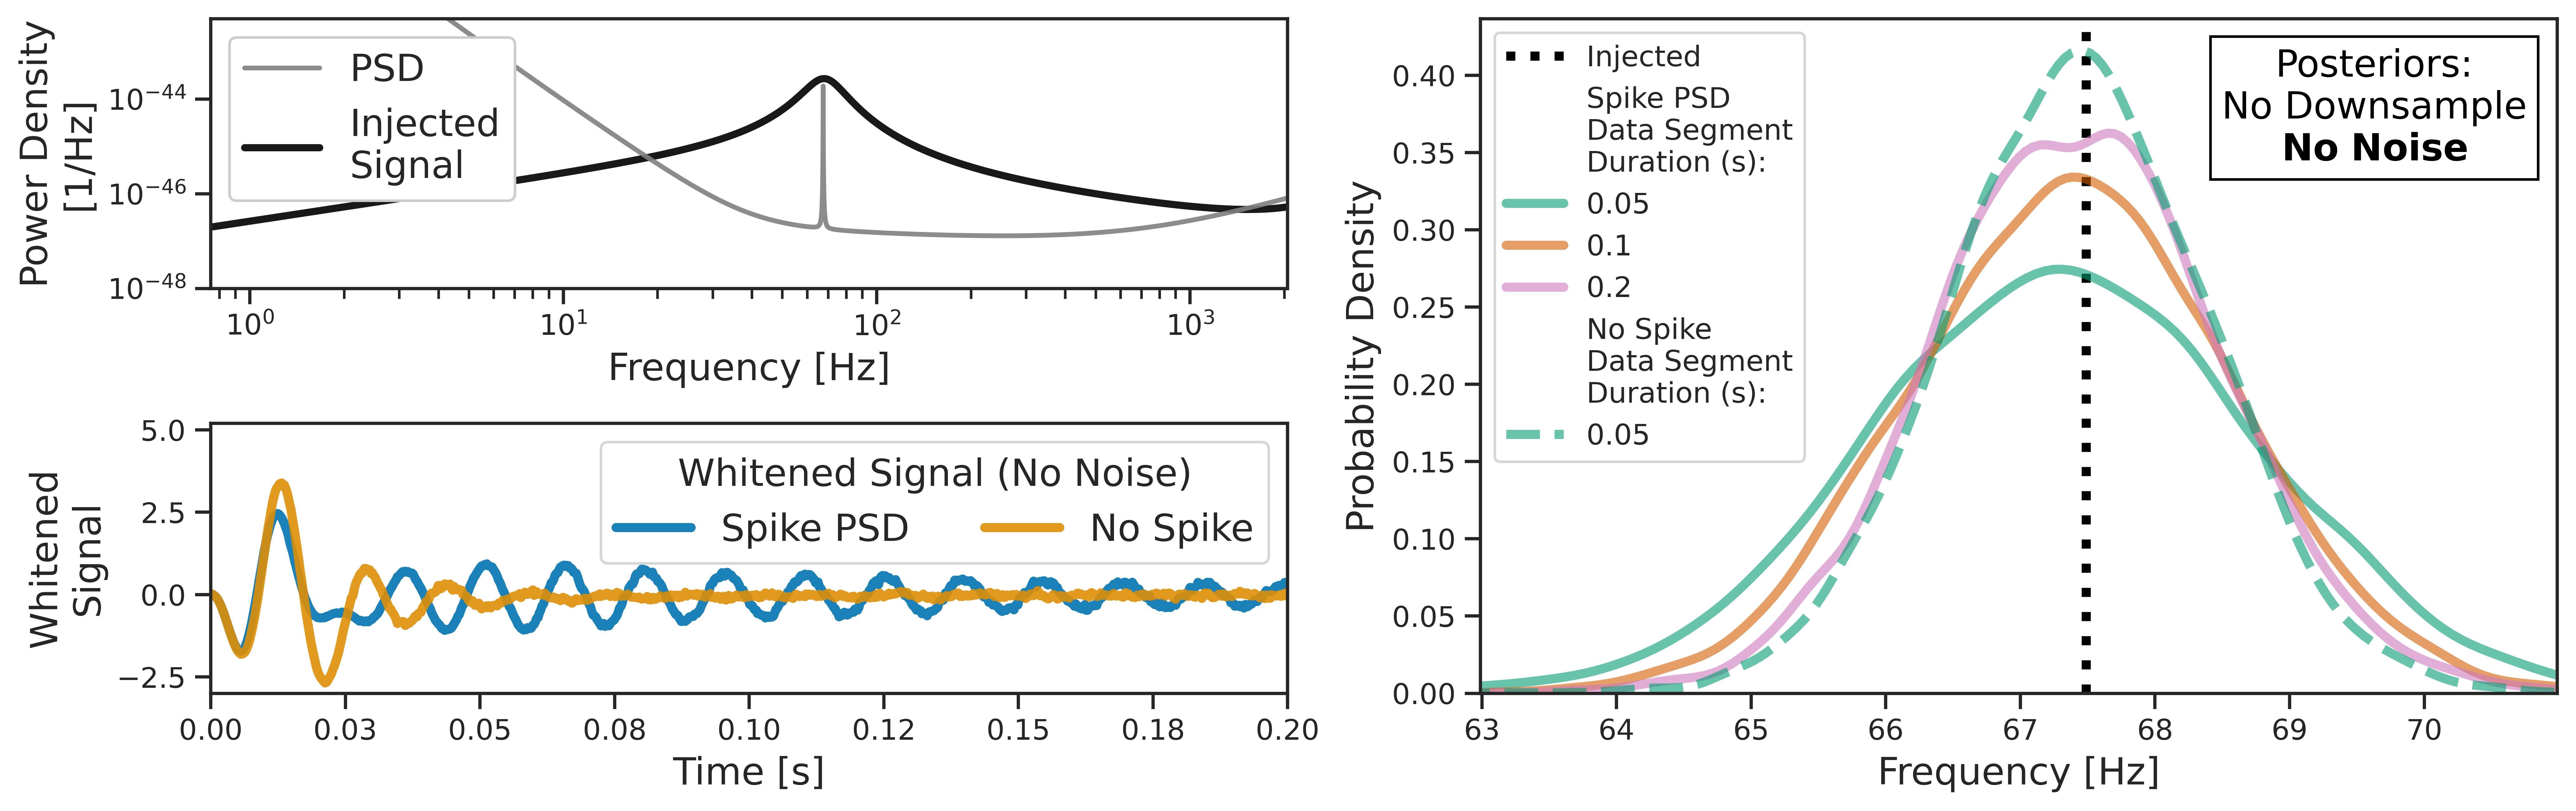

In [71]:
fig = plt.figure(constrained_layout=True, dpi = 300, figsize = (fig_width*2,fig_height))
gs_plot = gs(2, 2, figure=fig)

ax = []
ax1 = fig.add_subplot(gs_plot[0, 0])
ax2 = fig.add_subplot(gs_plot[1, 0])
ax3 = fig.add_subplot(gs_plot[:, 1])
ax.append(ax1)
ax.append(ax2)
ax.append(ax3)

cmap = sns.color_palette("colorblind")
#cmap = sns.color_palette("mako",n_colors=len(results_dict))

small_lw = 2
med_lw = 2.75
big_lw = 3.5

#ax[0]

# PSD parameters
spike_std = 0.05
spike_mean = f_qnm
#spike_amp = 1.5e-45

#data parameters
sample_rate = 2**12
ds = 1
duration = 128
noise_td, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True, spike_amp=spike_amp, spike_mean=spike_mean, spike_std = spike_std)
times = noise_td.index
delta_t = 1/sample_rate
t0 = duration/2
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#number of samples per chain
draws = 2000

acf_analysis = psd_analysis.to_acf()
        
c_count = 0
lw = med_lw
alpha = 0.9

ann_slope = -3.2 #slope for producing straight lines on loglog plot
b = np.log(5e-47)-ann_slope*np.log(8192) #y intercept for producing straight lines on loglog plot

ax[0].plot(psd_analysis.index, psd_analysis.values, color = "grey", lw = lw*2/3, ls = "-", zorder = 1, alpha = alpha,label = "PSD")
freqs_analysis = np.fft.rfftfreq(len(noise_td[t0:]), delta_t)
signal_FT = np.fft.rfft(signal[t0:].values)/sample_rate*2 # multiply by 2 to get power right
sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)
ax[0].plot(sig_power, color = "black", lw=lw, zorder = -100,label = "Injected\nSignal",alpha=alpha)
c_count += 1

ax[0].legend(loc="upper left",fontsize=fs_label, framealpha=1)
ax[0].set_ylim(1e-48, 5e-43)
ax[0].set_xlim(0.75,sample_rate/2)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xlabel('Frequency [Hz]', fontsize = fs_label)
ax[0].set_ylabel("Power Density\n[1/Hz]", fontsize = fs_label)
    
#ax[1]
alpha = 0.9
dur_whiten = 0.4
whtnd_sig = acf_analysis[0:dur_whiten].whiten(signal[t0:t0+dur_whiten]) #Spike whitening
ax[1].plot(whtnd_sig,label="Spike PSD",color=cmap[0],alpha=alpha,lw=big_lw)

noise_td2, psd_analysis2 = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True)
acf_analysis2 = psd_analysis2.to_acf()
whtnd_sig2 = acf_analysis2[0:dur_whiten].whiten(signal[t0:t0+dur_whiten])
ax[1].plot(whtnd_sig2,label="No Spike",color=cmap[1],alpha=alpha,lw=big_lw) #No spike whitening


xmax = 0.2
ax[1].set_xlim(t0,t0+xmax)
ax[1].set_ylim(-3,5.2)

xticks = ax[1].get_xticks()
ax[1].set_xticklabels(["{:.2f}".format(x) for x in xticks-xticks[0]])

ax[1].set_xlabel('Time [s]',fontsize=fs_label)
ax[1].set_ylabel("Whitened\nSignal",fontsize=fs_label)

leg = ax[1].legend(loc="upper right",ncol=2,fontsize=fs_label)
leg.set_title(title="Whitened Signal (No Noise)",prop = {'size':fs_label})
#legend_title_left(leg)

#ax[2]

alpha = 0.6
c_count = 2
lw = big_lw

ax[2].axvline(f_qnm, ls = ":", zorder = -10, color="black", label = "Injected", lw=big_lw)
ax[2].axvline(f_qnm,label = "Spike PSD\nData Segment\nDuration (s):",lw = 0, color= None)

for k,v in results_dict.items():
    #if k > 0.05:
    #    alpha = 0.95
    #    lw = big_lw
    if type(k) is not str:
        sns.kdeplot(v.posterior.f.values.flatten(),label =k, linewidth=lw, alpha = alpha, ax = ax[2],color=cmap[c_count])
        c_count +=1
    else:
        sns.kdeplot(v.posterior.f.values.flatten(),label =k, linewidth=lw, alpha = alpha, ls="--", ax = ax[2],color="grey")
        
ax[2].axvline(f_qnm,label = "No Spike\nData Segment\nDuration (s):",lw = 0, color= None)
no_spike_result = az.from_netcdf("/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOPSD_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67.489_ph5p34_tau0p0155.nc")
sns.kdeplot(no_spike_result.posterior.f.values.flatten(),label = 0.05, linewidth=lw, linestyle = "--", alpha = alpha, ax = ax[2],color=cmap[2])

ax[2].set_xlim(f_qnm-4.5,f_qnm+3.5)
ax[2].legend(loc = "upper left")
ax[2].set_xlabel('Frequency [Hz]', fontsize = fs_label)
ax[2].set_ylabel("Probability Density",fontsize = fs_label)
ann_box_offset_x = 0.83
ann_box_offset_y = 0.79
ax[2].annotate("Posteriors:\nNo Downsample\n"+r'$\bf{No~Noise}$', xy=[ax[2].get_xlim()[0]+(ax[2].get_xlim()[1]-ax[2].get_xlim()[0])*ann_box_offset_x, ax[2].get_ylim()[0]+(ax[2].get_ylim()[1]-ax[2].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))

plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/PSDspike_bias",bbox_inches="tight")

In [73]:
from line_cleaner import clean_strain

In [75]:
noise_td = pd.read_csv("/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/NOISETIMESERIES_GW190521_noise_LIGOPSDLorentzianspike_fundamental_ds1_sr4096_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.csv")
noise_td = ringdown.TimeSeries(noise_td.values.T[1],noise_td.values.T[0])
noise_td += signal
#noise_td = ringdown.TimeSeries(np.append(noise_td[1:].values.T[1],noise_td[1:].values.T[1][1]+noise_td[1:].values.T[1][-1]),np.append(noise_td[1:].values.T[0],noise_td[1:].values.T[0][-1]))

In [135]:
noise_td, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True, spike_amp=spike_amp, spike_mean=spike_mean, spike_std = spike_std)


Adding Lorentzian spike to PSD


In [136]:
noise_td += signal


In [137]:
#duration = 1024
#noise_td, psd_analysis = generate_noise(dur=duration,sr=sample_rate/ds, rtrn_psd=True, lalpsd = True, spike_amp=spike_amp, spike_mean=spike_mean, spike_std = spike_std)

In [138]:
f, p = scipy.signal.welch(noise_td, fs=2**12, nperseg=16*2**12, average='median')

In [140]:
f0s = [f_qnm]
bws = [8]

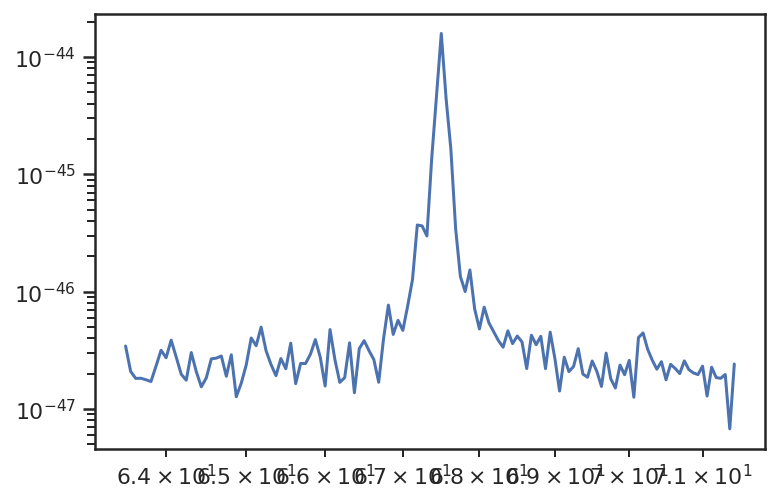

In [141]:
sel = np.abs(f - f0s[0]) < bws[0]/2
plt.loglog(f[sel], p[sel])

In [142]:
f0s = [f_qnm]
bws = [8]
cleaned_times, cleaned_strain, mcmcs, pred_samples, line_model_re, line_model_im, sel, data_freq_re = clean_strain(noise_td.time, noise_td.values, 2**12, f0s, bws, 16.0, return_mcmcs=True)

/mnt/home/hsiegel/ceph/LineCleaner/line_cleaner.py:67: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3871.89it/s, 7 steps of size 6.45e-01. acc. prob=0.91]


In [143]:
noise_td_clean = ringdown.TimeSeries(cleaned_strain, cleaned_times)

In [144]:
f2, p2 = scipy.signal.welch(noise_td_clean, fs=2**12, nperseg=16*2**12, average='median')

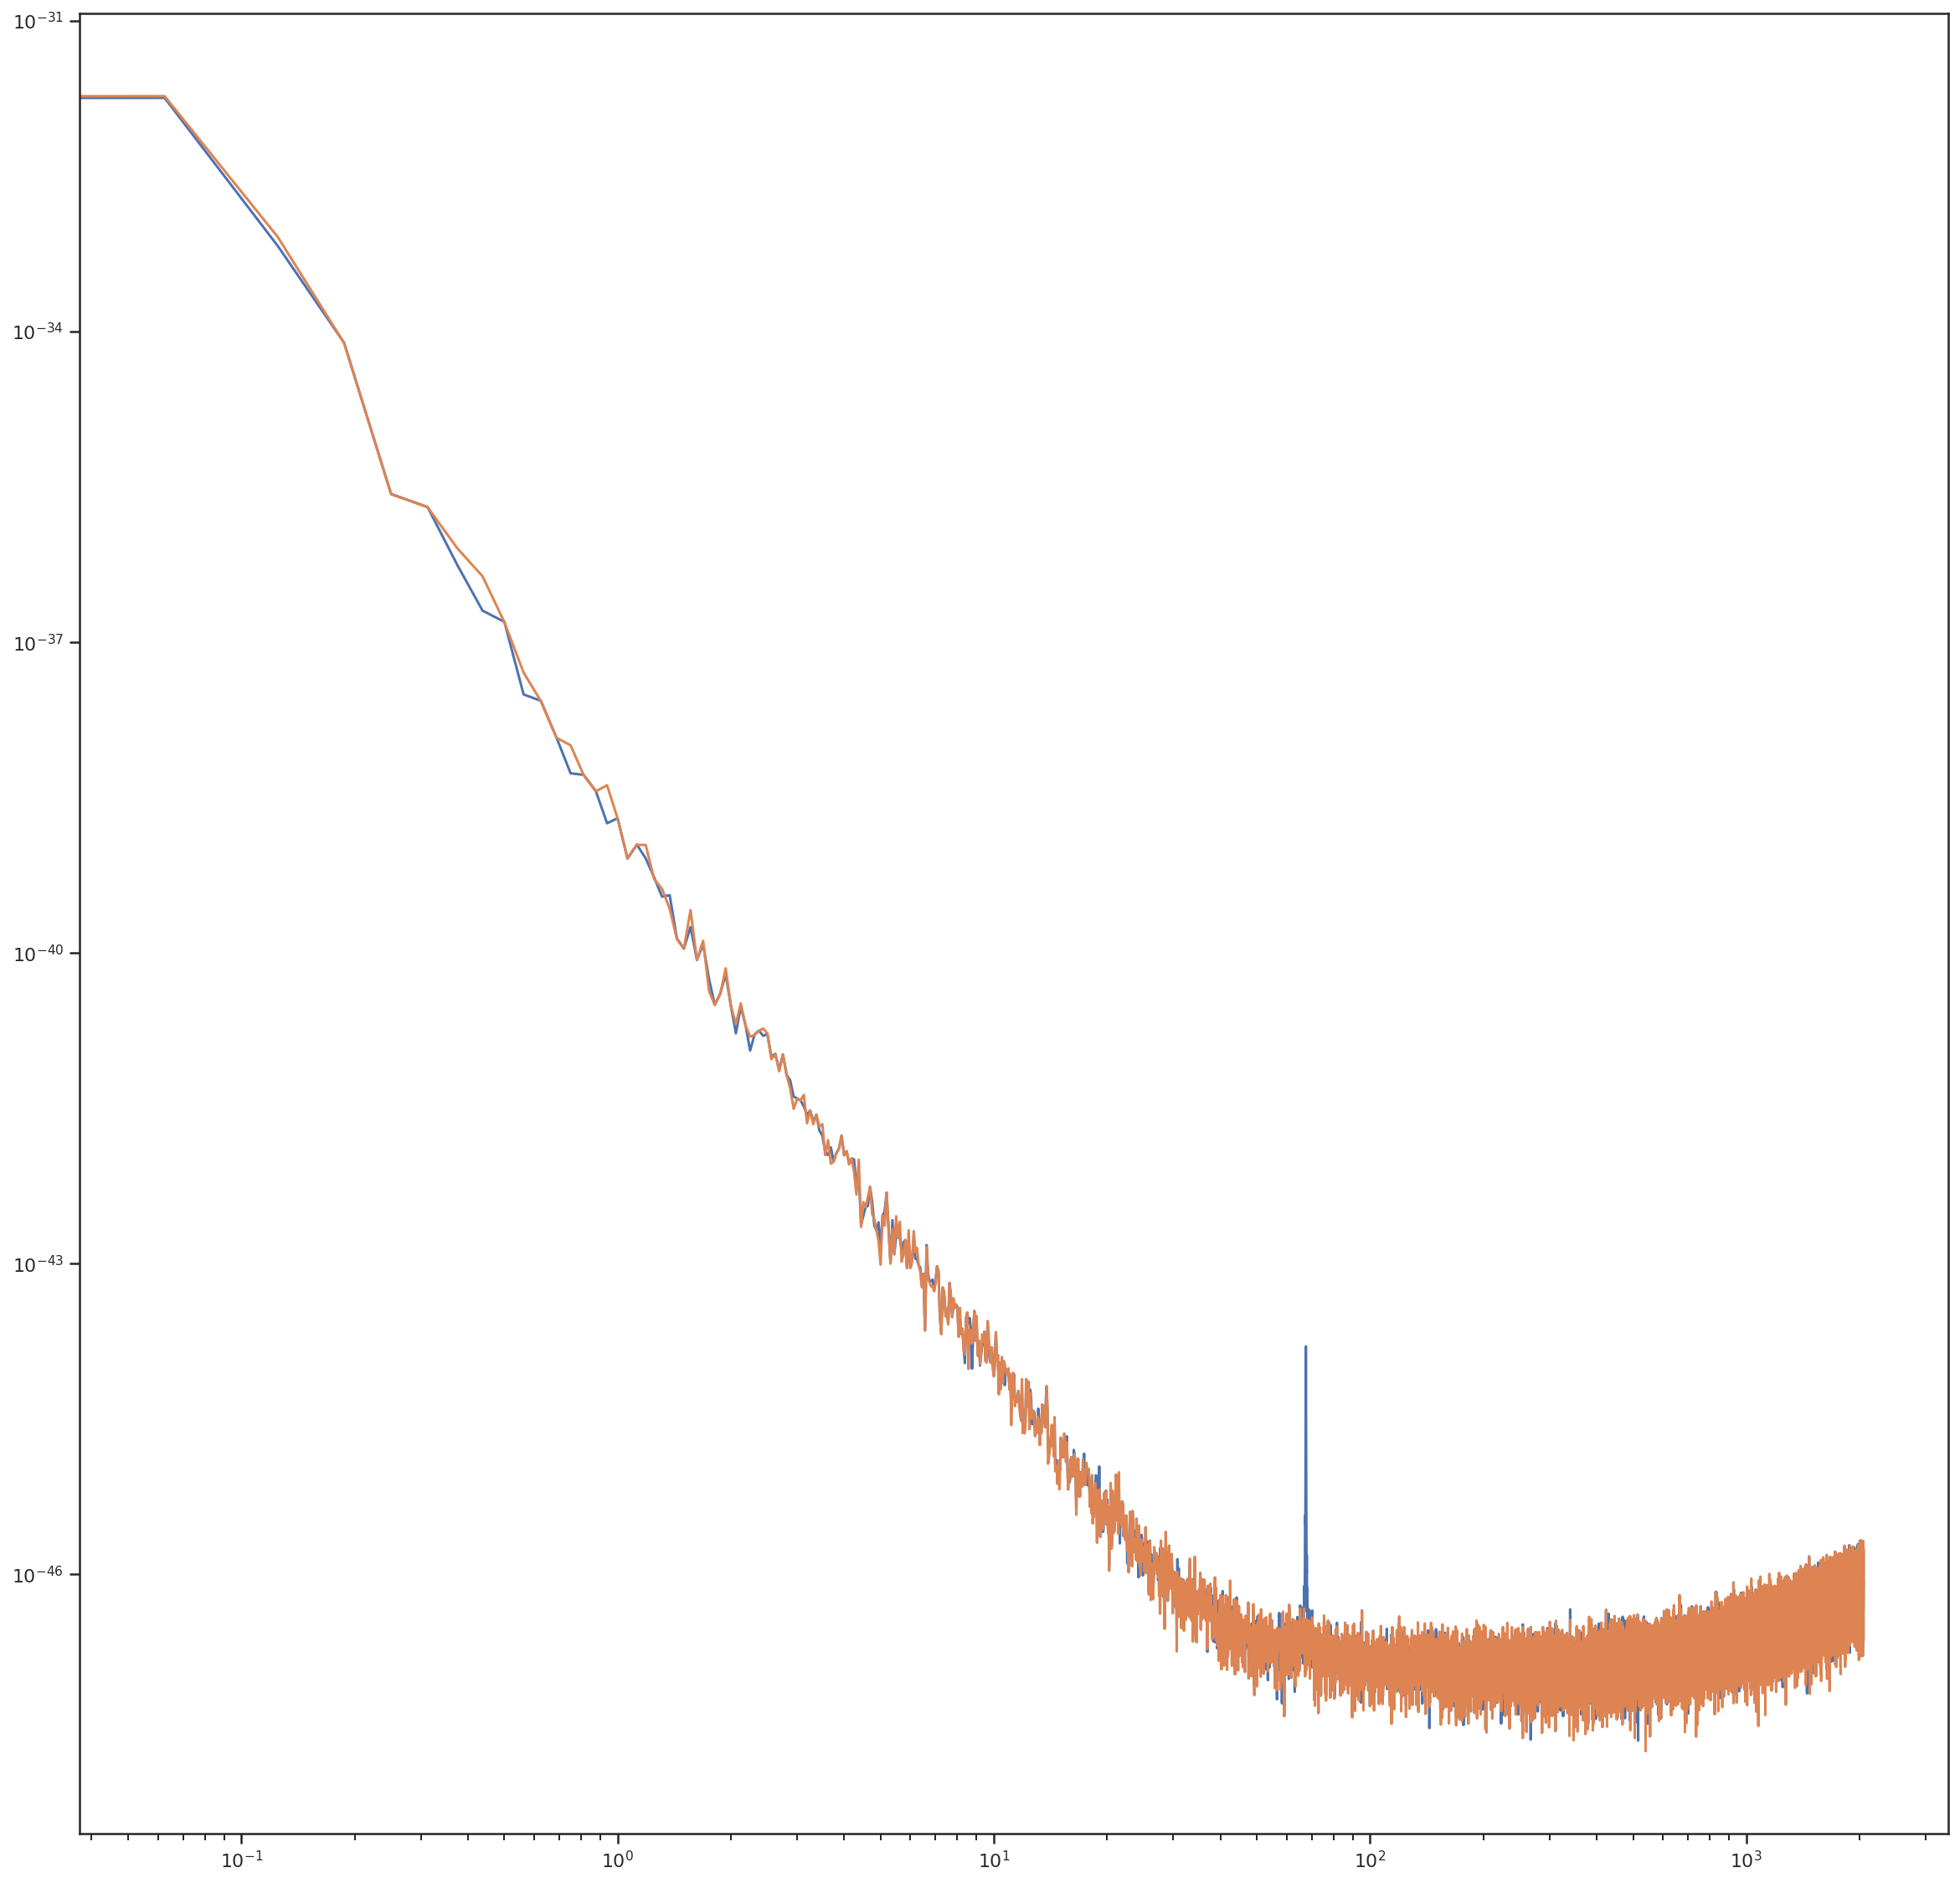

In [145]:
plt.figure(figsize=[20,20])
plt.loglog(f,p)
plt.loglog(f2,p2)

In [146]:
freqs = np.fft.rfftfreq(len(noise_td), 1/2**12)

In [147]:
f_domain_series = ringdown.FrequencySeries(np.zeros(len(freqs)),index=freqs)

In [148]:
f_domain_series[f_qnm-bws[0]/2:f_qnm+bws[0]/2]=line_model_re
f_domain_real = f_domain_series

In [149]:
f_domain_series[f_qnm-bws[0]/2:f_qnm+bws[0]/2]=1j*line_model_im
f_domain_imag = f_domain_series

In [150]:
f_domain_imag[f_qnm-bws[0]/2:f_qnm+bws[0]/2]

63.492188   -0.000000e+00-2.262104e-24j
63.500000   -0.000000e+00-1.650967e-24j
63.507812   -0.000000e+00-1.707222e-24j
63.515625   -0.000000e+00-6.946300e-24j
63.523438    0.000000e+00+6.609440e-24j
                        ...            
71.453125    0.000000e+00+3.451677e-24j
71.460938    0.000000e+00+4.959462e-24j
71.468750    0.000000e+00+6.439802e-26j
71.476562    0.000000e+00+2.380337e-24j
71.484375    0.000000e+00+4.403401e-24j
Length: 1024, dtype: complex128

In [134]:
line_model_td1 = np.fft.irfft(f_domain_real + 1j * f_domain_imag)/(noise_td.time[-1]-noise_td.time[0])*len(noise_td)

In [151]:
line_model_td2 = np.fft.irfft(f_domain_real + 1j * f_domain_imag)/(noise_td.time[-1]-noise_td.time[0])*len(noise_td)

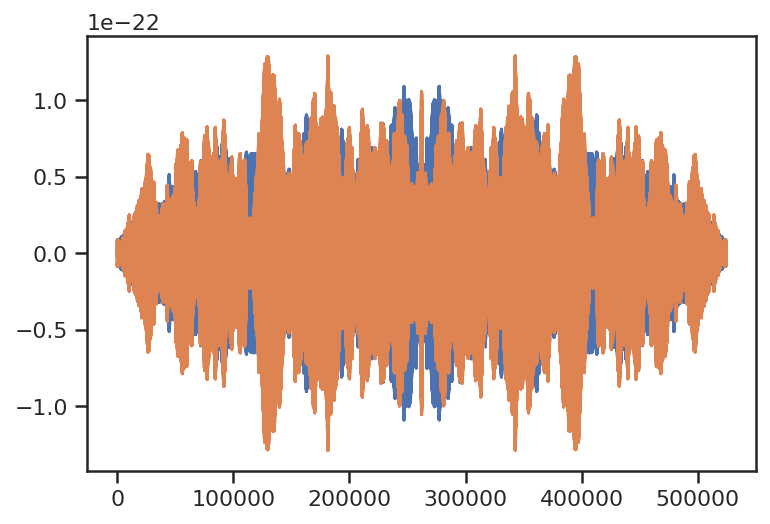

In [152]:
plt.plot(line_model_td1)
plt.plot(line_model_td2)

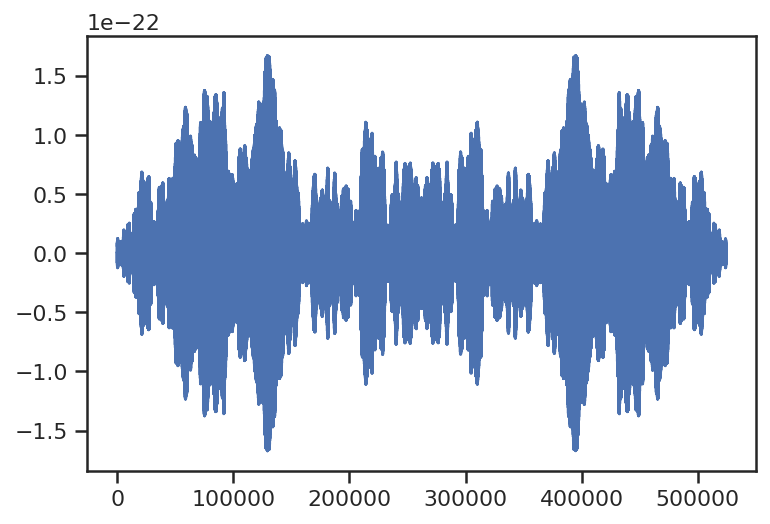

In [153]:
plt.plot(np.array(line_model_td1-line_model_td2))

In [154]:
line_model_diff = ringdown.TimeSeries(line_model_td1-line_model_td2,index=noise_td.index)

<Axes: >

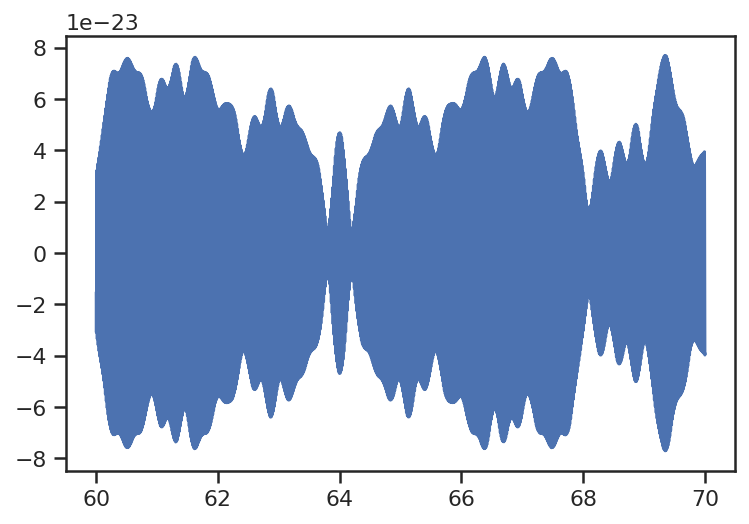

In [155]:
line_model_diff[60:70].plot()

In [85]:
yea = 0.05*16
print("Duration:",yea)
ss = np.sum(np.square(whtnd_sig[64:64+yea]))
print("Optimal SNR, spike:",np.sqrt(ss))
ss = np.sum(np.square(whtnd_sig2[64:64+yea]))
print("Optimal SNR, no spike:",np.sqrt(ss))

Duration: 0.8
Optimal SNR, spike: 18.428711191566208
Optimal SNR, no spike: 19.994571386901146


# Filtering Test

In [73]:
from scipy.signal._filter_design import cheby1

In [75]:
cheby1(8,0.05,0.8,output="sos")

array([[0.13690162, 0.27380324, 0.13690162, 1.        , 0.27703045,
        0.08649574],
       [1.        , 2.        , 1.        , 1.        , 0.90702205,
        0.46559866],
       [1.        , 2.        , 1.        , 1.        , 1.35404791,
        0.748099  ],
       [1.        , 2.        , 1.        , 1.        , 1.58787551,
        0.92444704]])

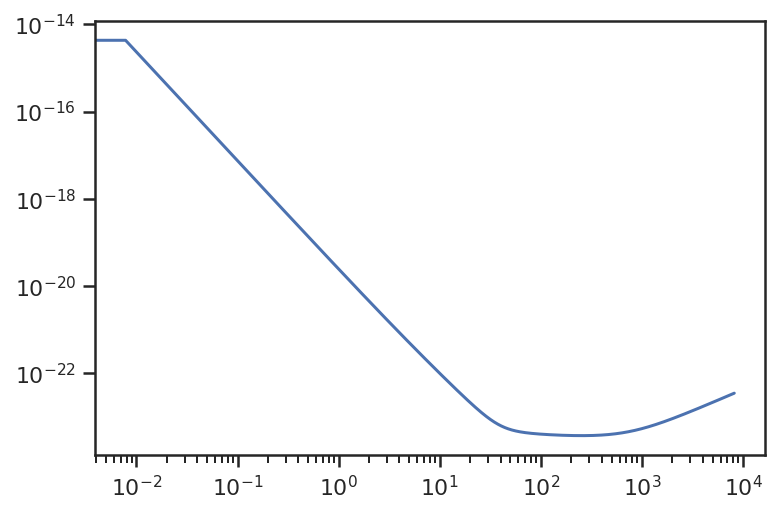

In [80]:
plt.loglog(np.sqrt(psd))

In [88]:
psd

0.000000       1.877612e-29
0.007812       1.877612e-29
0.015625       5.870971e-31
0.023438       7.735841e-32
0.031250       1.836824e-32
                   ...     
8191.968750    1.161207e-45
8191.976562    1.161210e-45
8191.984375    1.161212e-45
8191.992188    1.161214e-45
8192.000000    1.161216e-45
Length: 1048577, dtype: float64

In [102]:
f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
#phase_qnm = np.pi/2
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])


In [133]:
noise_td

0.000000     -2.411700e-16
0.000061     -2.411666e-16
0.000122     -2.411664e-16
0.000183     -2.411627e-16
0.000244     -2.411637e-16
                  ...     
127.999695   -2.411784e-16
127.999756   -2.411759e-16
127.999817   -2.411741e-16
127.999878   -2.411734e-16
127.999939   -2.411700e-16
Length: 2097152, dtype: float64

In [132]:
signal

0.000000      0.0
0.000061      0.0
0.000122      0.0
0.000183      0.0
0.000244      0.0
             ... 
127.999695    0.0
127.999756    0.0
127.999817    0.0
127.999878    0.0
127.999939    0.0
Length: 2097152, dtype: float64

In [139]:
noise_td, psd = generate_noise(lalpsd = True,rtrn_psd=True)


In [142]:
asd = np.sqrt(psd)
asd_ift = np.fft.irfft(asd) # multiply by 2 to get power right
asd_filt = scipy.signal.decimate(signal,ds,zero_phase=True)

asd_FT = np.fft.rfft(asd_filt) # multiply by 2 to get power right
delta_t = ds/sample_rate
freqs_analysis = np.fft.rfftfreq(len(asd_filt), delta_t)
print(freqs_analysis[1])
psd = ringdown.FrequencySeries(freqs_analysis*(asd_FT.real**2+asd_FT.imag**2),freqs_analysis)


0.001953125


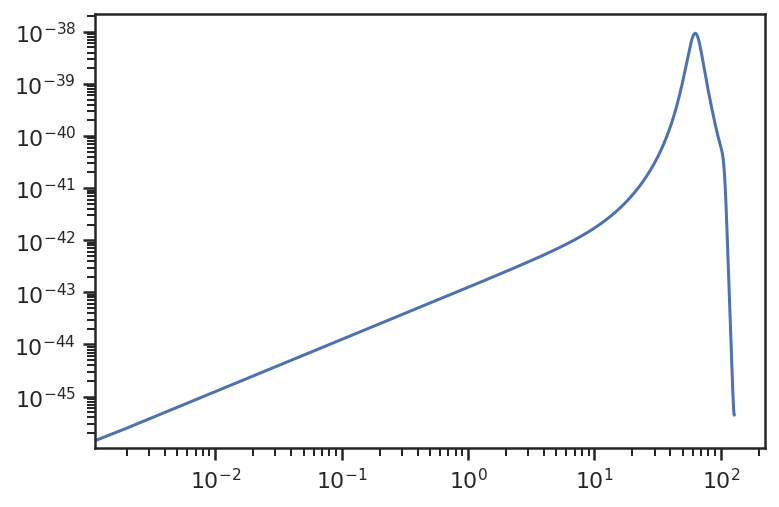

In [143]:
plt.loglog(psd)

0.001953125
0.001953125
0.001953125
0.001953125
0.001953125


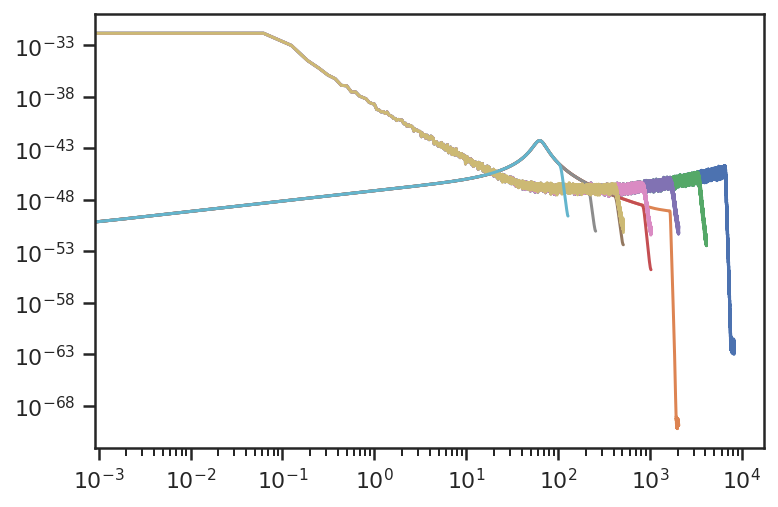

In [131]:
noise_td, psd = generate_noise(lalpsd = True,rtrn_psd=True)
times = noise_td.index
f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
#phase_qnm = np.pi/2
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])
for ds in [1,2,4,8,16]:
    noise_filt = scipy.signal.decimate(noise_td,ds,zero_phase=True)
    sig_filt = scipy.signal.decimate(signal,ds,zero_phase=True)
    
    f2, p2 = scipy.signal.welch(noise_filt, fs=2**14/ds, nperseg=16*2**14/ds, average='median')
    welch = ringdown.FrequencySeries(p2,f2)
    plt.loglog(welch)
    
    signal_FT = np.fft.rfft(sig_filt)*ds/sample_rate*2 # multiply by 2 to get power right
    delta_t = ds/sample_rate
    freqs_analysis = np.fft.rfftfreq(len(sig_filt), delta_t)
    print(freqs_analysis[1])
    sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)
    plt.loglog(sig_power)

In [98]:
psd_filt = ringdown.PowerSpectrum(asd_filt**2,index=psd.index[0:len(asd_filt)])

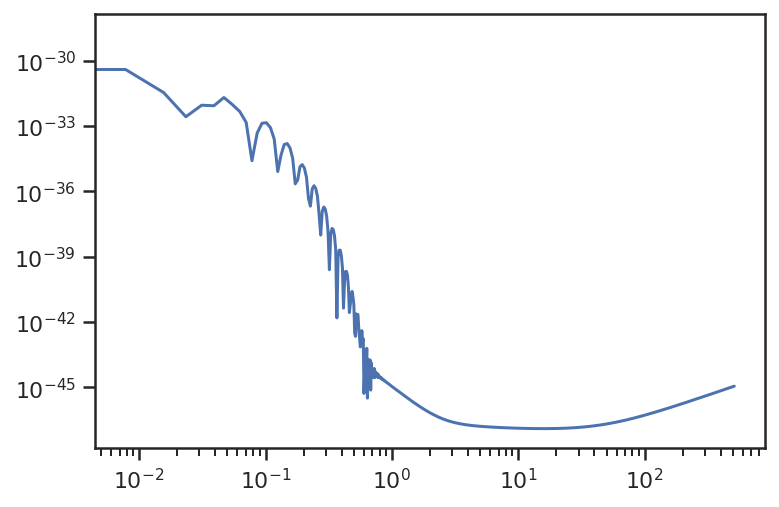

In [99]:
plt.loglog(psd_filt)

# Appendix

Note that if we were to convolve our time series with a filter, we would be multiplying the series in the frequency domain by the FT of the filter. This creates a filtered time series $\{y_{\text{filt}}(t)\}$, whose PSD is given by

&emsp;$S_{\text{filt}} (f) = |\tilde{K}(f)|^2~S(f)$,

where $\tilde{K}(f)$ is the FT of the time-domain filter.